In [1]:
# mainSim code
# thalamic model
# AUG 9 2021

# deprecatd.  this is a test of the thalamic model with the CX inhibiting the thalamus. 

In [2]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import brian2

import pickle
import copy

import seaborn as sns


In [3]:
# load helper functions
from helper import generate_pref, plot_pref
import modelHelper

# load model class
from circuitModel import model

In [4]:
# load arealist
area_list = list(np.loadtxt('results/area_list.csv', delimiter=',', dtype='str'))
thal_list = list(np.loadtxt('results/thal_list.csv', delimiter=',', dtype='str'))
# load connectivity 
conn_cxcx = np.loadtxt('results/conn_cxcx.csv', delimiter=',')
conn_cxth = np.loadtxt('results/conn_cxth.csv', delimiter=',')
conn_thcx = np.loadtxt('results/conn_thcx.csv', delimiter=',')

# load interneuron density
normPVgrad_df = pd.read_csv('results/dfPV.csv', header = 0, index_col=0)
normSSTgrad_df = pd.read_csv('results/dfSST.csv', header = 0, index_col=0)

# load hierarchy
hierarchy_df = pd.read_csv('results/dfHier.csv', header=0, index_col=0)
hierarchy = np.array(hierarchy_df['hierarchy index'])

In [5]:
# define divisions from Harris et al.
div = {'somatomotor':['SSp-bfd','SSp-tr','SSp-ll','SSp-ul',
                     'SSp-un','SSp-n','SSp-m','SSs','MOp','MOs'],
      'visual':['VISal','VISl','VISp','VISpl',
                'VISli','VISpor','VISrl'],
      'medial':['VISa','VISam','VISpm','RSPagl',
               'RSPd','RSPv'],
      'prefrontal':['FRP','ACAd','ACAv','PL',
                   'ILA','ORBl','ORBm','ORBvl'],
      'lateral':['AId','AIv','AIp','VISC',
                 'GU','TEa','PERI','ECT'],
      'auditory':['AUDd','AUDp','AUDpo','AUDv']}

div_color_list = np.array([[255, 140, 0],
                           [169, 164, 217],
                           [22, 37, 128],
                           [220,20,60],
                           [218,165,32],
                           [91,  0,  105]])/255
div_name_list = ['somatomotor',
                 'visual',
                 'medial',
                 'prefrontal',
                 'lateral',
                 'auditory']

In [6]:
# define parameters
parameters = {}
p = parameters
parameters['alpha_pref'] = 0
parameters['beta_pref'] = 2.42  # 2.42    2.55

parameters.update({'SF1': 0.5, # Jorge M scaling factor to keep rates in check
                    'SF2': 2})    # Jorge M scaling factor to keep rates in check
                
parameters.update(
    { # Time constants
    'tau_NMDA': 0.06   * brian2.second,    # s 
    'tau_GABA': 0.005  * brian2.second,    # s 
    'tau_AMPA': 0.002  * brian2.second,    # not used in the model
    'tau_rates': 0.02 * brian2.second,    # same as tau_AMPA
    'tau_noise': 0.002 * brian2.second,    # same as tau_AMPA
    # f-I curve parameters - E populations
    'a_E': 280. *parameters['SF1']  * brian2.Hz/brian2.nA,  # Hz/nA
    'b_E': 108. *parameters['SF1']  * brian2.Hz,            # Hz
    'd_E': 0.154*parameters['SF2']  * brian2.second,        # s
    'gamma_NMDA': 0.641*parameters['SF2'],                         # unitless

    'gamma_AMPA':  parameters['SF2'],            # TODO not determined
    # f-I curve parameters - I populations
    'g_2': 1/(0.5*parameters['SF1']),                    # unitless
    'c_I': 615  * brian2.Hz/brian2.nA,                 # Hz/nA
    'c_0': 177  * brian2.Hz,                           # Hz
    'gamma_GABA': parameters['SF2'],                       # unitless
    # Local connectivity matrix strengths
    # Strength of connections from E cells
    'g_E_self': 0.42 * brian2.nA , # nA   0.42 works for all cases. 
    'g_E_cross': 0.0107* brian2.nA,         # nA
    # Local connectivity E to I
    'g_I_E': 0.4087 * brian2.nA,
    # Strength of connections from I cells
    'g_E_I':  0.32    * brian2.nA,         # nA  key param to tune
    #0.32
    # larger g_E_I allows the Activity propagation to be stable, Balance amplification.
    # original -0.31
    'g_Iself': 0.15   * brian2.nA,         # 0.12 nA
    # John Murray's term
    'J_plus': 0.2112   * brian2.nA,         # nA - Matches value in John Murray's thesis for g_E_self - g_E_cross
    # Background inputs
    'I0_E': 0.305 * brian2.nA,         # nA
    #0.305 works well.
    #0.3294 gives PA for disconnected network also for multiple attractor.(multatt)
    #0.3294 gives PA for disconnected network and in this case a smaller kFLN (0.19)can make good propagation. 
    'I0_I': 0.26       * brian2.nA,         # nA
    #0.26
    # Noise std dev
    'std_noise': 0.005 * brian2.nA,         # nA      
#                     'std_noise': 0.000 * brian2.nA,         # nA      
    # initial values
    'r0_E': 5 * brian2.Hz,
    'r0_I': 11*parameters['SF1'] * brian2.Hz
        })      
parameters.update({ # Zetas
    'zeta': parameters['c_I']*parameters['g_E_I']*parameters['tau_GABA']*parameters['gamma_GABA']\
            /(parameters['g_2'] - parameters['g_Iself']*parameters['tau_GABA']*parameters['gamma_GABA']*parameters['c_I']),
    'zeta2': 2*parameters['c_I']*parameters['tau_GABA']*parameters['gamma_GABA']*parameters['g_E_I']\
            /(parameters['c_I']*parameters['tau_GABA']*parameters['gamma_GABA']*parameters['g_Iself'] - parameters['g_2']),
        })    

parameters.update({ # Long-range strength
    'mu_EE': 1.8*0.05, # unitless - G in Jorge M's code key param to tune
        # larger mu_EE allows a loop-based persistent activity
        # original 0.86 for beta=4.4
    'ratio_mu_IE_mu_EE': 3/1.8
        # original 0.48
        })    
parameters.update({'mu_IE': parameters['mu_EE']*parameters['ratio_mu_IE_mu_EE']})

######## HIERARCHY ########
# TODO: need to rewrite this part of code for clarity
parameters.update({
    'JEE_scaling_factor' : 0,  # eta in Chaudhuri et al., 2015
   'JEI_scaling_factor' : 0.5,  #|scaling| should be smaller than 1  # JEI scaling -0.8 working.
  'JII_scaling_factor' : 0.5, # JII scaling -0.6 working.
    'JIE_scaling_factor': 0.5,

  'J_NS_grad_min' : 1, #J_N_IE_min is not needed, since it is determined by Jorge's equation.
   'J_G_EI_min' : 0.6, # note that this is negative
    'J_G_II_min' : 0.7, #note that this is negative  #Scale the local E to E,local I to E,LR EE synapses to lie according to the hierarchy
    """"""
    'J_N_IE_min' : 0.65,
    """"""    """"""

#                     'kFln' : 0.05, # when using fln max to normalize, kfln=0.085 not 0.85
   # fln_squish = kFln*np.power(fln,kSquishFln) # 1 for usual model  0.09 for multiple attractor; 0.13 for mult attractor.(multatt)
   'kSquishFln' : 0.3, # to make the fln vary in a smaller range. fln_squish = kFln*np.power(fln,kSquishFln) 
                # Set up the matrix that defines how different populations between different areas interact with each other
    'LR_E_self' : 1,
    'LR_E_cross' : 0,  # Don't have any long-range cross population conns
    'LR_I_E' : 1,
    # Choose stimulus and distractor strength
    'stim_strength' : 0.07 * brian2.nA, # stim length changed to 1s.   0.1*nA and stim length 0.5s before
    'inh_strength' : -0.1*brian2.nA,
    'BLA_stim_strength' : 0.2*brian2.nA, 
    'thalamic_base_strength' : 0.05* brian2.nA,  # I choose to make it smaller than stim strength. 
    # original 0.3
    'distractor_strength' : 0 * brian2.nA, 
    'inhibition_strength' : -0.3* brian2.nA
    }) 

# Th CX model
parameters.update({
    'stim_strength_th':0.1*brian2.nA,    # nA
  'I0_th_E': 0.305 * brian2.nA,         # nA
   'g_th_cx_E': 0.01    * brian2.nA,         # nA TODO tunable
   'g_th_cx_I': 0 * brian2.nA,          #nA  no connection from th to cx interneuron.
   'g_cx_th': 0.01      * brian2.nA,
   'p_D': 0.45,        # parameters for STD
   'tau_D': 600*brian2.ms        # parameters for STD
  })


parameters['dt']=0.5 * brian2.ms  # timestep 
parameters['trial_length']=10000 * brian2.ms # trial length (s)
parameters['inh_multiarea'] = []
parameters['PAthreshold'] = 5 #Hz


parameters['stim_on'] = 3*brian2.second
parameters['stim_off'] = 4*brian2.second

parameters['inh_stim_on'] =  7*brian2.second
parameters['inh_stim_off'] =  8*brian2.second


parameters['div'] = div
parameters['div_color_list'] = div_color_list
parameters['div_name_list'] = div_name_list

0.9183397445384054


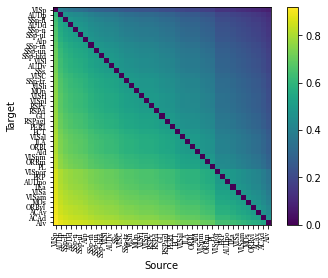

In [7]:
# # generate preference matrix
# a = np.array(normPVgrad_df)
# b = np.matlib.repmat(a,1,len(a))
# for i in range(b.shape[0]):
#     b[i,i] = 0
# parameters['minValueLR'] = 0 # 0.5
# parameters['slopeLR'] = 1
# pref_matrix = parameters['slopeLR'] * b + parameters['minValueLR']  # 0.5 * (b - 0.5) + 0.5 when W_E = W*(pref)
# # plt.imshow(pref_matrix)
# # plt.colorbar()

# np.fill_diagonal(pref_matrix, 0)

# generate longrange preferential targeting matrix via hierarchy
pref_matrix = generate_pref(hierarchy, parameters)
# pref_matrix = pref_matrix.T
plot_pref(pref_matrix, area_list)
print(np.max(pref_matrix))

In [8]:
plt.imshow(conn_cxth)
plt.colorbar()

In [248]:
# mainsim 
parameters['trial_length'] = 10000 * brian2.ms # trial length (s) 
# change noise level and stim strength before simulation.
parameters['stim_on'] = 2 * brian2.second
parameters['stim_off'] = 2.5 * brian2.second
parameters['distract_on'] = 9.5 * brian2.second
parameters['distract_off'] = 12 * brian2.second
parameters['stim_strength'] = 0.5 * brian2.nA
parameters['distract_strength'] = 10 * parameters['stim_strength']
parameters['inh_strength'] = - 0.4 * brian2.nA
parameters['inh_stim_on'] = 10 * brian2.second
parameters['inh_stim_off'] = 13 * brian2.second

parameters['std_noise'] = 0.005 * brian2.nA

#####
parameters['WNormalizedbyRow'] = False


######
parameters['I0_E_mean'] = 0.305 * brian2.nA   #284 thala  #305 cortex
######
parameters['I0_E_min'] = parameters['I0_E_mean']
parameters['I0_E_max'] = parameters['I0_E_mean']

#######################
parameters['I0_th_E'] = 0.305 * brian2.nA  # 0.405*brian2.nA            #0.385*brian2.nA         #0.355 * brian2.nA   #0.285 * brian2.nA
# parameters['g_th_cx_E'] = 0.8 * brian2.nA  #0.6 #0.15*brian2.nA          #0.18*brian2.nA       #0.1    * brian2.nA
# parameters['g_th_cx_I'] = 0 * brian2.nA       # 0 * brian2.nA

######## PV local gradient
parameters['J_G_EI_min'] = 0.6   # 0.6
parameters['JEI_scaling_factor'] = 0.5 # 0.5  # 0.6 gives a good example of senerio 2. 

parameters['J_G_II_min'] = 0.7   # 0.7
parameters['JII_scaling_factor'] = 0.5  # 0.5


parameters['J_N_IE_min'] = 0.65   # 0.65   #0.5
parameters['JIE_scaling_factor'] = 0   #0.5


####### connectivity scaling
parameters['kSquishFln'] = 0.3  # 0.3 


parameters['a_E'] = 280. * parameters['SF1'] * brian2.Hz/brian2.nA  # Hz/nA  #280
parameters['b_E'] = 108. * parameters['SF1'] * brian2.Hz            # Hz

######
parameters['d_E'] = 0.154 * parameters['SF2'] * brian2.second        # s   # 0.154   #0.4  # 0.6
######

parameters['figurefolder'] = 'figure/'
savefigflag = False

thcxmodel = True
distractionInput = False

parameters['thcxmodel'] = thcxmodel
parameters['distractionInput'] = distractionInput


In [249]:
parameters['mu_EE'] = 0.05 * brian2.nA    #0.06*1.8 cortical #0.025*1.8  # 0.015*1.8  #0.058*1.8 thal  # 0.065*1.8 PV only   # 0.06*1.8 PV only is really good! 
#####
# cortical input to thalamus = cx_th  mm11
parameters['g_cx_th'] = 0.07 * brian2.nA   # 0.15 # 0.15*brian2.nA  # 0.18*brian2.nA         # 0.1      * brian2.nA
# thalamic input to cortex = th_cx    mm22
parameters['g_th_cx_E_mean'] = 0.07 * brian2.nA  # 0.8  #1.1  #1.85
# thalamic input to cortex = th_cx    mm33
parameters['g_th_cx_I_mean'] = parameters['g_th_cx_E_mean'] * 2.3
if True:
    parameters['ratio_mu_IE_mu_EE'] = 3/1.8  #4.5/1.8 thalam #  3/1.8 cortical
    parameters.update({'mu_IE': parameters['mu_EE']*parameters['ratio_mu_IE_mu_EE']})
    k_gth_E = 0.00 * brian2.nA  
    parameters['g_th_cx_E_min'] = parameters['g_th_cx_E_mean'] - k_gth_E*0.5
    parameters['g_th_cx_E_max'] = parameters['g_th_cx_E_mean'] + k_gth_E*0.5
    parameters['g_th_cx_E_mode'] = 'linear' #'logistic'
    k_gth_I = 0 * brian2.nA
    parameters['g_th_cx_I_min'] = parameters['g_th_cx_I_mean'] - k_gth_I*0.5
    parameters['g_th_cx_I_max'] = parameters['g_th_cx_I_mean'] + k_gth_I*0.5
    parameters['g_th_cx_I_mode'] = 'linear'
######
parameters['g_E_self'] = 0.4 * brian2.nA      #0.4 cortical  # 0.505 for isolated areas use only #0.2 thalamc
######
model_V1 = model(parameters, False, conn_cxcx, pref_matrix, hierarchy_df, normPVgrad_df, normSSTgrad_df, area_list, thcxmodel, conn_thcx, conn_cxth, thal_list)    
if thcxmodel:
    model_V1.add_input(parameters['stim_strength'], ['VISp'], parameters['stim_on'], parameters['stim_off'], 'E1')
model_V1.run_sim(vocal_prompt = False)
[persistentactlist, baselineactlist, LRtoElist, LRtoIlist] = model_V1.save_delay_activity('tempdata/', False)
if model_V1.thcxmodel == True:
    th_persistentactlist = model_V1.save_th_delay_activity('tempdata/',False)


VISp
simulation start: 
sim done.


3.57E-17
1.08E-06


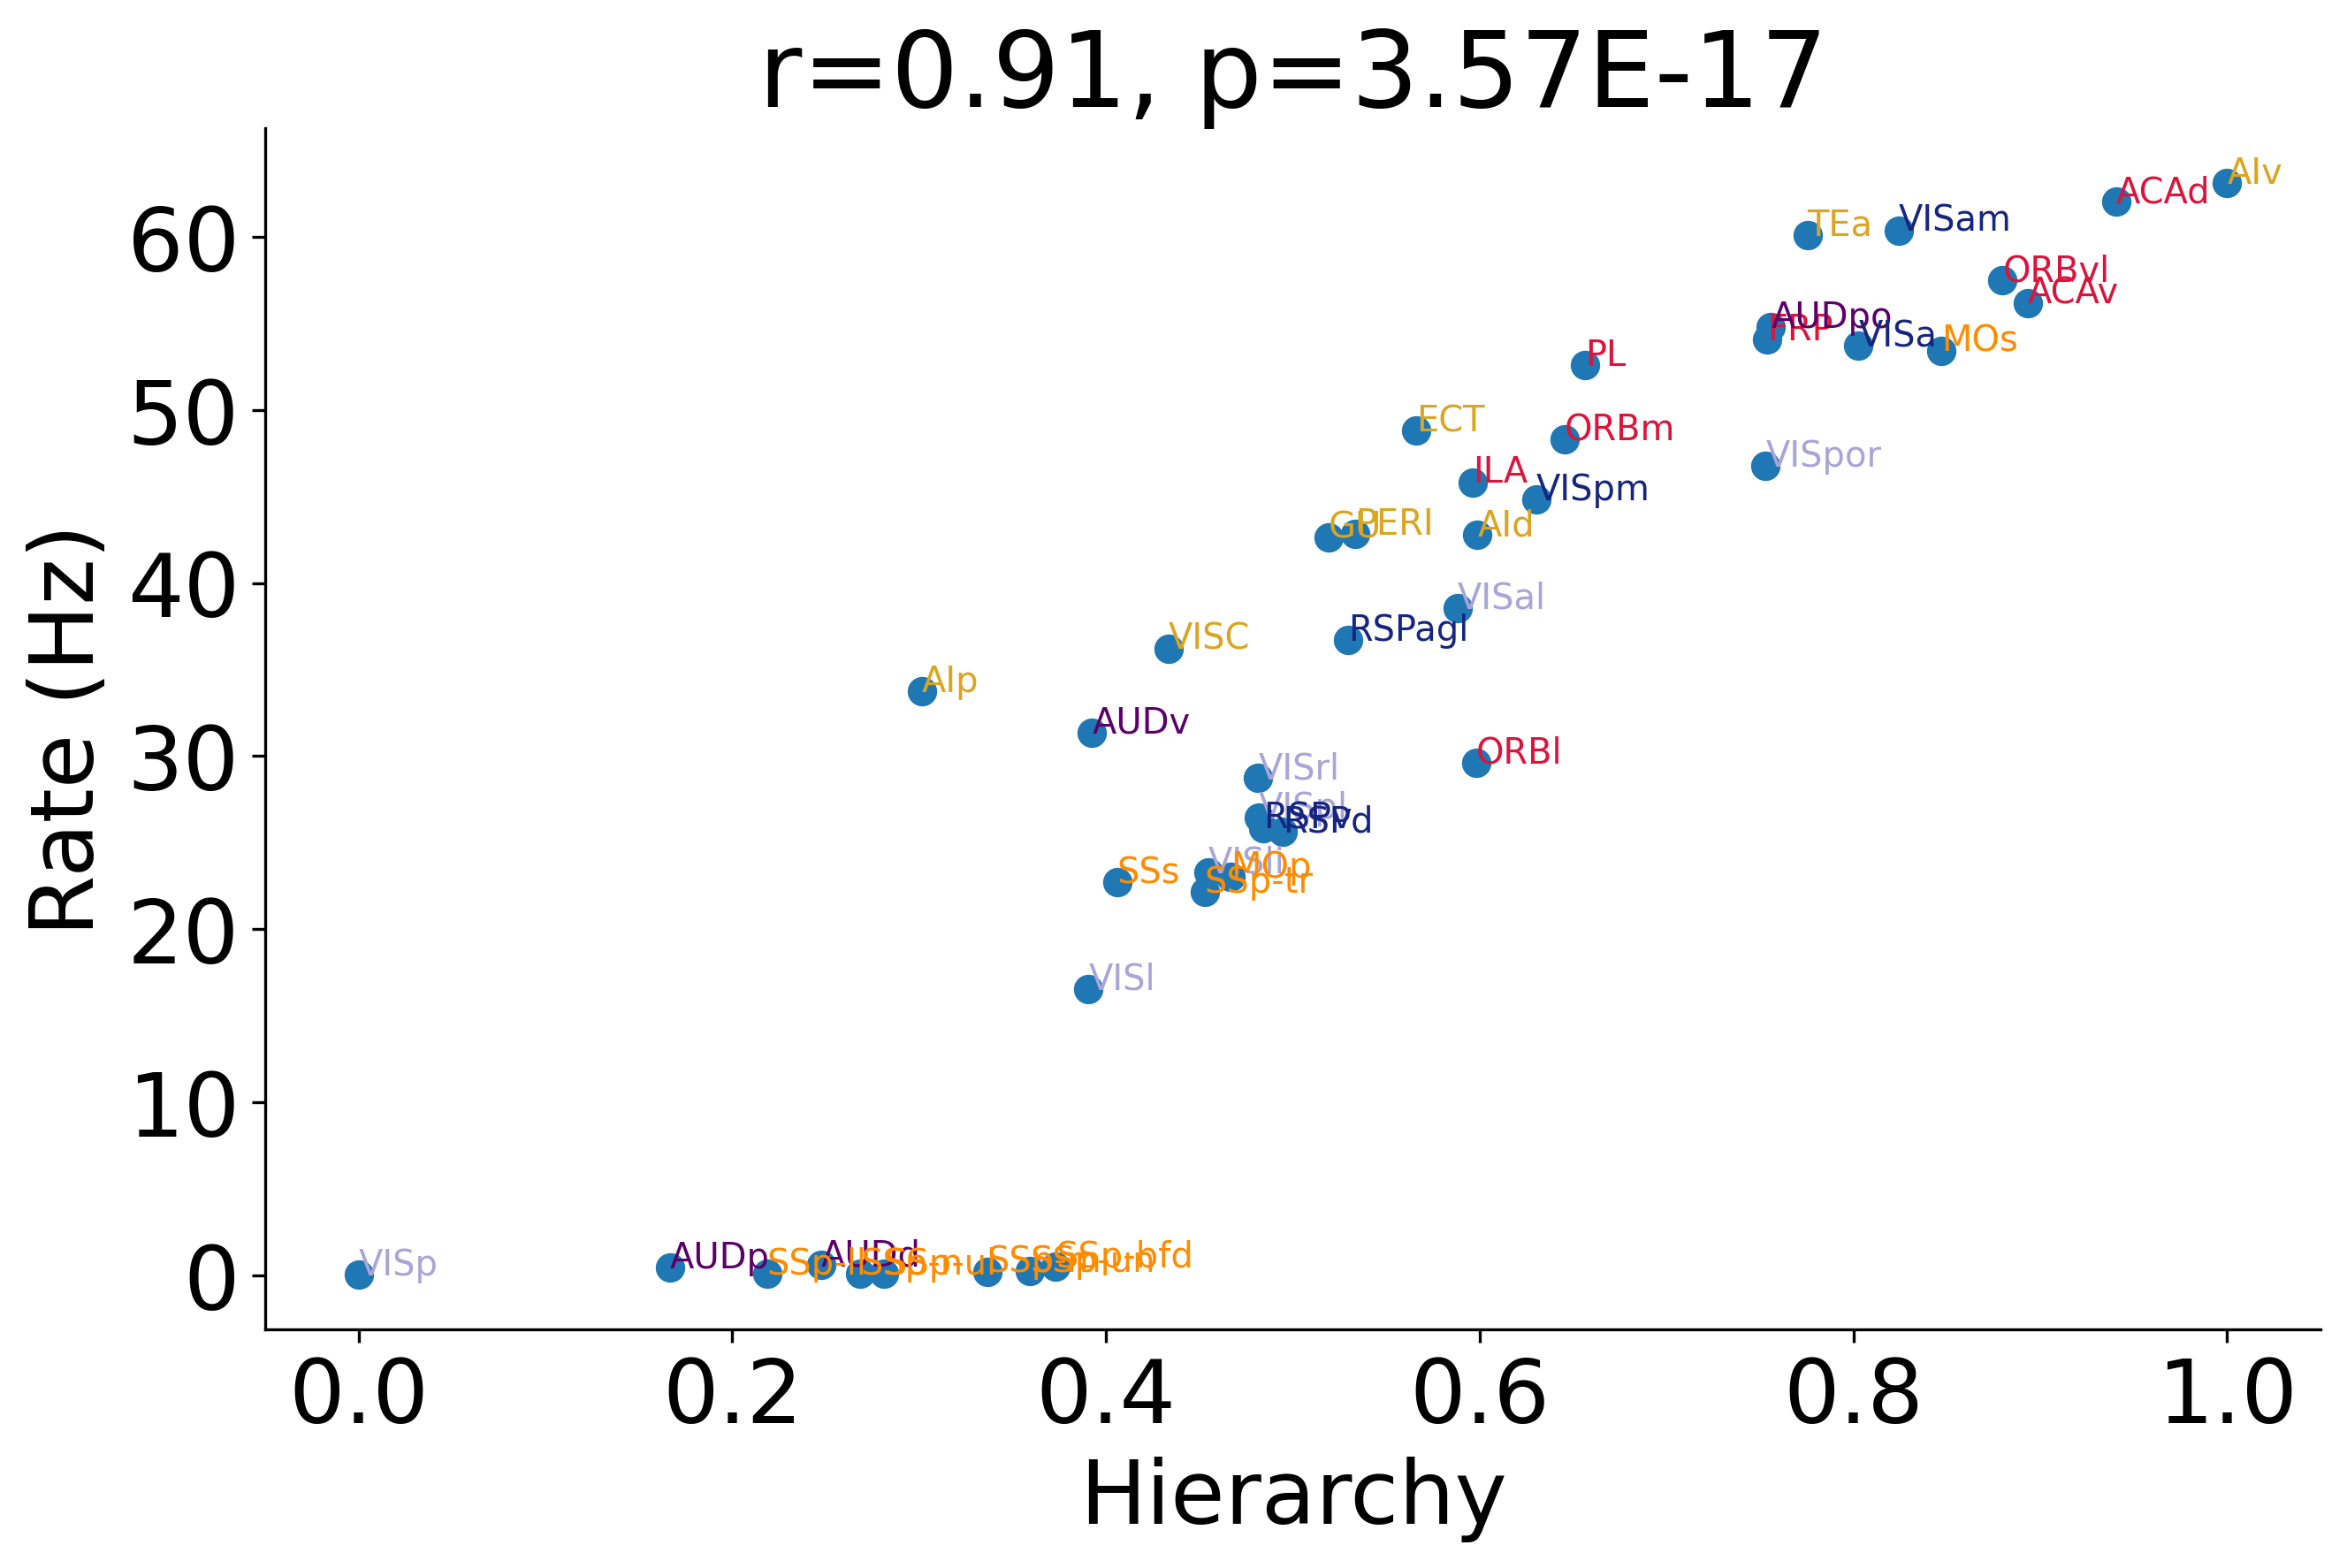

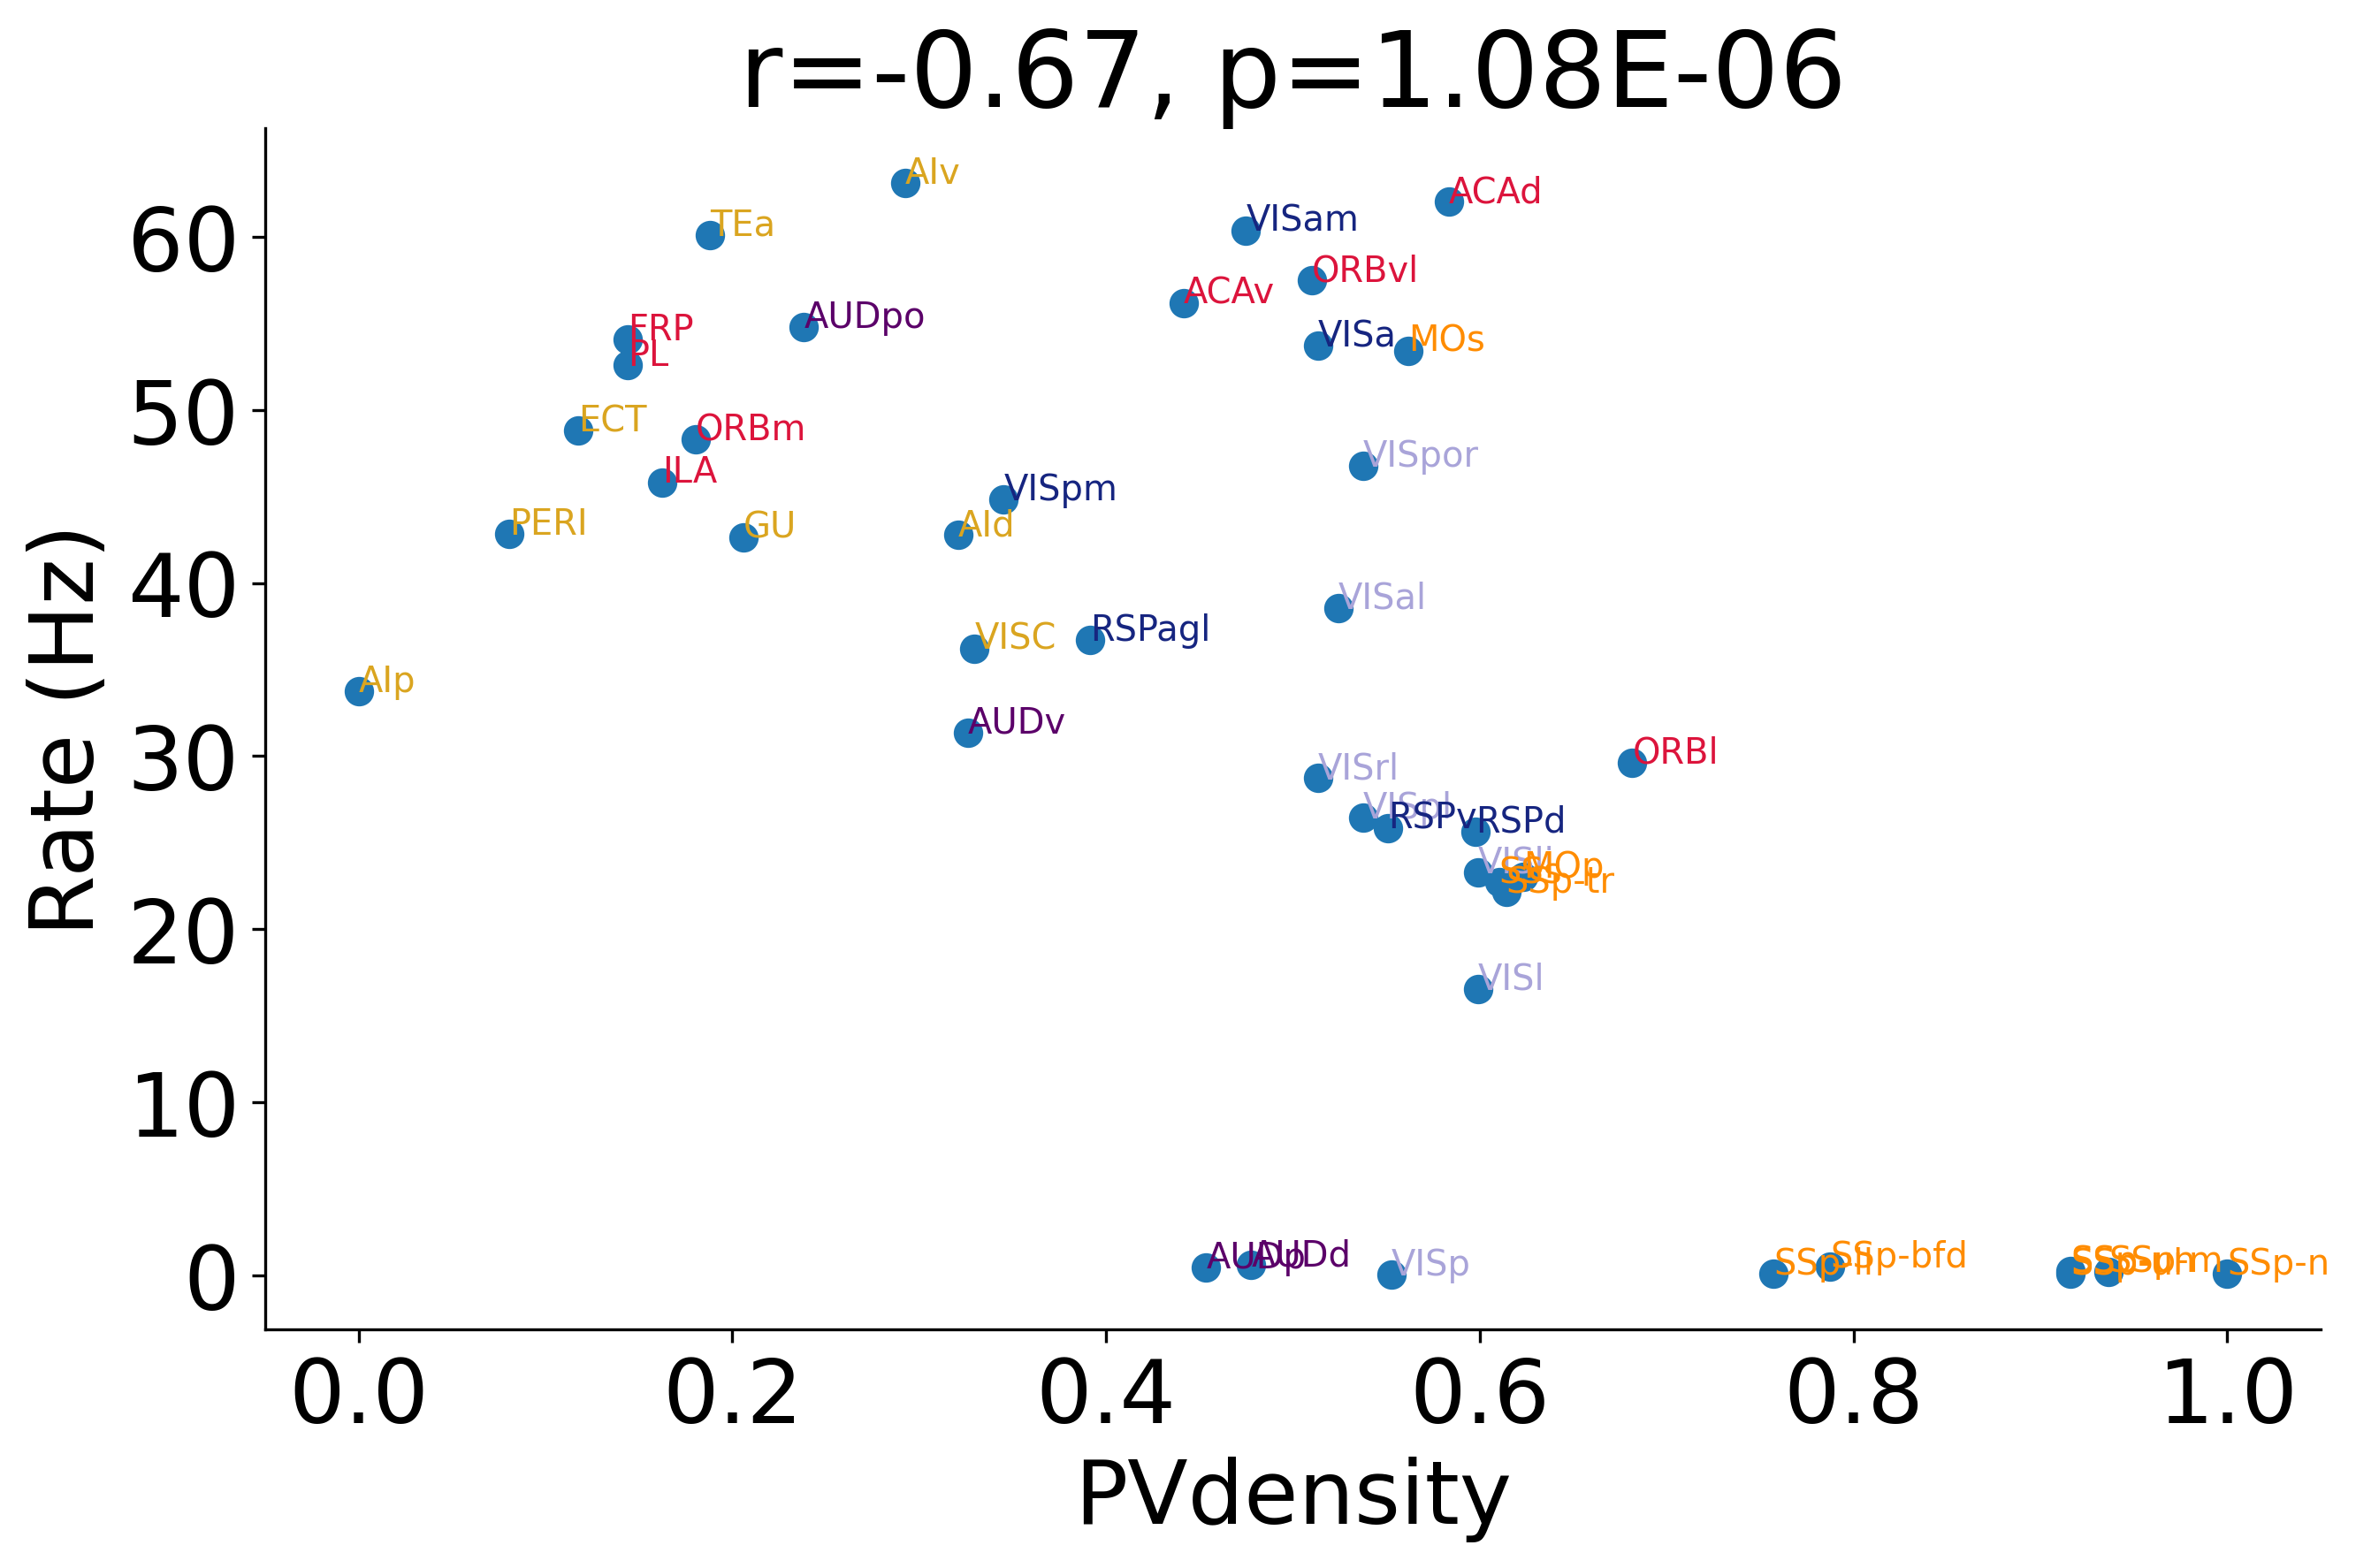

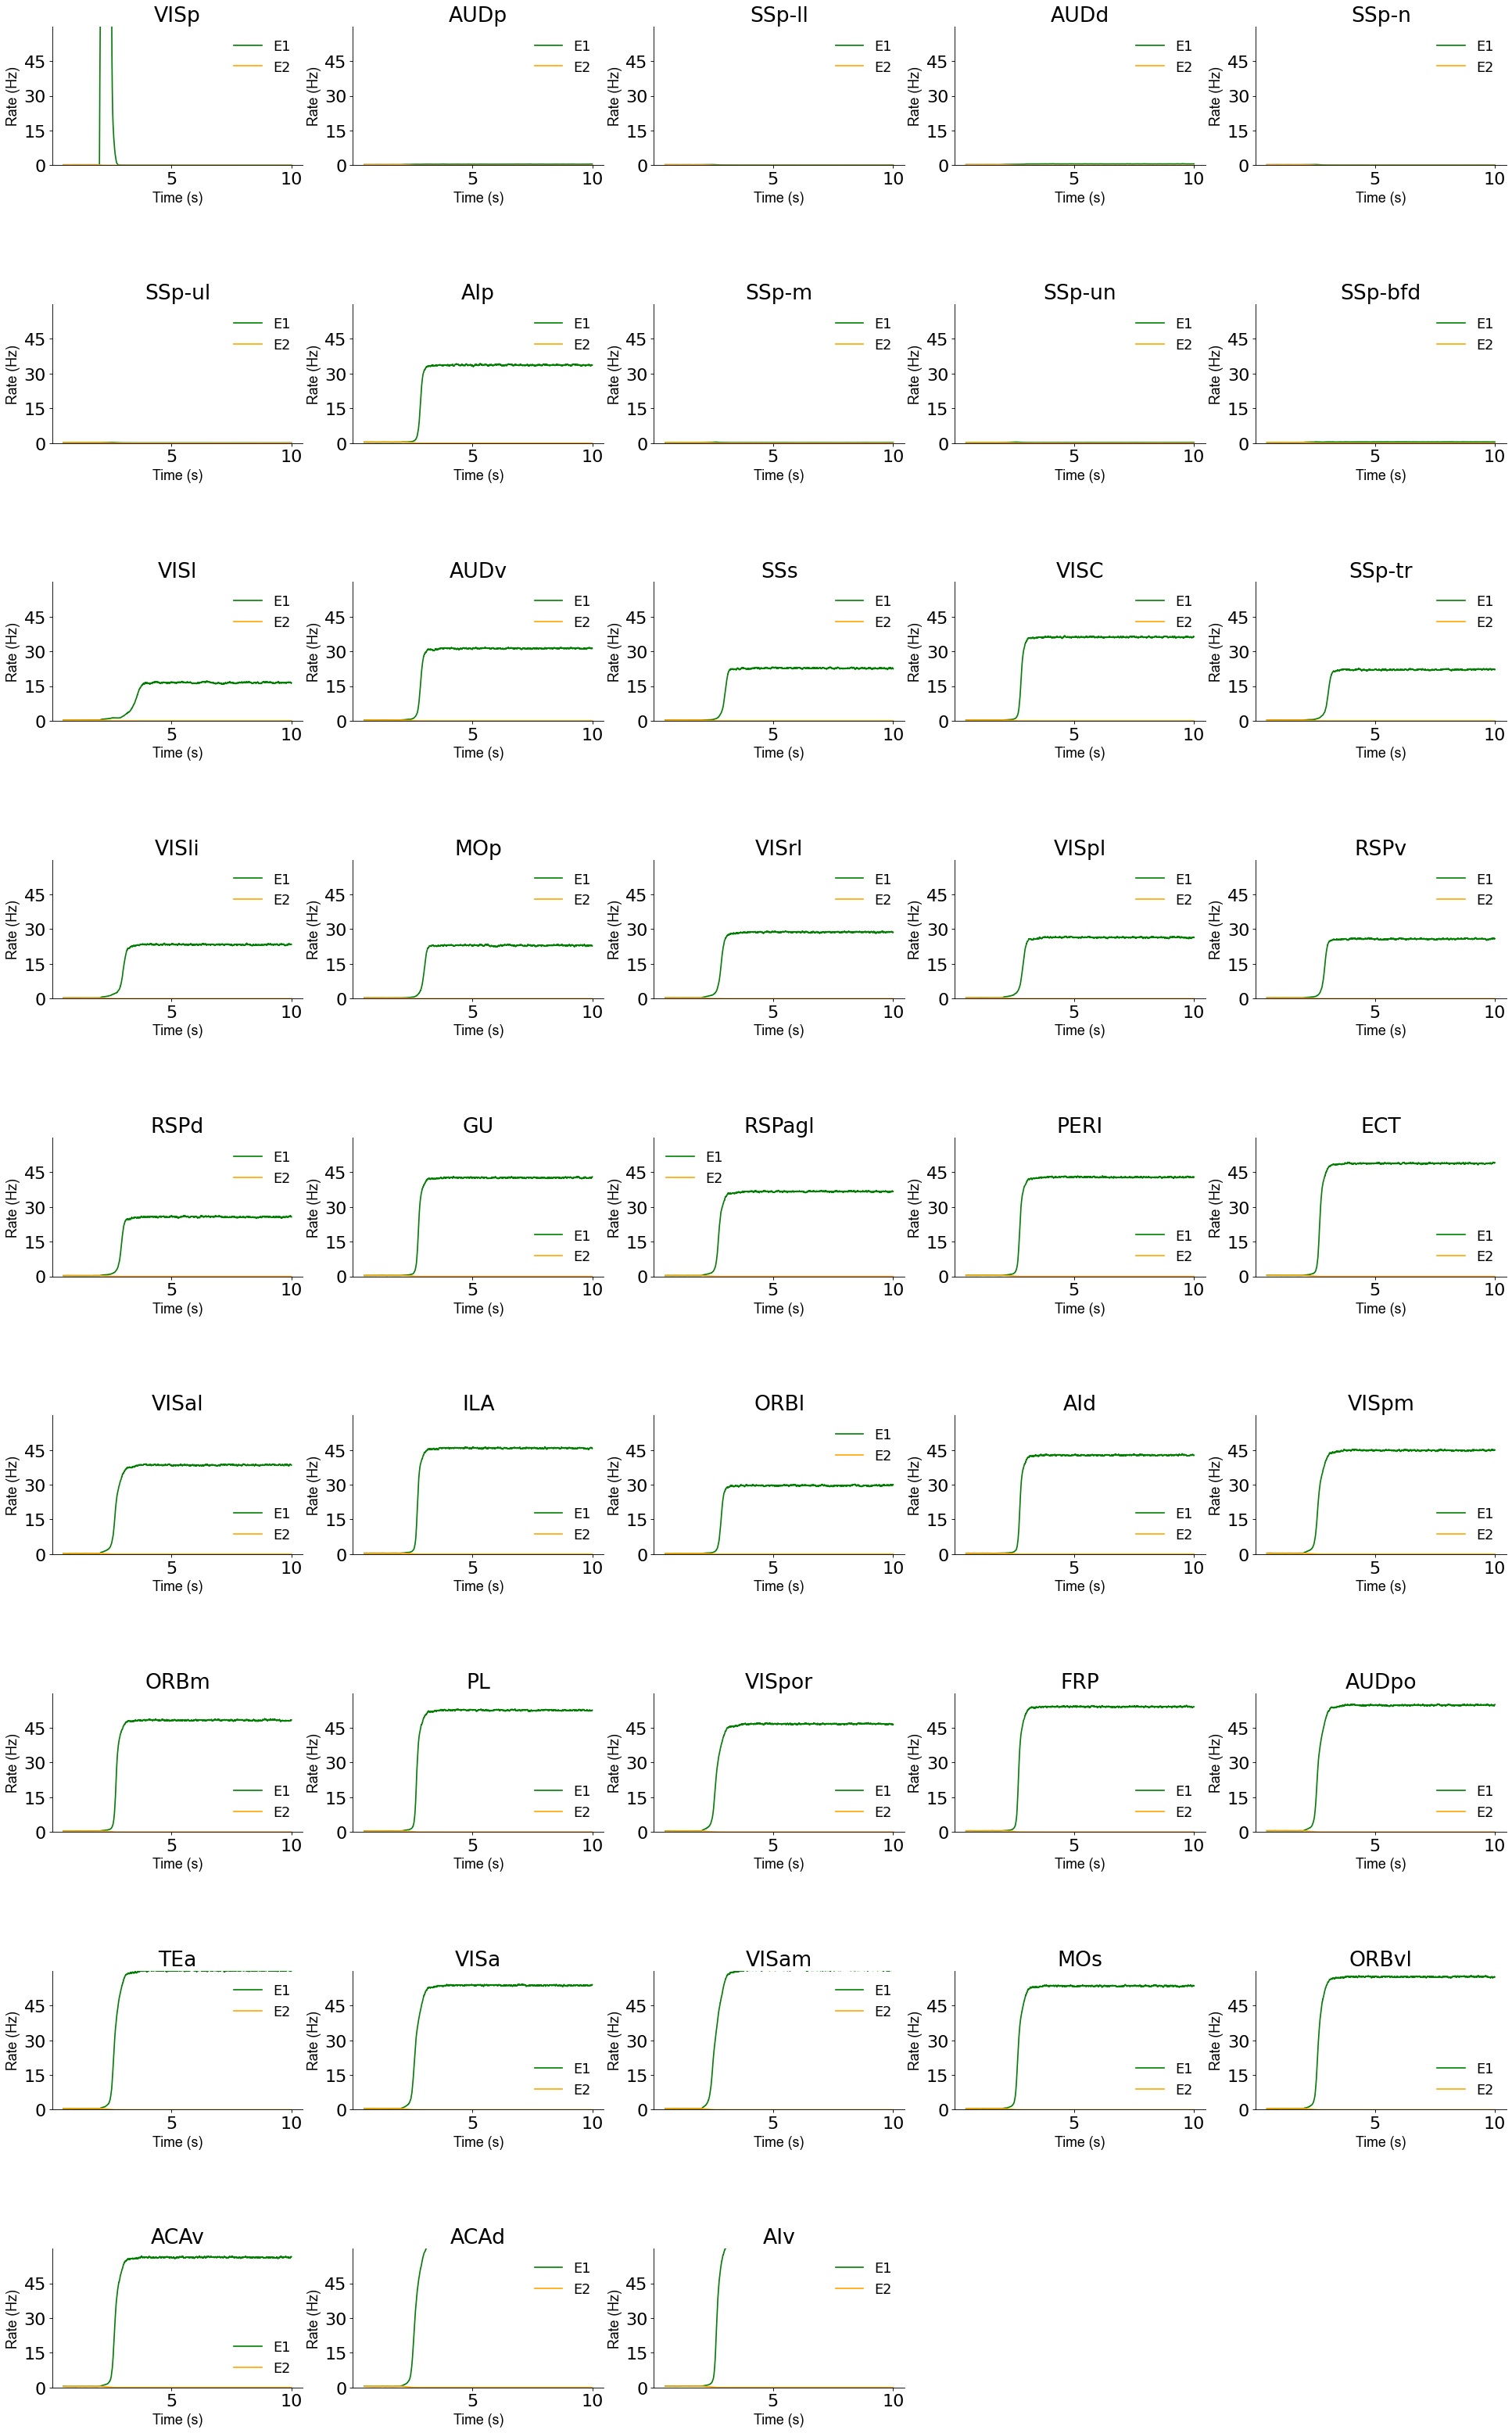

In [250]:
# plt.figure()
# a = np.power(conn_cxcx, parameters['kSquishFln'])
# plt.imshow(a / np.max(a))
# plt.colorbar()

# plt.figure()
# b = np.power(conn_cxcx, parameters['kSquishFln']) / model_V1.W_rowtotal_mat
# plt.imshow(b / np.max(b))
# plt.colorbar()

# plt.figure()
# plot_pref(pref_matrix, area_list)

[persistentactlist,baselineactlist,LRtoElist,LRtoIlist] = model_V1.save_delay_activity('tempdata/',False)
# generate firing rate distribution
preparatory_threshold = 10
PAthreshold = 5 #Hz
th_PAthreshold = 5 #Hz
persistentact_df =  model_V1.generatePAdf(PAthreshold)
if model_V1.thcxmodel == True:
    th_hierarchy = np.arange(0,1,1/40)
    th_persistentact_df = model_V1.generate_th_PAdf(th_PAthreshold, th_hierarchy)

model_V1.plotFRvsHier(False, True, 2, (10,6), 24, False, 'FRvsHier.pdf')
model_V1.plotFRvsPV(False, True, 2, (10,6), 24, False, 'FRvsPV.pdf')
model_V1.plotFRallarea(plot_interneuron = False, ylimit = 60, savefig = savefigflag, figfilename = 'FRallcortex.pdf')
if model_V1.thcxmodel == True:
    model_V1.plotFRthalarea(savefig = savefigflag, ylimit = 60, figfilename = 'FRallthalamus.pdf')
#     model_V1.plot_th_FRvshier(annotation_adjust = False)


In [251]:
persistentAreaList = []
for i in range(model_V1.n_areas):
    if model_V1.persistentact_df['persistentactBinary'][i]:
        persistentAreaList.append(model_V1.persistentact_df['Acronym'][i])

In [252]:
np.mean(model_V1.persistentact_df['persistentact'])

32.87037610364577

In [253]:
with open('results/model_V1_thal.pkl', 'wb') as f:
    pickle.dump(model_V1, f)

In [95]:
# vary thal and cortex connectivity. save the firing rate. 
gcxth = 0.0375*brian2.nA
gthcxlist = np.arange(0.00, 0.0501, 0.005) * brian2.nA  # 0.1 makes unstable baseline
connSum = 0.1 * brian2.nA
muEElist = connSum - gthcxlist
PAthreshold = 5 #Hz

preparatory_threshold = 5 #Hz

print(gthcxlist)
print(muEElist)
print(gcxth)

[ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50.] pA
[100.  95.  90.  85.  80.  75.  70.  65.  60.  55.  50.] pA
37.5 pA


In [55]:
# simulate using different params  # 20mins
for muEE in muEElist:
    for gthcx in gthcxlist:
        par = copy.copy(parameters)
        par['mu_EE'] = muEE
        par.update({'mu_IE': par['mu_EE']*par['ratio_mu_IE_mu_EE']})
        par['g_cx_th'] = gcxth

        par['g_th_cx_E_mean'] = gthcx
        par['g_th_cx_E_min'] = par['g_th_cx_E_mean']
        par['g_th_cx_E_max'] = par['g_th_cx_E_mean']

        par['g_th_cx_I_mean'] = gthcx * 0.5
        k_gth_I = par['g_th_cx_I_mean']
        par['g_th_cx_I_min'] = par['g_th_cx_I_mean'] - k_gth_I*0.5
        par['g_th_cx_I_max'] = par['g_th_cx_I_mean'] + k_gth_I*0.5



        model_vary = model(par, False, conn_cxcx, pref_matrix, hierarchy_df, normPVgrad_df, normSSTgrad_df, area_list, thcxmodel, conn_thcx, conn_cxth, thal_list)
        if thcxmodel:
            model_vary.add_input(parameters['stim_strength'], ['VISp'], parameters['stim_on'], parameters['stim_off'], 'E1')

        model_vary.run_sim(vocal_prompt = False)
        fileName = 'model_V1_thal_gcxth_' + str(gcxth)+ '_gthcx_' + str(gthcx) + '_muEE_' + str(muEE) + '.pkl'
        print(fileName)
        with open('results/new_gthcx_test/' + fileName, 'wb') as f:
            pickle.dump(model_vary, f)


VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_0. A_muEE_100. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_5. pA_muEE_100. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_10. pA_muEE_100. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_15. pA_muEE_100. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_20. pA_muEE_100. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_25. pA_muEE_100. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_30. pA_muEE_100. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_35. pA_muEE_100. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_40. pA_muEE_100. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_45. pA_muEE_100. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_50. pA_muEE_100

sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_10. pA_muEE_60. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_15. pA_muEE_60. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_20. pA_muEE_60. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_25. pA_muEE_60. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_30. pA_muEE_60. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_35. pA_muEE_60. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_40. pA_muEE_60. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_45. pA_muEE_60. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_50. pA_muEE_60. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_0. A_muEE_55. pA.pkl
VISp
simulation start: 
sim done.
model_V1_thal_gcxth_37.5 pA_gthcx_5. pA_muEE_55. pA.pkl
VISp
simulation start: 
si

In [47]:
# def analyzeVaringTHCX(gthcxlist, muEElist, dotSize, figureSize, fontSize, saveFig, fileName):
#     FRlist = []
#     muEEPlotList = []
#     gthcxPlotList = []
#     for muEE in muEElist:
#         for gthcx in gthcxlist:
#             loadFileName = 'model_V1_thal_gthcx_' + str(gthcx) + '_muEE_' + str(muEE) + '.pkl'
#             with open('results/new_gthcx_test/' + loadFileName, 'rb') as f:
#                 model_vary = pickle.load(f)
#             [persistentactlist, _, _, _] = model_vary.save_delay_activity('tempdata/',False)
#             persistentact_df =  model_vary.generatePAdf(PAthreshold)
#             meanFR = persistentact_df['persistentact'][persistentact_df['persistentact'] > PAthreshold].mean()
#             muEEPlotList.append(muEE)
#             gthcxPlotList.append(gthcx)
#             FRlist.append(meanFR)
    
# #     X = gthcxlist / (connSum - gthcxlist)
#     fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
#     plt.rcParams.update({'font.size':fontSize})
    
# #     plt.plot(X, FRlist)
# #     plt.scatter(X, FRlist, s = dotSize)
#     plt.scatter(muEEPlotList, gthcxPlotList, s = dotSize, c = FRlist)
#     plt.colorbar()

# #     plt.fill_between(X[4:], max(FRlist)*1.05, alpha= 0.3)

# #     plt.xlabel('Thalamocortical ratio')
# #     plt.ylabel('Average firing rate(Hz)')
# #     plt.ylim([0, 110])
#     ax = plt.gca()
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     if saveFig:
#         fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)

In [48]:
# with open('results/new_gthcx_test copy 150/' + loadFileName, 'rb') as f:
#     model_vary = pickle.load(f)
# [persistentactlist, _, _, _] = model_vary.save_delay_activity('tempdata/', False)
# persistentact_df =  model_vary.generatePAdf(PAthreshold)

# model_vary.plotFRvsHier(False, True, 0.5, (5,3), 12, False, 'FRvsHier.pdf')
# model_vary.plotFRallarea(plot_interneuron = True,ylimit = 50, savefig = savefigflag, figfilename = 'FRallcortex.pdf')
# print(gthcx)

In [31]:
### used to check the long range TC CC current to PL
muEE  =  muEElist[0]
gthcx  = gthcxlist[-1]
loadFileName = 'model_V1_thal_gthcx_' + str(gthcx) + '_muEE_' + str(muEE) + '.pkl'
with open('results/new_gthcx_test copy 100/' + loadFileName, 'rb') as f:
    model_vary = pickle.load(f)
[persistentactlist, _, _, _] = model_vary.save_delay_activity('tempdata/', False)
persistentact_df =  model_vary.generatePAdf(PAthreshold)
PAstarttime = model_vary.trial_length - 2 * brian2.second
PAendtime = model_vary.trial_length - 0.5 * brian2.second

preparatory_starttime = model_vary.stim_on - 1 * brian2.second
preparatory_endtime = model_vary.stim_on - 0.1 * brian2.second
preparatory_timePeriod = np.arange(int(preparatory_starttime / model_vary.dt), int(preparatory_endtime / model_vary.dt), 1)
if np.max(model_vary.R[preparatory_timePeriod, 3, :] / brian2.Hz) > preparatory_threshold:
    print('s')
timePeriod = np.arange(int(model_vary.stim_on / model_vary.dt), int(model_vary.trial_length / model_vary.dt), 1)
area_name = model_vary.persistentact_df['Acronym'][19]
target = 0.5 * model_vary.persistentact_df['persistentact'][19] * brian2.Hz
propagationTime = np.nonzero(model_vary.R[timePeriod, 19, 0] > target)[0][0] * model_vary.dt / brian2.second
# propagationTimeList.append(propagationTime)


# current1 = np.mean(model_vary.I_cx_th[np.arange(int(PAstarttime / model_vary.dt), int(PAendtime / model_vary.dt), 1), 23, 0]/ brian2.pA)
current10 = np.mean(model_vary.I_th_cx[np.arange(int(PAstarttime / model_vary.dt), int(PAendtime / model_vary.dt), 1), 19, 0]/ brian2.pA)
current11 = np.mean(model_vary.I_th_cx[np.arange(int(PAstarttime / model_vary.dt), int(PAendtime / model_vary.dt), 1), 19, 2]/ brian2.pA)
current12 = np.mean(model_vary.I_LR_NMDA[np.arange(int(PAstarttime / model_vary.dt), int(PAendtime / model_vary.dt), 1), 19, 0]/ brian2.pA)
current13 = np.mean(model_vary.I_LR_NMDA[np.arange(int(PAstarttime / model_vary.dt), int(PAendtime / model_vary.dt), 1), 19, 2]/ brian2.pA)

current20 = np.mean(model_vary.I_th_cx[np.arange(int(PAstarttime / model_vary.dt), int(PAendtime / model_vary.dt), 1), 35, 0]/ brian2.pA)
current21 = np.mean(model_vary.I_LR_NMDA[np.arange(int(PAstarttime / model_vary.dt), int(PAendtime / model_vary.dt), 1), 35, 0]/ brian2.pA)
current10, current11, current12, current13, current20, current21

model_vary.plotFRvsPV(False, True, 0.5, (5,3), 12, False, 'FRvsPV.pdf')
model_vary.plotFRallarea(plot_interneuron = False,ylimit = 50, savefig = savefigflag, figfilename = 'FRallcortex.pdf')
print(gthcx)

FileNotFoundError: [Errno 2] No such file or directory: 'results/new_gthcx_test copy 100/model_V1_thal_gthcx_50. pA_muEE_100. pA.pkl'

In [96]:
def analyze_muEE_gthcx(gcxth, gthcxlist, muEElist, fileFolder):
    frList = []
    countList = []
    propagationTimeList = []
    ILRtotalEList = []
    ILRtotalIList = []
    
    muEEPlotList = []
    gthcxPlotList = []
    for muEE in muEElist:
        for gthcx in gthcxlist:

            loadFileName = 'model_V1_thal_gcxth_' + str(gcxth)+ '_gthcx_' + str(gthcx) + '_muEE_' + str(muEE) + '.pkl'
            with open(fileFolder + loadFileName, 'rb') as f:
                model_vary = pickle.load(f)
            [persistentactlist, _, _, _] = model_vary.save_delay_activity('tempdata/', False)
            persistentact_df =  model_vary.generatePAdf(PAthreshold)
            
            # check stable baseline:
            
            preparatory_starttime = model_vary.stim_on - 1 * brian2.second
            preparatory_endtime = model_vary.stim_on - 0.1 * brian2.second
            preparatory_timePeriod = np.arange(int(preparatory_starttime / model_vary.dt), int(preparatory_endtime / model_vary.dt), 1)
            if np.max(model_vary.R[preparatory_timePeriod, 4, 0:2] / brian2.Hz) > preparatory_threshold: # area AIv
                meanFR, count, propagationTime = 0, 0, 0
                IthcxE, IcxcxE, IthcxI, IcxcxI = 0, 0, 0, 0
                
            else:
                meanFR = persistentact_df['persistentact'][persistentact_df['persistentact'] > PAthreshold].mean()
                count = sum(persistentact_df['persistentactBinary'])
                
                timePeriod = np.arange(int(model_vary.stim_on / model_vary.dt), int(model_vary.trial_length / model_vary.dt), 1)
                area_name = model_vary.persistentact_df['Acronym'][15] # area PL
                target = 0.5 * model_vary.persistentact_df['persistentact'][15] * brian2.Hz # area PL
                propagationTime = np.nonzero(model_vary.R[timePeriod, 15, 0] > target)[0][0] * model_vary.dt / brian2.second


                PAstarttime = model_vary.trial_length - 2 * brian2.second
                PAendtime = model_vary.trial_length - 0.5 * brian2.second
                IthcxE = np.mean(model_vary.I_th_cx[np.arange(int(PAstarttime / model_vary.dt), int(PAendtime / model_vary.dt), 1), 19, 0]/ brian2.pA)  # area PL
                IthcxI = np.mean(model_vary.I_th_cx[np.arange(int(PAstarttime / model_vary.dt), int(PAendtime / model_vary.dt), 1), 19, 2]/ brian2.pA)
                IcxcxE = np.mean(model_vary.I_LR_NMDA[np.arange(int(PAstarttime / model_vary.dt), int(PAendtime / model_vary.dt), 1), 19, 0]/ brian2.pA)
                IcxcxI = np.mean(model_vary.I_LR_NMDA[np.arange(int(PAstarttime / model_vary.dt), int(PAendtime / model_vary.dt), 1), 19, 2]/ brian2.pA)
            
            muEEPlotList.append(muEE / brian2.pA)
            gthcxPlotList.append(gthcx / brian2.pA)
            frList.append(meanFR)
            countList.append(count)
            propagationTimeList.append(propagationTime)
            ILRtotalEList.append(IthcxE + IcxcxE)
            ILRtotalIList.append(IthcxI + IcxcxI)
            
    return muEEPlotList, gthcxPlotList, frList, countList, propagationTimeList, ILRtotalEList, ILRtotalIList


In [97]:
preparatory_threshold = 5

muEEPlotList, gthcxPlotList, frList, countList,propagationTimeList, ILRtotalEList, ILRtotalIList = \
    analyze_muEE_gthcx(gcxth, gthcxlist, muEElist, 'results/new_gthcx_test/')

In [98]:
def plotStat_muEE_gthcx(muEEPlotList, gthcxPlotList, statsList, statsName, figureSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size':fontSize})
#     pd.set_option('display.max_rows', None)
    df = pd.DataFrame([  [x, y, z] for x, y, z in zip(muEEPlotList, gthcxPlotList, statsList)], columns=['muEE', 'gthcx', statsName])
    df0 = df.fillna(0)
    dfTable = df0.pivot('gthcx', 'muEE', statsName)[::-1]
#     print(dfTable)
    plt.imshow(dfTable)
    cbar = plt.colorbar()
    plt.title(statsName)
#     cbar.set_label(statsName, rotation=270)
    plt.xlabel('corticocortical strength(pA)')
    plt.ylabel('thalamocortical strength(pA)')

    plt.xticks(range(len(muEElist)), [int(x) for x in muEElist / brian2.pA][::-1], size=fontSize*0.6)
    plt.yticks(range(len(gthcxlist)), [int(x) for x in gthcxlist / brian2.pA][::-1], size=fontSize*0.6)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)

In [99]:
plotStat_muEE_gthcx(muEEPlotList, gthcxPlotList, ILRtotalEList, 'total LR current to E',
                    (5,3), 12, False, 'ILRE_thcx_muEE.pdf')
plotStat_muEE_gthcx(muEEPlotList, gthcxPlotList, ILRtotalIList, 'total LR current to I',
                    (5,3), 12, False, 'ILRI_thcx_muEE.pdf')

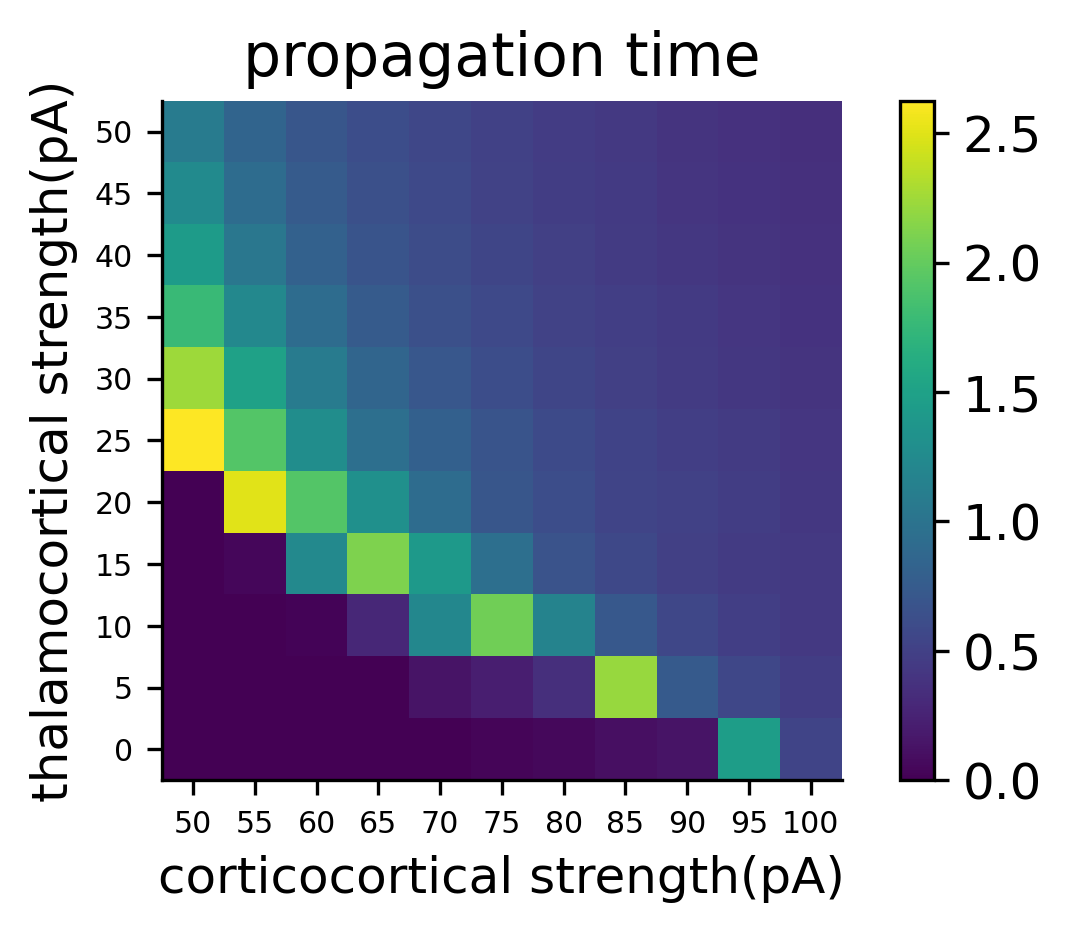

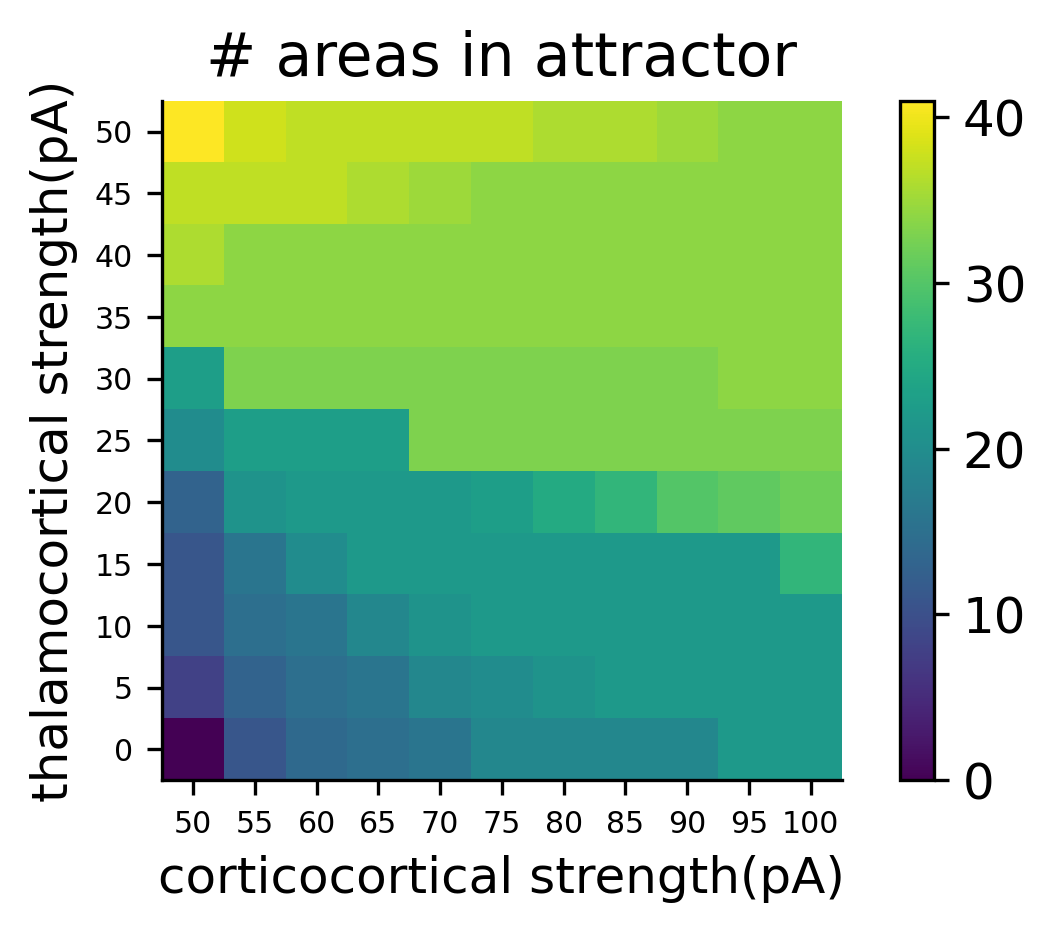

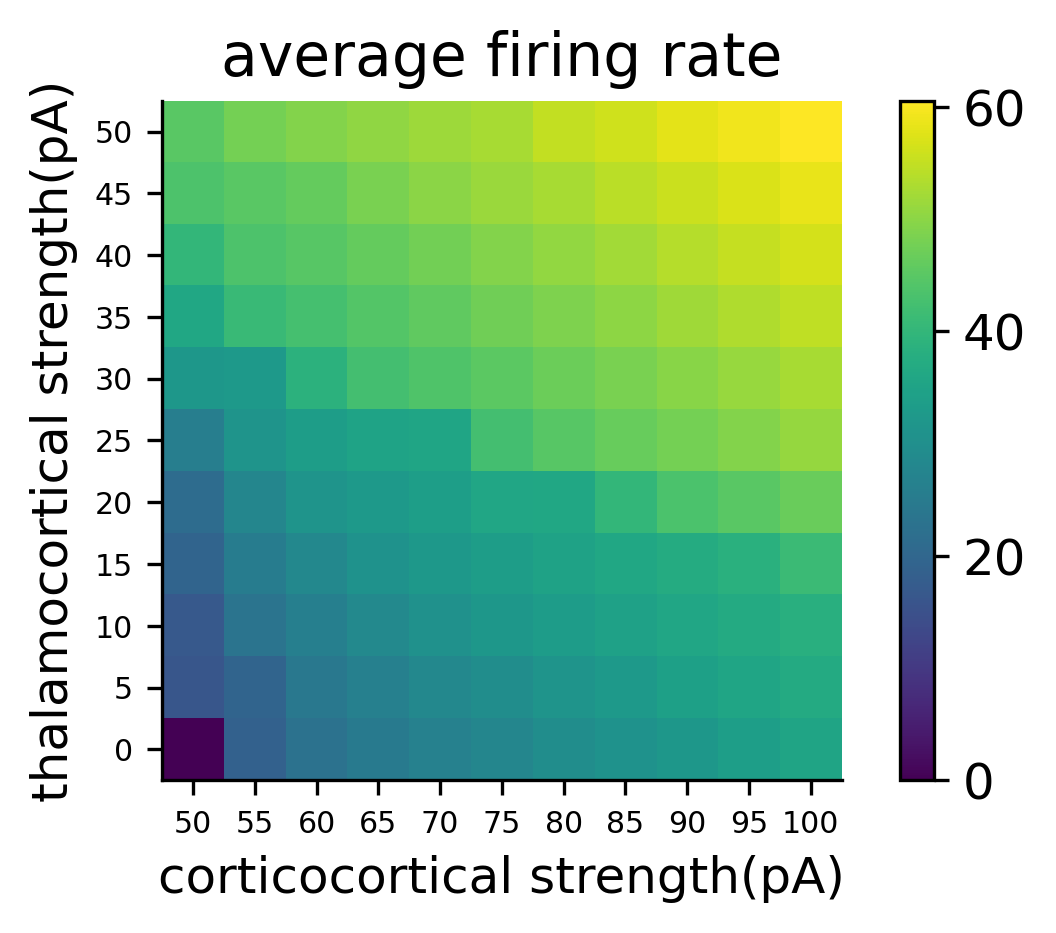

In [100]:
plotStat_muEE_gthcx(muEEPlotList, gthcxPlotList, propagationTimeList, 'propagation time',
                    (5,3), 12, False, 'propTime_thcx_muEE.pdf') 
plotStat_muEE_gthcx(muEEPlotList, gthcxPlotList, countList, '# areas in attractor',
                    (5,3), 12, False, 'count_thcx_muEE.pdf') 
plotStat_muEE_gthcx(muEEPlotList, gthcxPlotList, frList, 'average firing rate',
                    (5,3), 12, False, 'fr_thcx_muEE.pdf') 

muEE   50.0   55.0   60.0   65.0   70.0   75.0   80.0    85.0    90.0   \
gthcx                                                                    
50.0     0.0    0.0    0.0    0.0    0.0    0.0  1.183  0.8800  0.7460   
45.0     0.0    0.0    0.0    0.0    0.0    0.0  1.419  0.9290  0.7475   
40.0     0.0    0.0    0.0    0.0    0.0    0.0  1.559  0.9780  0.8130   
35.0     0.0    0.0    0.0    0.0    0.0    0.0  0.000  1.0190  0.8360   
30.0     0.0    0.0    0.0    0.0    0.0    0.0  0.000  1.1840  0.8470   
25.0     0.0    0.0    0.0    0.0    0.0    0.0  0.000  1.2165  0.8680   
20.0     0.0    0.0    0.0    0.0    0.0    0.0  0.000  1.3480  0.9195   
15.0     0.0    0.0    0.0    0.0    0.0    0.0  0.000  1.6490  0.9335   
10.0     0.0    0.0    0.0    0.0    0.0    0.0  0.000  0.0000  0.9850   
5.0      0.0    0.0    0.0    0.0    0.0    0.0  0.000  0.0000  1.0660   
0.0      0.0    0.0    0.0    0.0    0.0    0.0  0.000  0.0000  1.2185   

muEE    95.0    100.0  
gthcx        

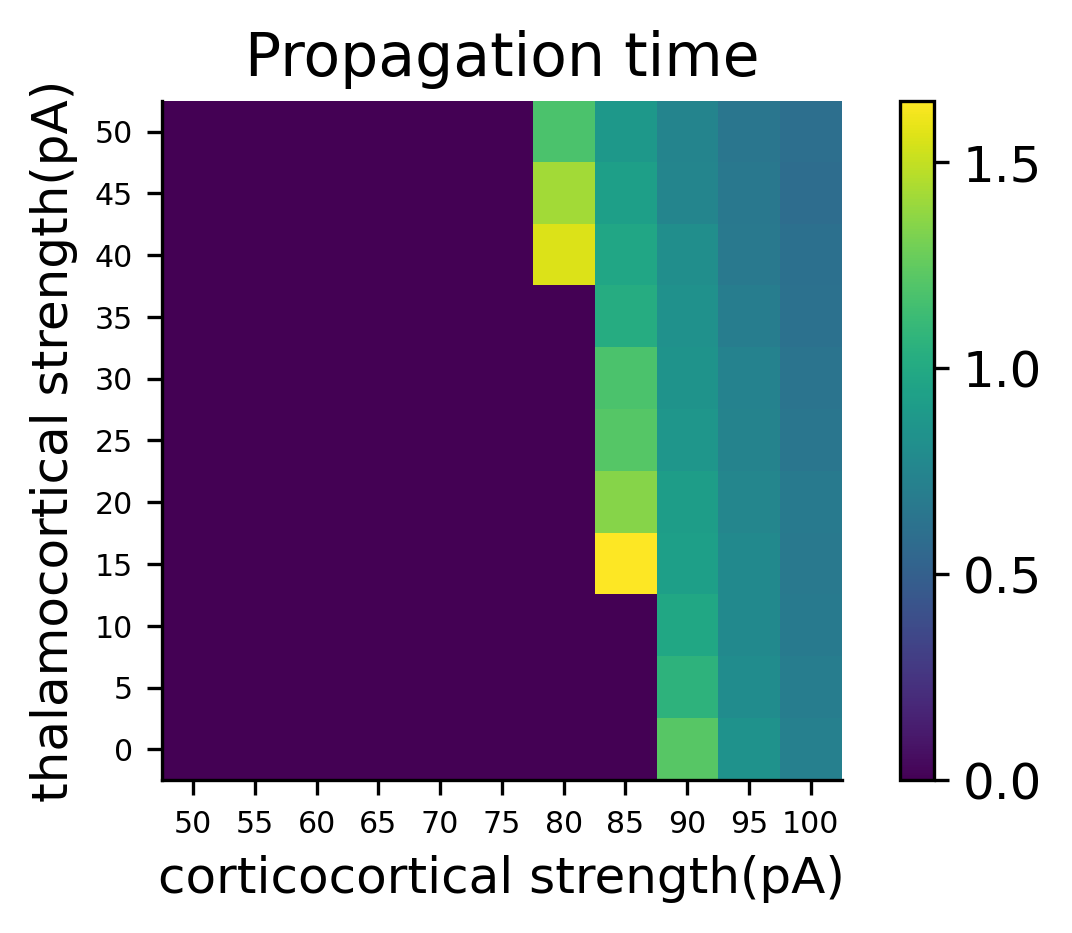

In [304]:
def plotPropTime_muEE_gthcx(muEEPlotList, gthcxPlotList, propagationTimeList, figureSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size':fontSize})
#     pd.set_option('display.max_rows', None)
    df = pd.DataFrame([  [x, y, z] for x, y, z in zip(muEEPlotList, gthcxPlotList, propagationTimeList)], columns=['muEE', 'gthcx', 'propTime'])
    df0 = df.fillna(0)
    dfTable = df0.pivot('gthcx', 'muEE', 'propTime')[::-1]
    print(dfTable)
    plt.imshow(dfTable)
    cbar = plt.colorbar()
    plt.title('Propagation time')
#     cbar.set_label('# areas in attractor', rotation=270)
    plt.xlabel('corticocortical strength(pA)')
    plt.ylabel('thalamocortical strength(pA)')

    plt.xticks(range(len(muEElist)), [int(x) for x in muEElist / brian2.pA][::-1], size=fontSize*0.6)
    plt.yticks(range(len(gthcxlist)), [int(x) for x in gthcxlist / brian2.pA][::-1], size=fontSize*0.6)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)
plotPropTime_muEE_gthcx(muEEPlotList, gthcxPlotList, propagationTimeList, (5,3), 12, False, 'propTime_thcx_muEE.pdf')

muEE   50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0   90.0   95.0   \
gthcx                                                                         
50.0       0      0      0      0      0      0     35     35     34     34   
45.0       0      0      0      0      0      0     33     32     32     32   
40.0       0      0      0      0      0      0     31     31     31     31   
35.0       0      0      0      0      0      0      0     31     31     31   
30.0       0      0      0      0      0      0      0     31     31     31   
25.0       0      0      0      0      0      0      0     30     30     31   
20.0       0      0      0      0      0      0      0     28     29     30   
15.0       0      0      0      0      0      0      0     23     26     28   
10.0       0      0      0      0      0      0      0      0     23     23   
5.0        0      0      0      0      0      0      0      0     21     22   
0.0        0      0      0      0      0      0     

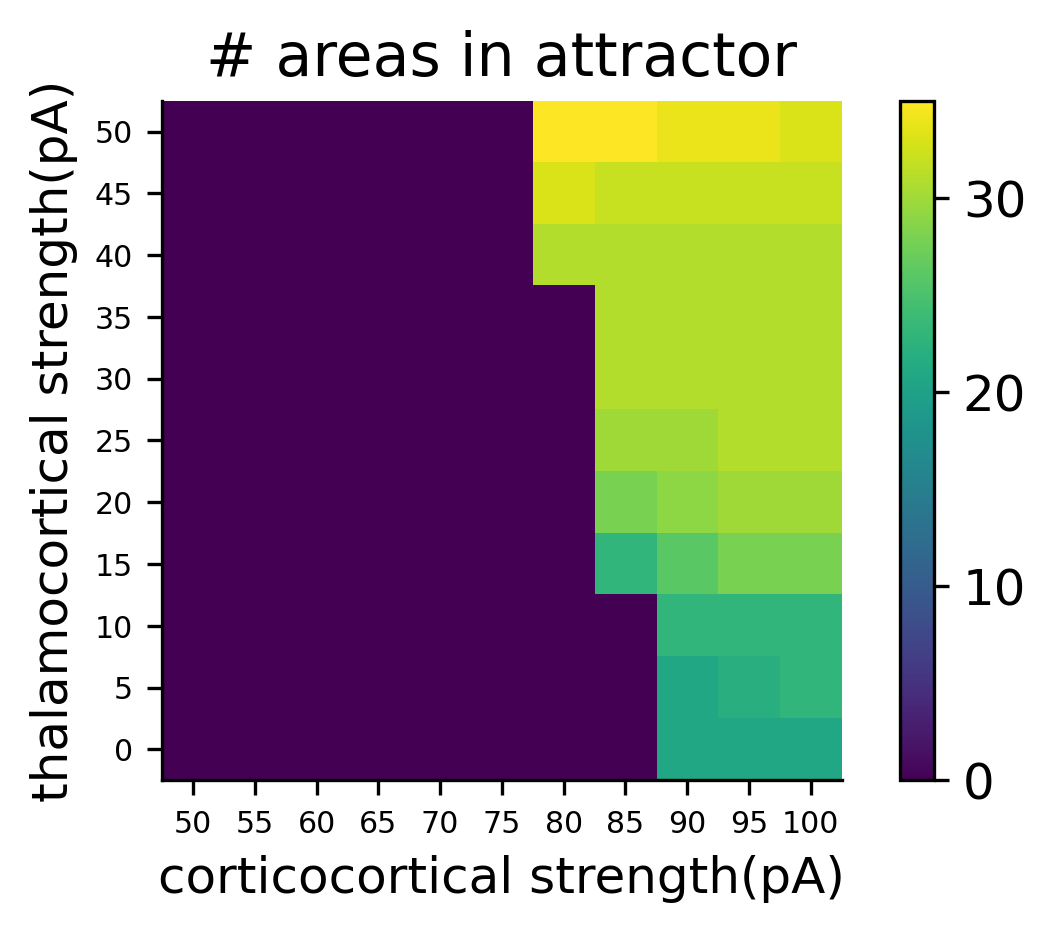

In [305]:
def plotCount_muEE_gthcx(muEEPlotList, gthcxPlotList, countList, figureSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size':fontSize})
#     pd.set_option('display.max_rows', None)
    df = pd.DataFrame([  [x, y, z] for x, y, z in zip(muEEPlotList, gthcxPlotList, countList)], columns=['muEE', 'gthcx', 'count'])
    df0 = df.fillna(0)
    dfTable = df0.pivot('gthcx', 'muEE', 'count')[::-1]
    print(dfTable)
    plt.imshow(dfTable)
    cbar = plt.colorbar()
    plt.title('# areas in attractor')
#     cbar.set_label('# areas in attractor', rotation=270)
    plt.xlabel('corticocortical strength(pA)')
    plt.ylabel('thalamocortical strength(pA)')

    plt.xticks(range(len(muEElist)), [int(x) for x in muEElist / brian2.pA][::-1], size=fontSize*0.6)
    plt.yticks(range(len(gthcxlist)), [int(x) for x in gthcxlist / brian2.pA][::-1], size=fontSize*0.6)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)
plotCount_muEE_gthcx(muEEPlotList, gthcxPlotList, countList, (5,3), 12, False, 'count_thcx_muEE.pdf')

In [148]:
def plotFR_muEE_gthcx(muEEPlotList, gthcxPlotList, frList, figureSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size':fontSize})

    df = pd.DataFrame([  [x, y, z] for x, y, z in zip(muEEPlotList, gthcxPlotList, frList)], columns=['muEE', 'gthcx', 'FR'])
    df0 = df.fillna(0)
    dfTable = df0.pivot('gthcx', 'muEE', 'FR')[::-1]
    print(dfTable)
    plt.imshow(dfTable)
    plt.colorbar()
    plt.xlabel('corticocortical strength')
    plt.ylabel('thalamocortical strength')

    plt.xticks(range(len(muEElist)), [int(x) for x in muEElist / brian2.pA][::-1], size=fontSize*0.6)
    plt.yticks(range(len(gthcxlist)), [int(x) for x in gthcxlist / brian2.pA][::-1], size=fontSize*0.6)

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)
plotFR_muEE_gthcx(muEEPlotList, gthcxPlotList, frList, (5,3), 12, False, 'FRvaringTHCXmuEE.pdf')        

muEE   50.0   55.0   60.0   65.0       70.0       75.0       80.0       85.0   \
gthcx                                                                           
50.0     0.0    0.0    0.0    0.0  54.923918  56.891839  57.684767  58.532120   
45.0     0.0    0.0    0.0    0.0   0.000000  52.612816  53.419578  54.117598   
40.0     0.0    0.0    0.0    0.0   0.000000  49.059523  49.840852  50.596071   
35.0     0.0    0.0    0.0    0.0   0.000000  43.727379  44.402697  49.366777   
30.0     0.0    0.0    0.0    0.0   0.000000   0.000000  44.985906  45.948069   
25.0     0.0    0.0    0.0    0.0   0.000000   0.000000  43.494985  44.829012   
20.0     0.0    0.0    0.0    0.0   0.000000   0.000000  37.783715  40.815249   
15.0     0.0    0.0    0.0    0.0   0.000000   0.000000   0.000000  37.354684   
10.0     0.0    0.0    0.0    0.0   0.000000   0.000000   0.000000  35.862263   
5.0      0.0    0.0    0.0    0.0   0.000000   0.000000   0.000000  11.009854   
0.0      0.0    0.0    0.0  

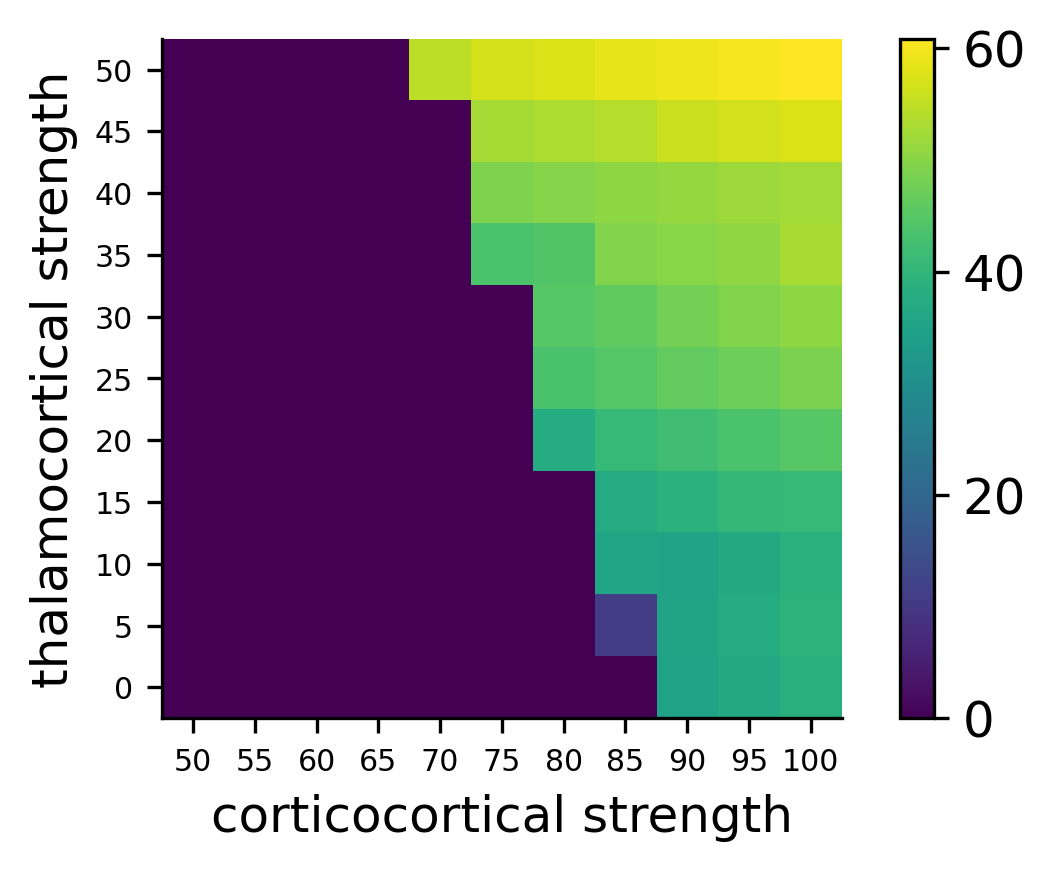

In [150]:
plotFRvaryingMuEEgthcx((5,3), 5, 12, False, 'FRvaringTHCXmuEE.pdf')

muEE   50.0   55.0   60.0   65.0   70.0   75.0       80.0       85.0   \
gthcx                                                                   
50.0     0.0    0.0    0.0    0.0    0.0    0.0  45.335936  46.204209   
45.0     0.0    0.0    0.0    0.0    0.0    0.0  44.007392  46.398454   
40.0     0.0    0.0    0.0    0.0    0.0    0.0  43.379867  44.698818   
35.0     0.0    0.0    0.0    0.0    0.0    0.0   0.000000  42.124810   
30.0     0.0    0.0    0.0    0.0    0.0    0.0   0.000000  39.629219   
25.0     0.0    0.0    0.0    0.0    0.0    0.0   0.000000  37.739692   
20.0     0.0    0.0    0.0    0.0    0.0    0.0   0.000000  35.858653   
15.0     0.0    0.0    0.0    0.0    0.0    0.0   0.000000  37.271016   
10.0     0.0    0.0    0.0    0.0    0.0    0.0   0.000000   0.000000   
5.0      0.0    0.0    0.0    0.0    0.0    0.0   0.000000   0.000000   
0.0      0.0    0.0    0.0    0.0    0.0    0.0   0.000000   0.000000   

muEE       90.0       95.0       100.0  
gthcx    

In [151]:
def analyzeVaringTHCX(gthcxlist, connSum, dotSize, figureSize, fontSize, saveFig, fileName):
    frList = []
    for gthcx in gthcxlist:
        with open('results/new_gthcx_test/model_V1_thal_gthcx_' + str(gthcx) + '.pkl', 'rb') as f:
            model_vary = pickle.load(f)
        [persistentactlist, _, _, _] = model_vary.save_delay_activity('tempdata/',False)
        persistentact_df =  model_vary.generatePAdf(PAthreshold)
        meanFR = persistentact_df['persistentact'][persistentact_df['persistentact'] > PAthreshold].mean()
        frList.append(meanFR)
    
    X = gthcxlist / (connSum - gthcxlist)
    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size':fontSize})
    plt.plot(X, frList)
    plt.scatter(X, frList, s = dotSize)
#     plt.fill_between(X[4:], max(frList)*1.05, alpha= 0.3)
    plt.xlabel('Thalamocortical ratio')
    plt.ylabel('Average firing rate(Hz)')
    plt.ylim([0, 110])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)

In [105]:
analyzeVaringTHCX(gthcxlist, muEElist, 5, (5,3), 12, True, 'varingTHCX.pdf')

WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/brian2/units/fundamentalunits.py:1386: RuntimeWarning: divide by zero encountered in true_divide
  result = operation(self_arr, other_arr)
 [py.warnings]


In [138]:
def analyzeCountTHCX(gthcxlist, connSum, dotSize, figureSize, fontSize, saveFig, fileName):
    countList = []
    for gthcx in gthcxlist:
        with open('results/new_gthcx_test/model_V1_thal_gthcx_' + str(gthcx) + '.pkl', 'rb') as f:
            model_vary = pickle.load(f)
        [persistentactlist, _, _, _] = model_vary.save_delay_activity('tempdata/',False)
        persistentact_df =  model_vary.generatePAdf(PAthreshold)
        count = sum(persistentact_df['persistentactBinary'])
        countList.append(count)
    
    X = gthcxlist / (connSum - gthcxlist)
    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size':fontSize})
    plt.plot(X, countList)
    plt.scatter(X, countList, s = dotSize)
#     plt.fill_between(X[4:], max(countList)*1.05, alpha= 0.3)
    plt.xlabel('Thalamocortical ratio')
    plt.ylabel('# areas in attractor')
    plt.ylim([0, 45])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)

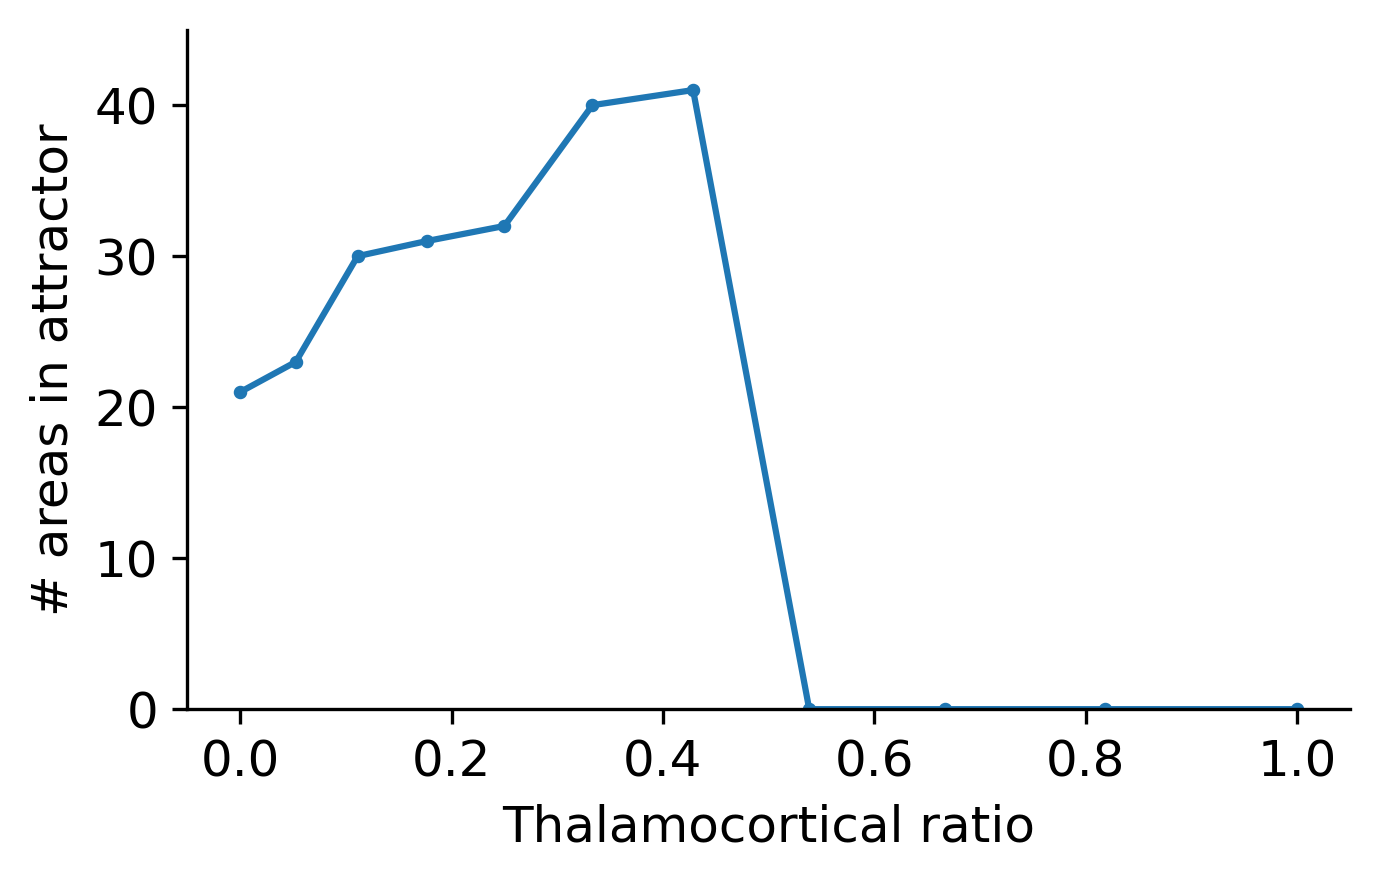

In [139]:
analyzeCountTHCX(gthcxlist, connSum, 5, (5,3), 12, True, 'countTHCX.pdf')

In [140]:
def analyzeRampTimeVaringTHCX(gthcxlist, percentage, connSum, dotSize, figureSize, fontSize, saveFig, fileName):
    meanRampTimeList = []
    for gthcx in gthcxlist:
        with open('results/new_gthcx_test/model_V1_thal_gthcx_' + str(gthcx) + '.pkl', 'rb') as f:
            model_vary = pickle.load(f)
        [persistentactlist, _, _, _] = model_vary.save_delay_activity('tempdata/', False)
        persistentact_df =  model_vary.generatePAdf(PAthreshold)
        
        rampTimeList = []
        
#         timePeriod = np.arange(int(model_vary.stim_on / model_vary.dt), int(model_vary.trial_length / model_vary.dt), 1)
#         for i in range(model_vary.n_areas):
#             if model_vary.persistentact_df['Acronym'][i] in persistentAreaList:
# #                 print(model_vary.persistentact_df['Acronym'][i])
#                 target = percentage * model_vary.persistentact_df['persistentact'][i] * brian2.Hz
# #                 print(np.nonzero(model_vary.R[timePeriod, i, 0] > target)[0].shape)
                
#                 rampTime = np.nonzero(model_vary.R[timePeriod, i, 0] > target)[0][0] * model_vary.dt
#                 rampTimeList.append(rampTime)
        
        timePeriod = np.arange(int(model_vary.stim_on / model_vary.dt), int(model_vary.trial_length / model_vary.dt), 1)
        area_name = model_vary.persistentact_df['Acronym'][19]
        target = percentage * model_vary.persistentact_df['persistentact'][19] * brian2.Hz
        rampTime = np.nonzero(model_vary.R[timePeriod, 19, 0] > target)[0][0] * model_vary.dt
        rampTimeList.append(rampTime)
#         print(gthcx, target, rampTime)
            
        meanRamp = np.mean(rampTimeList)
        meanRampTimeList.append(meanRamp)
        
    X = gthcxlist / (connSum - gthcxlist)
    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size':fontSize})
    plt.plot(X, meanRampTimeList)
    plt.scatter(X, meanRampTimeList, s = dotSize)
#     plt.fill_between(X[4:], max(meanRampTimeList)*1.05, alpha= 0.3)
    plt.xlabel('Thalamocortical ratio')
    plt.ylabel('Propagation time(s)')
    plt.ylim([0, 1.5])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        fig.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)

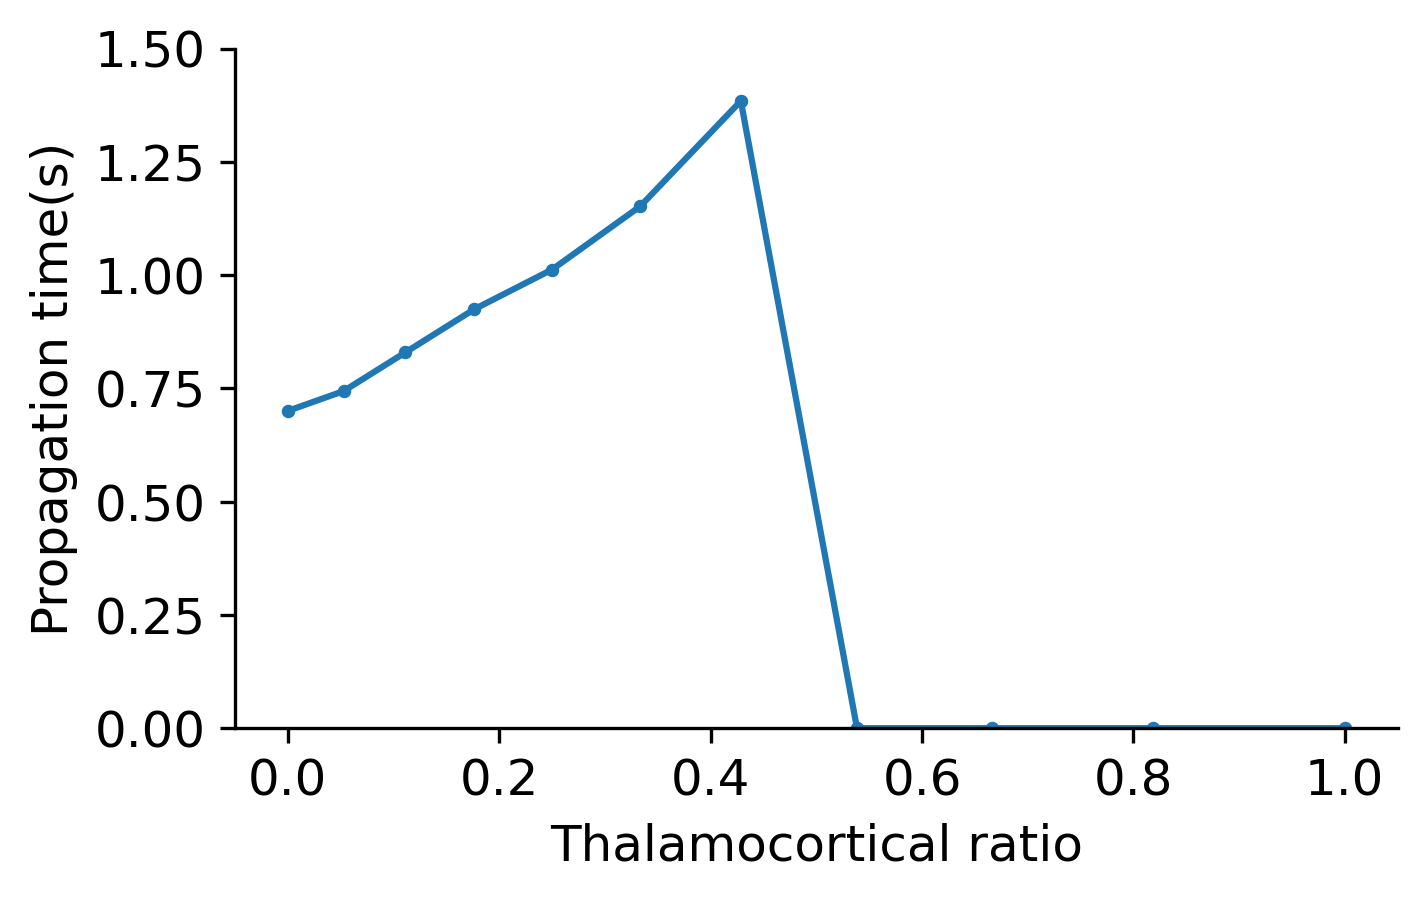

In [141]:
analyzeRampTimeVaringTHCX(gthcxlist, 0.5, connSum, 5, (5,3), 12, True, 'varingTHCXrampTime.pdf')

5.91E-26
0. A
4.97E-27
5. pA
4.70E-30
10. pA
1.61E-29
15. pA
3.56E-28
20. pA
3.69E-28
25. pA
2.06E-27
30. pA
2.58E-31
35. pA
5.31E-32
40. pA
6.92E-33


WARNING    /Users/Allen/PycharmProjects/xingyu-mouse-large-scale-wm/notebooks/circuitModel.py:899: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
 [py.warnings]


45. pA
7.55E-33
50. pA


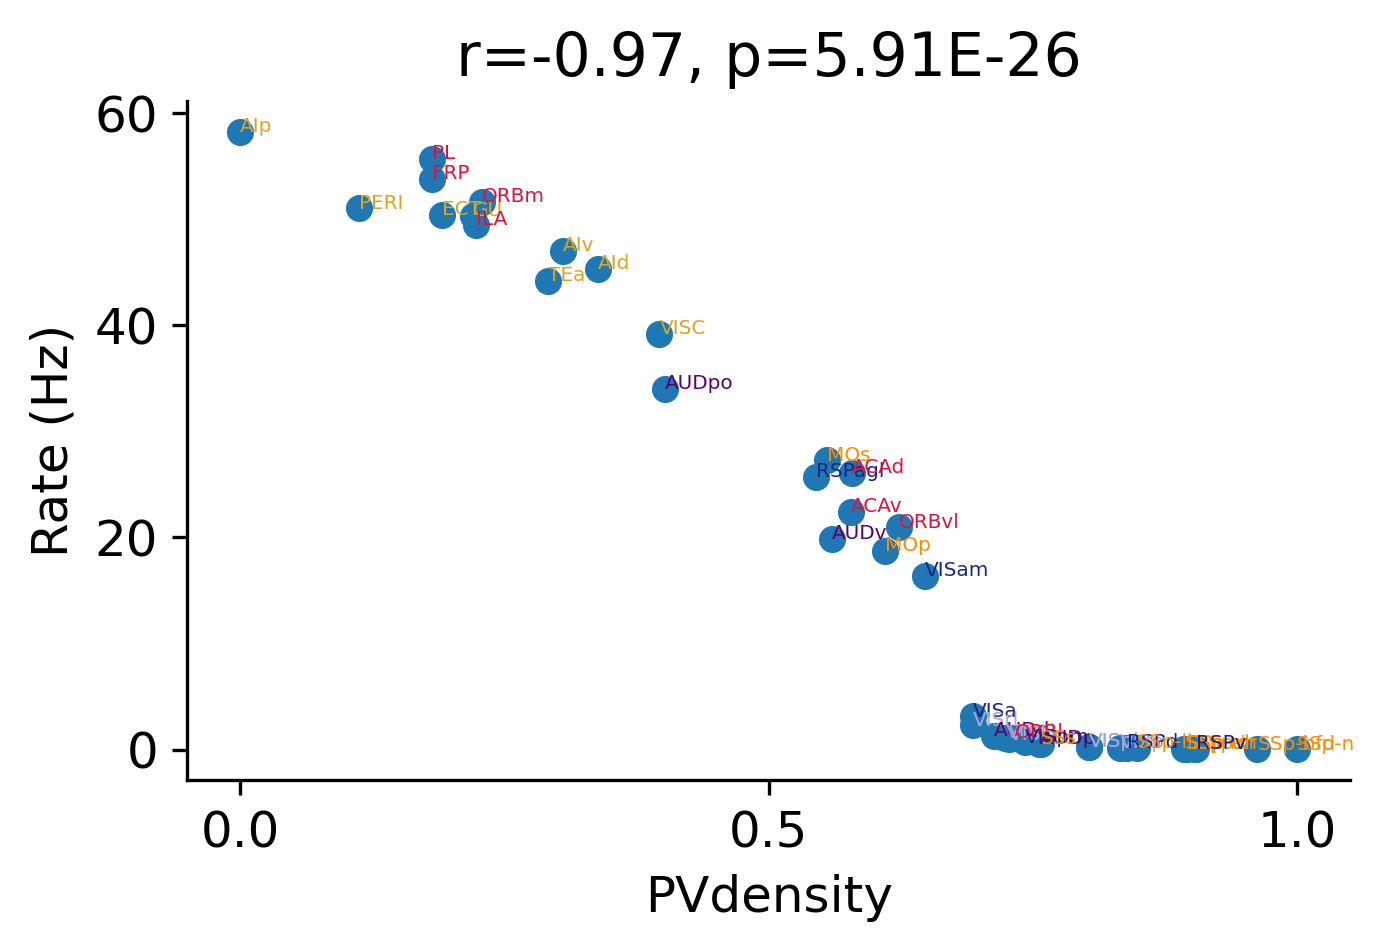

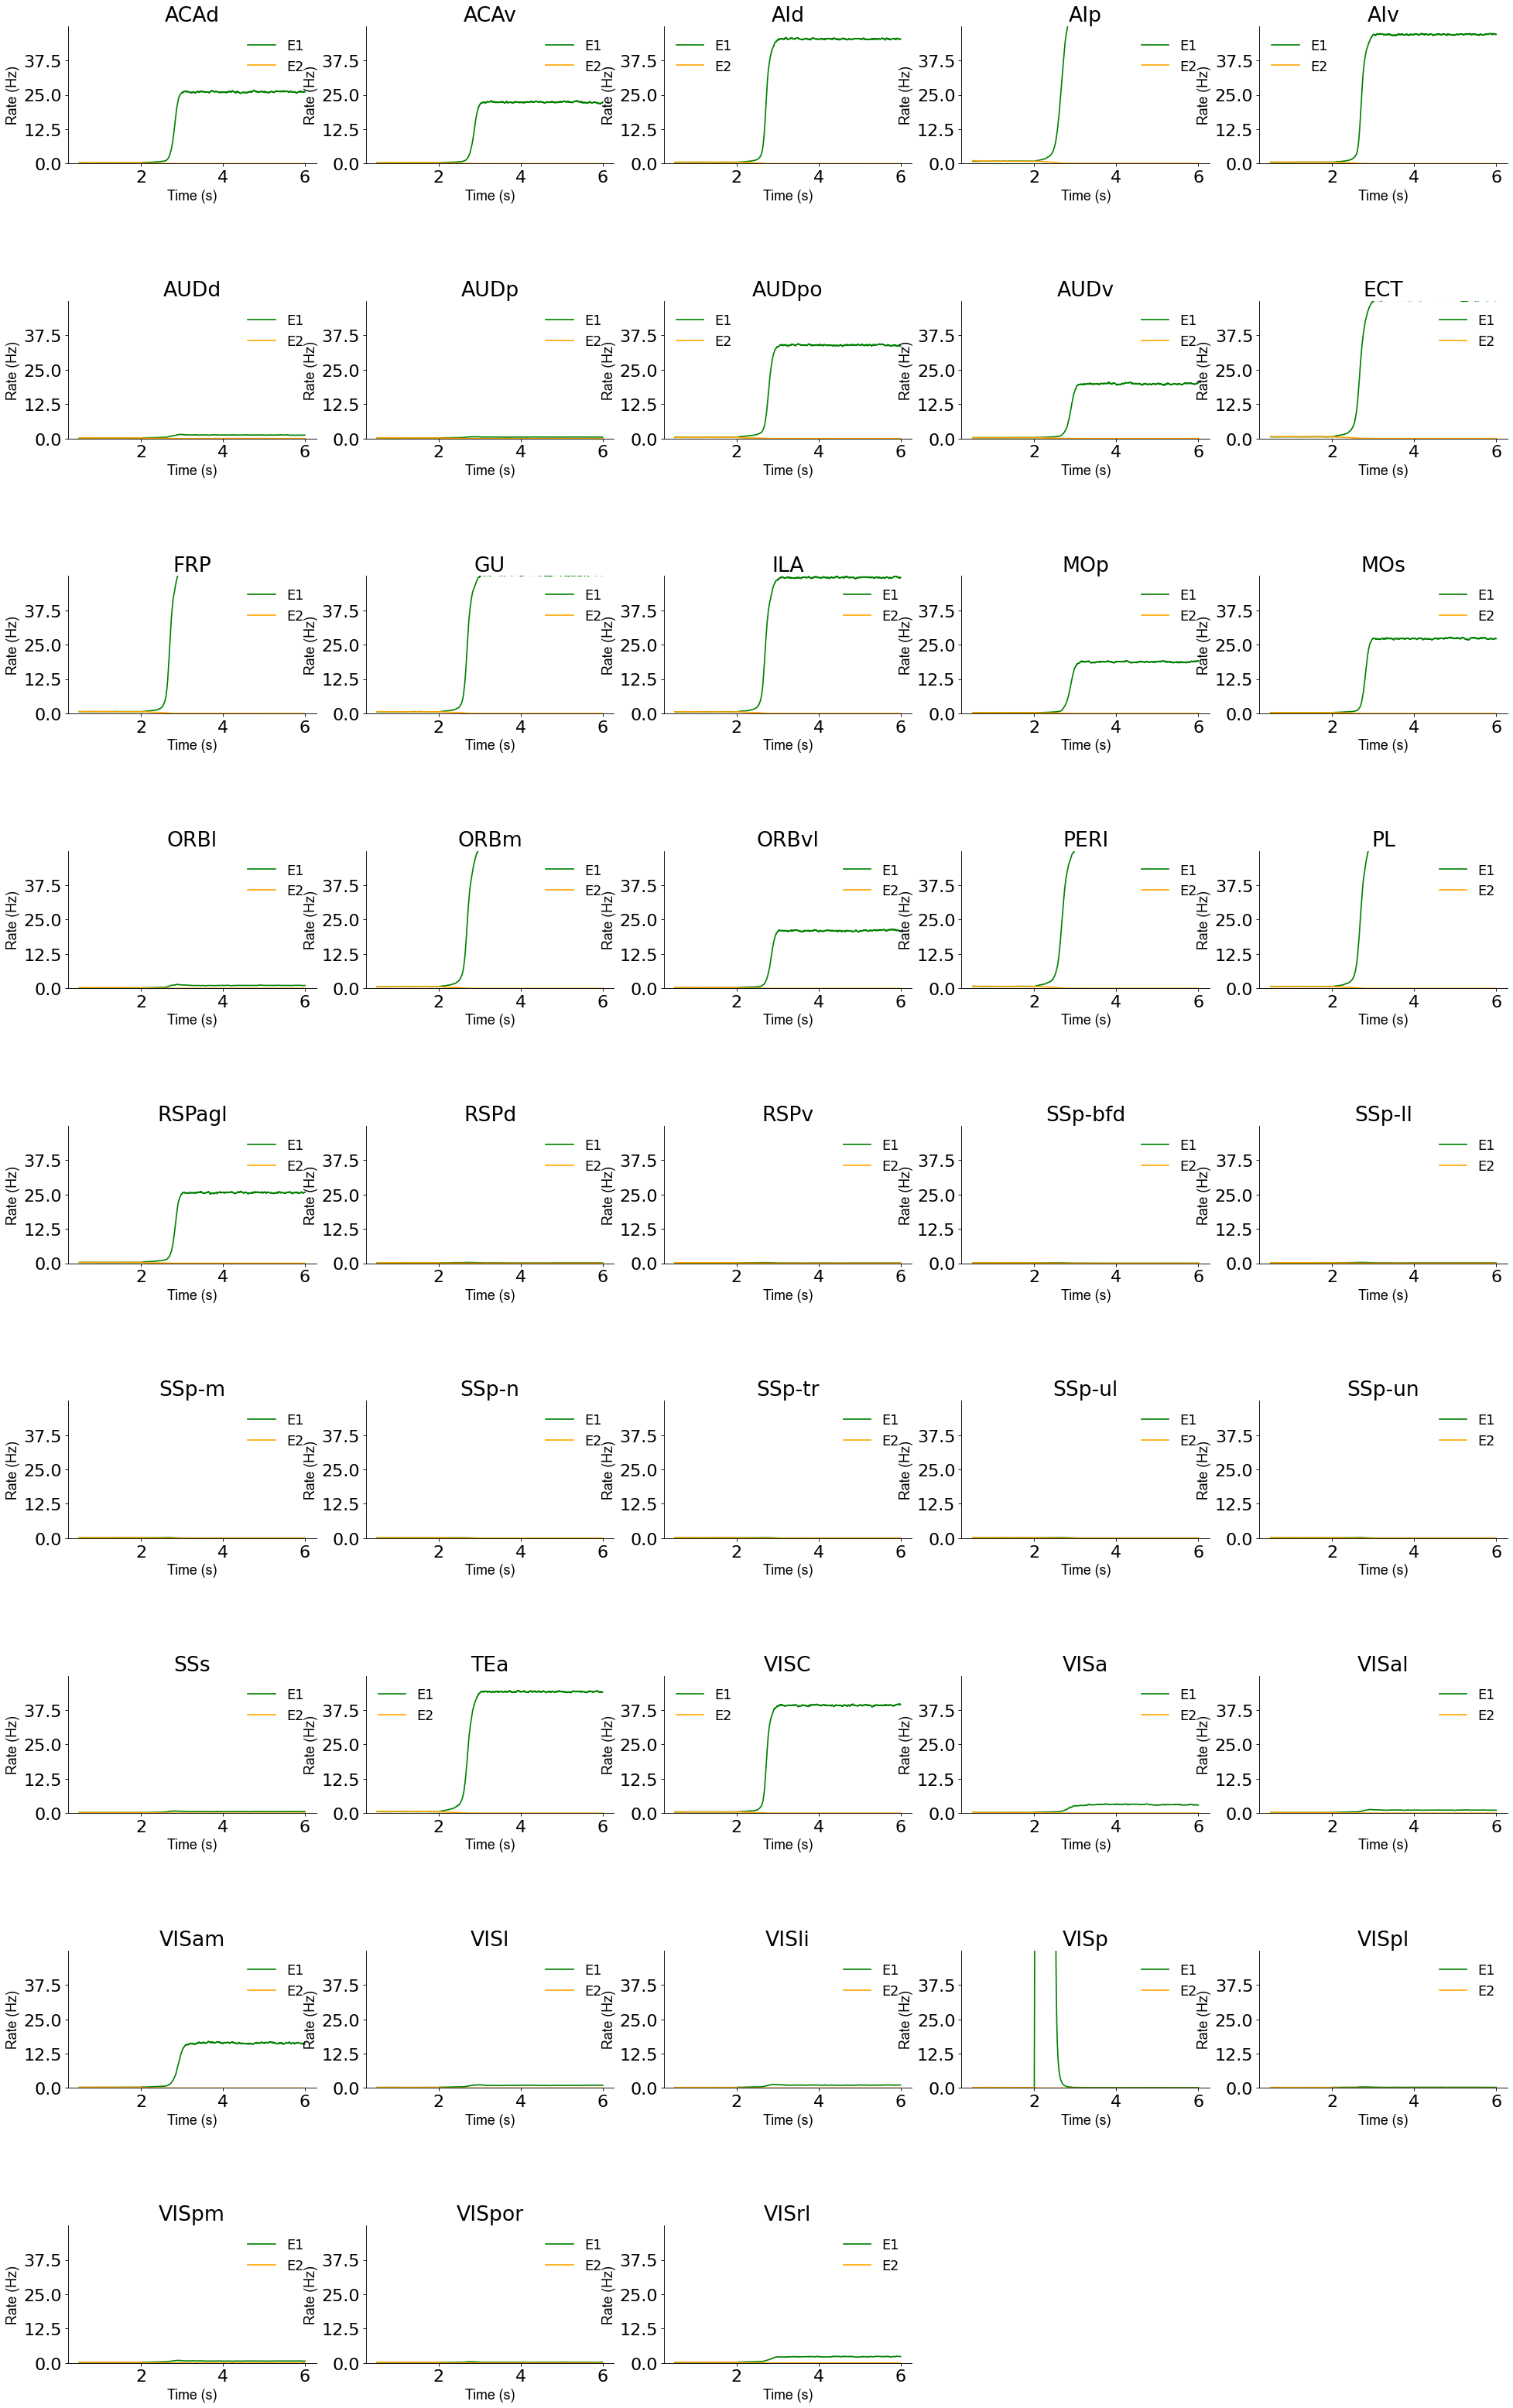

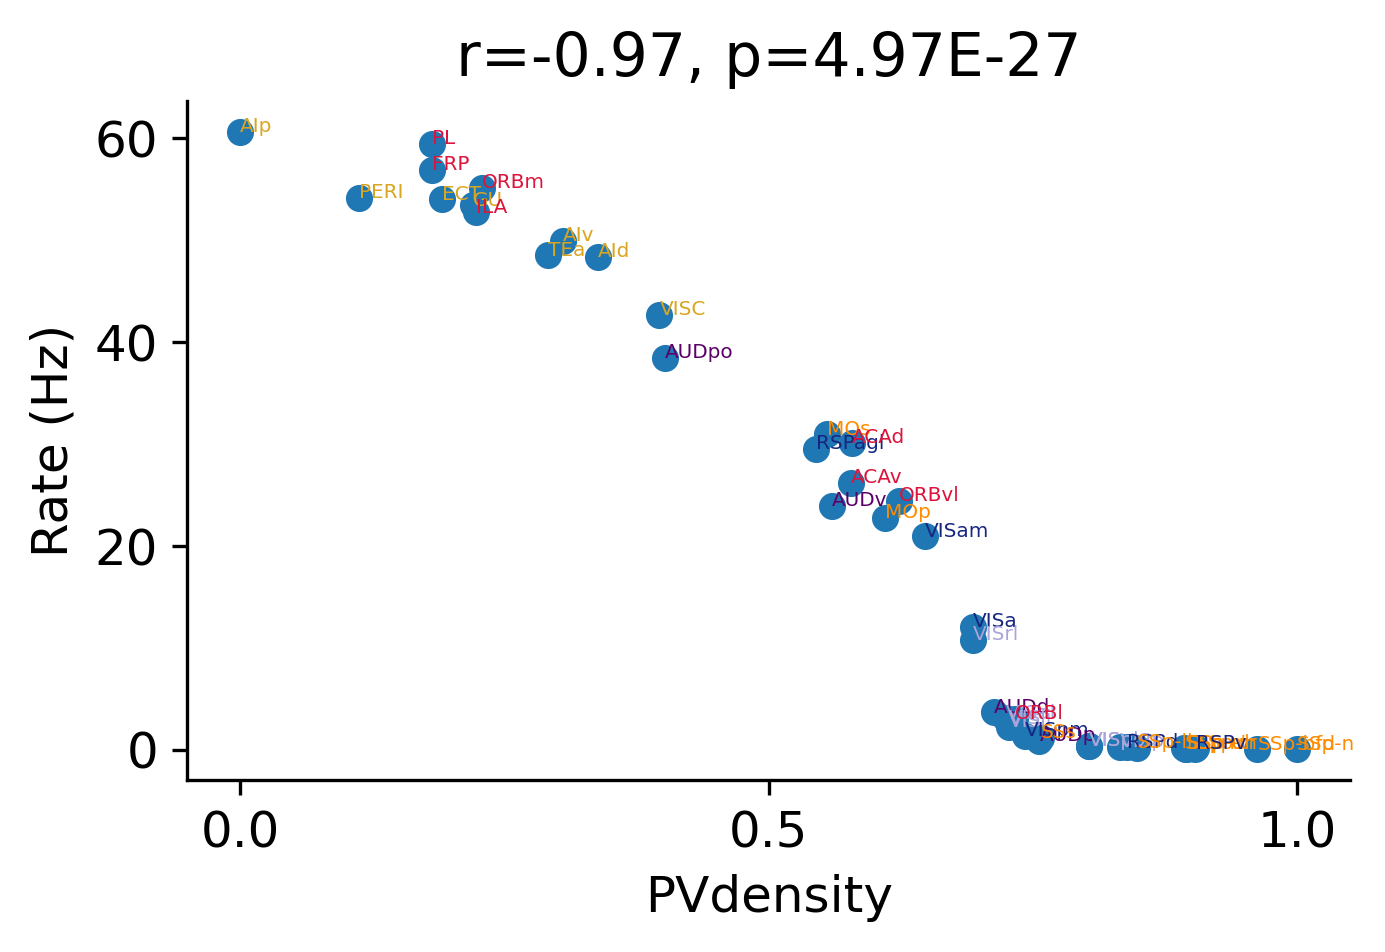

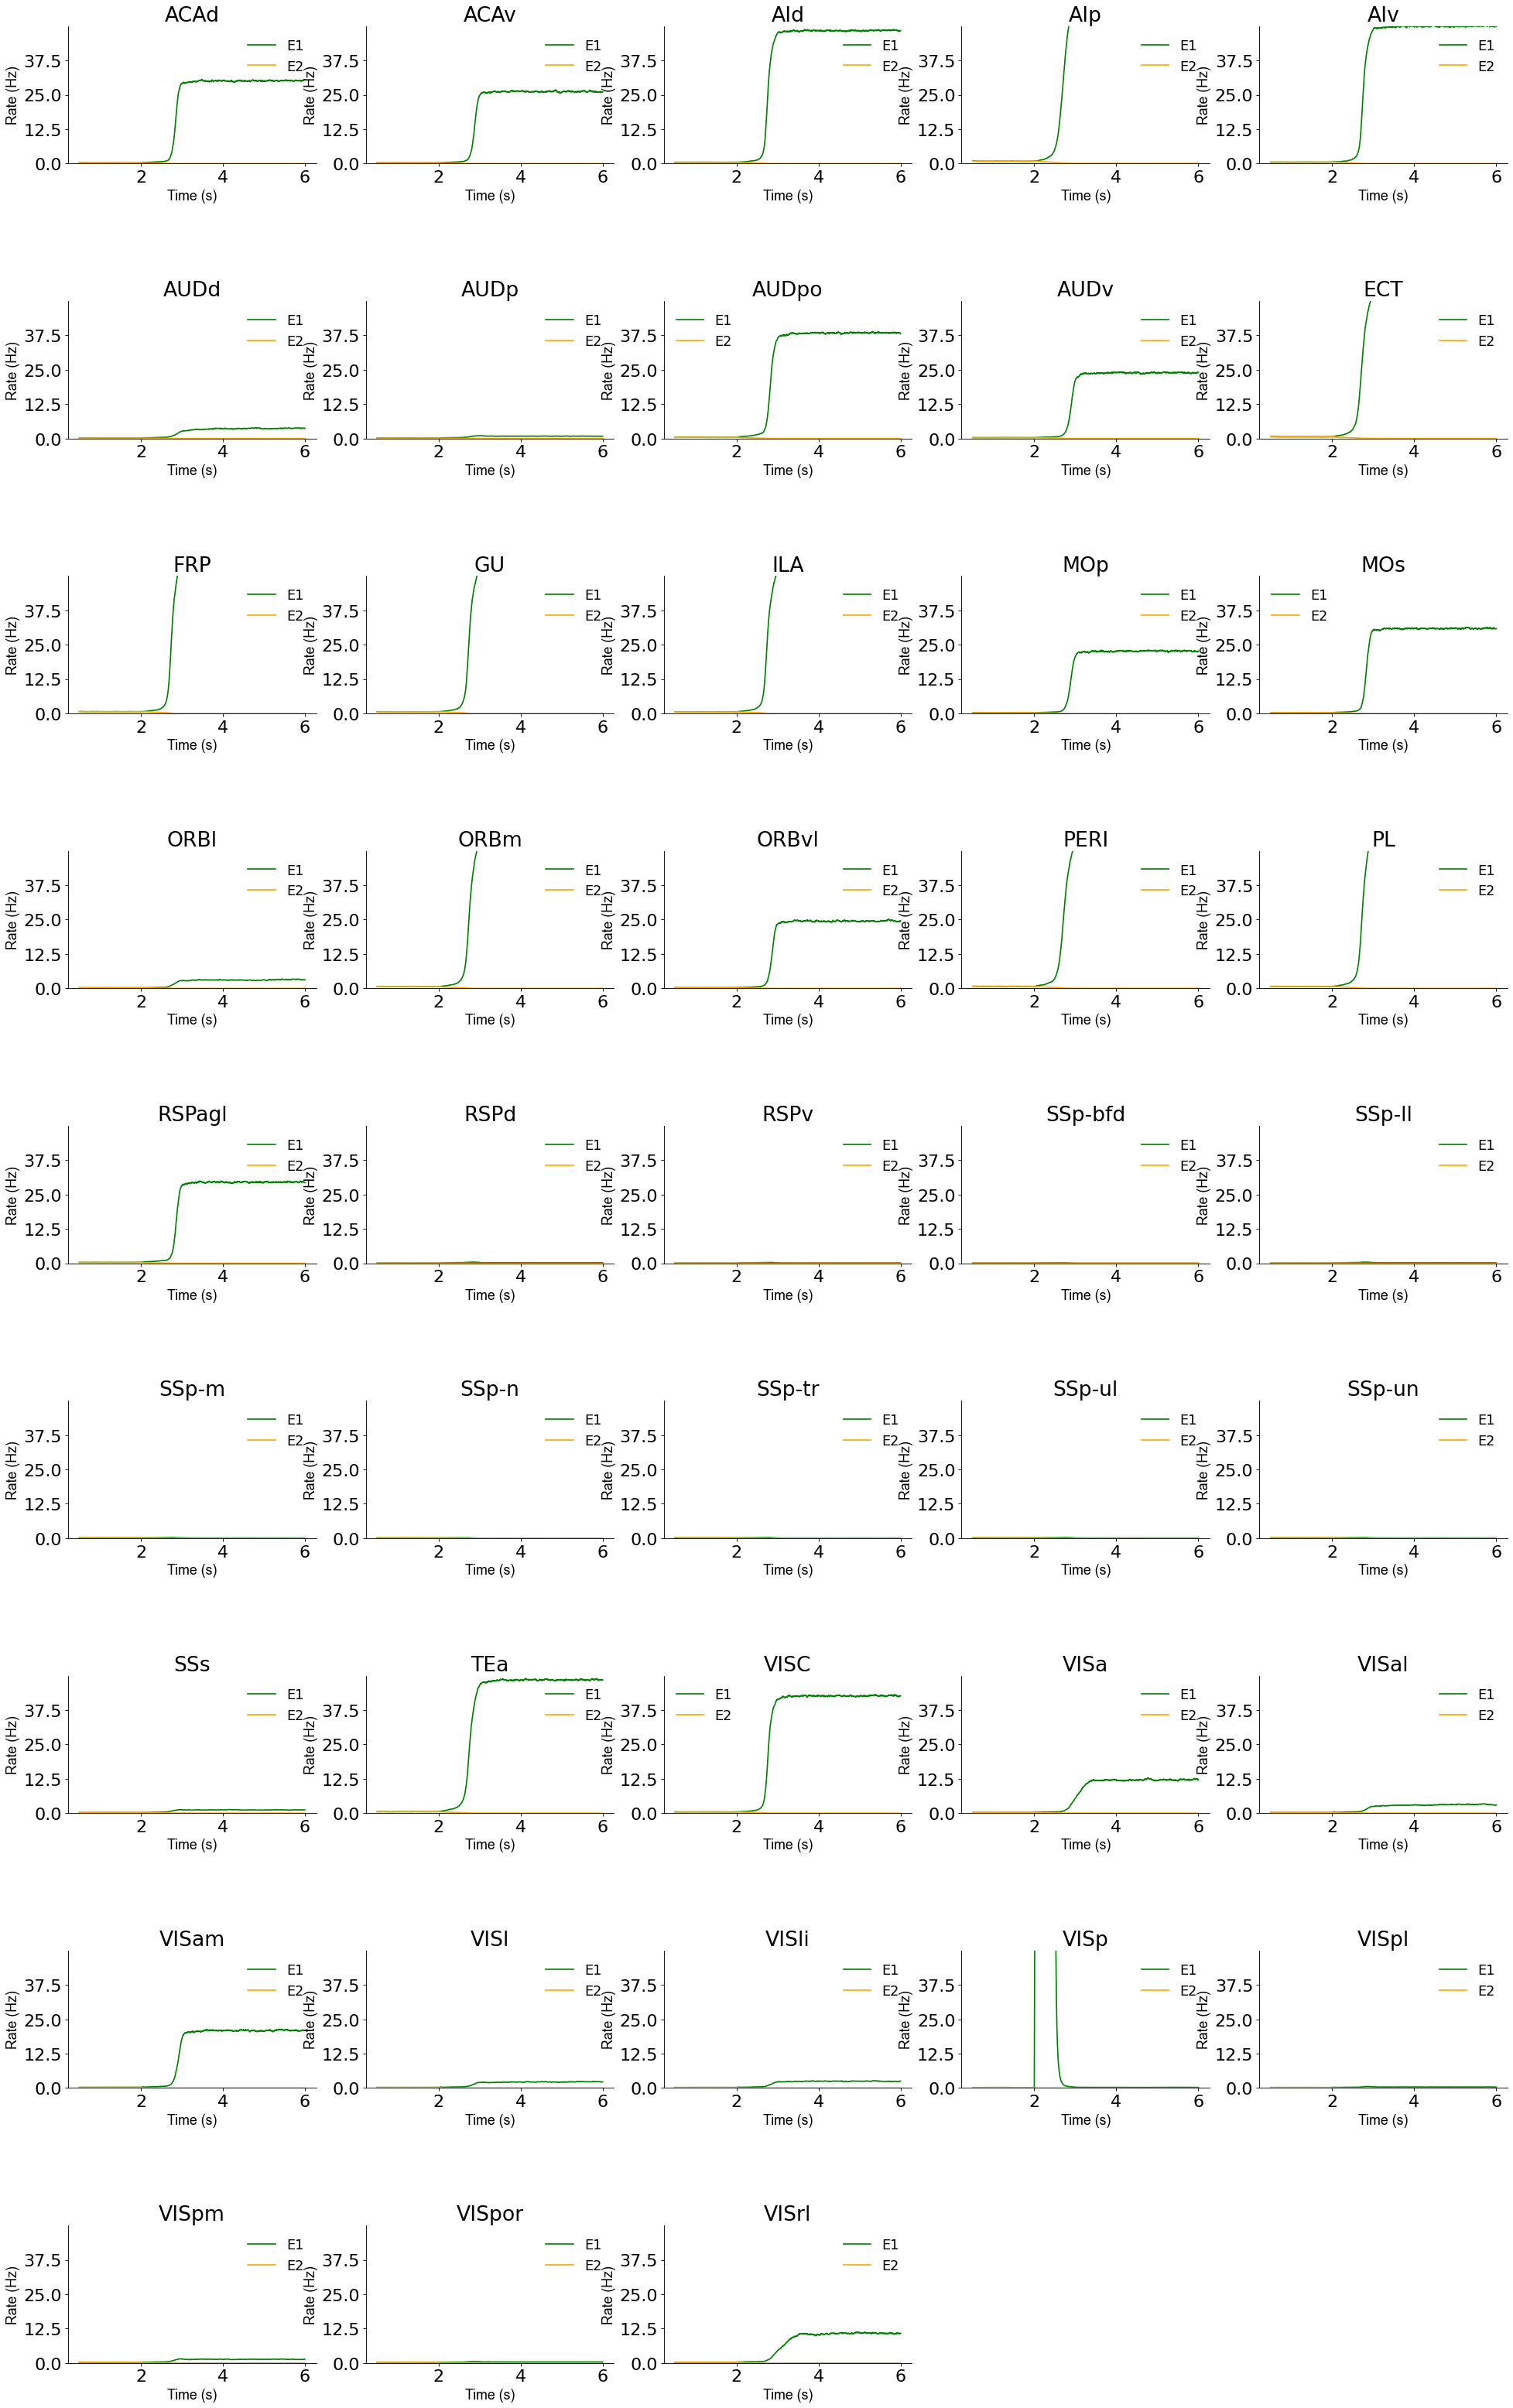

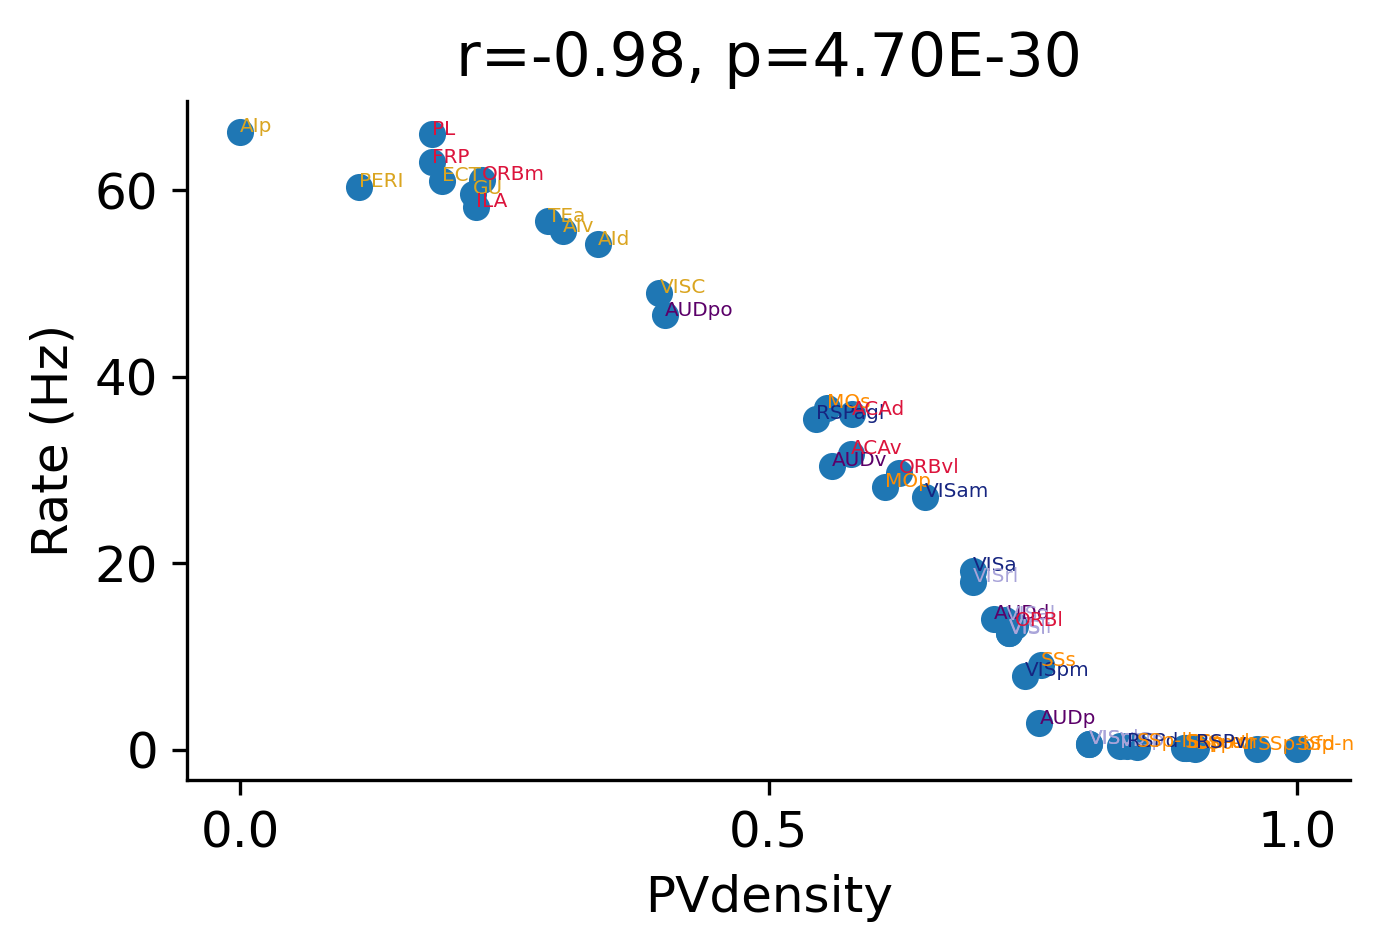

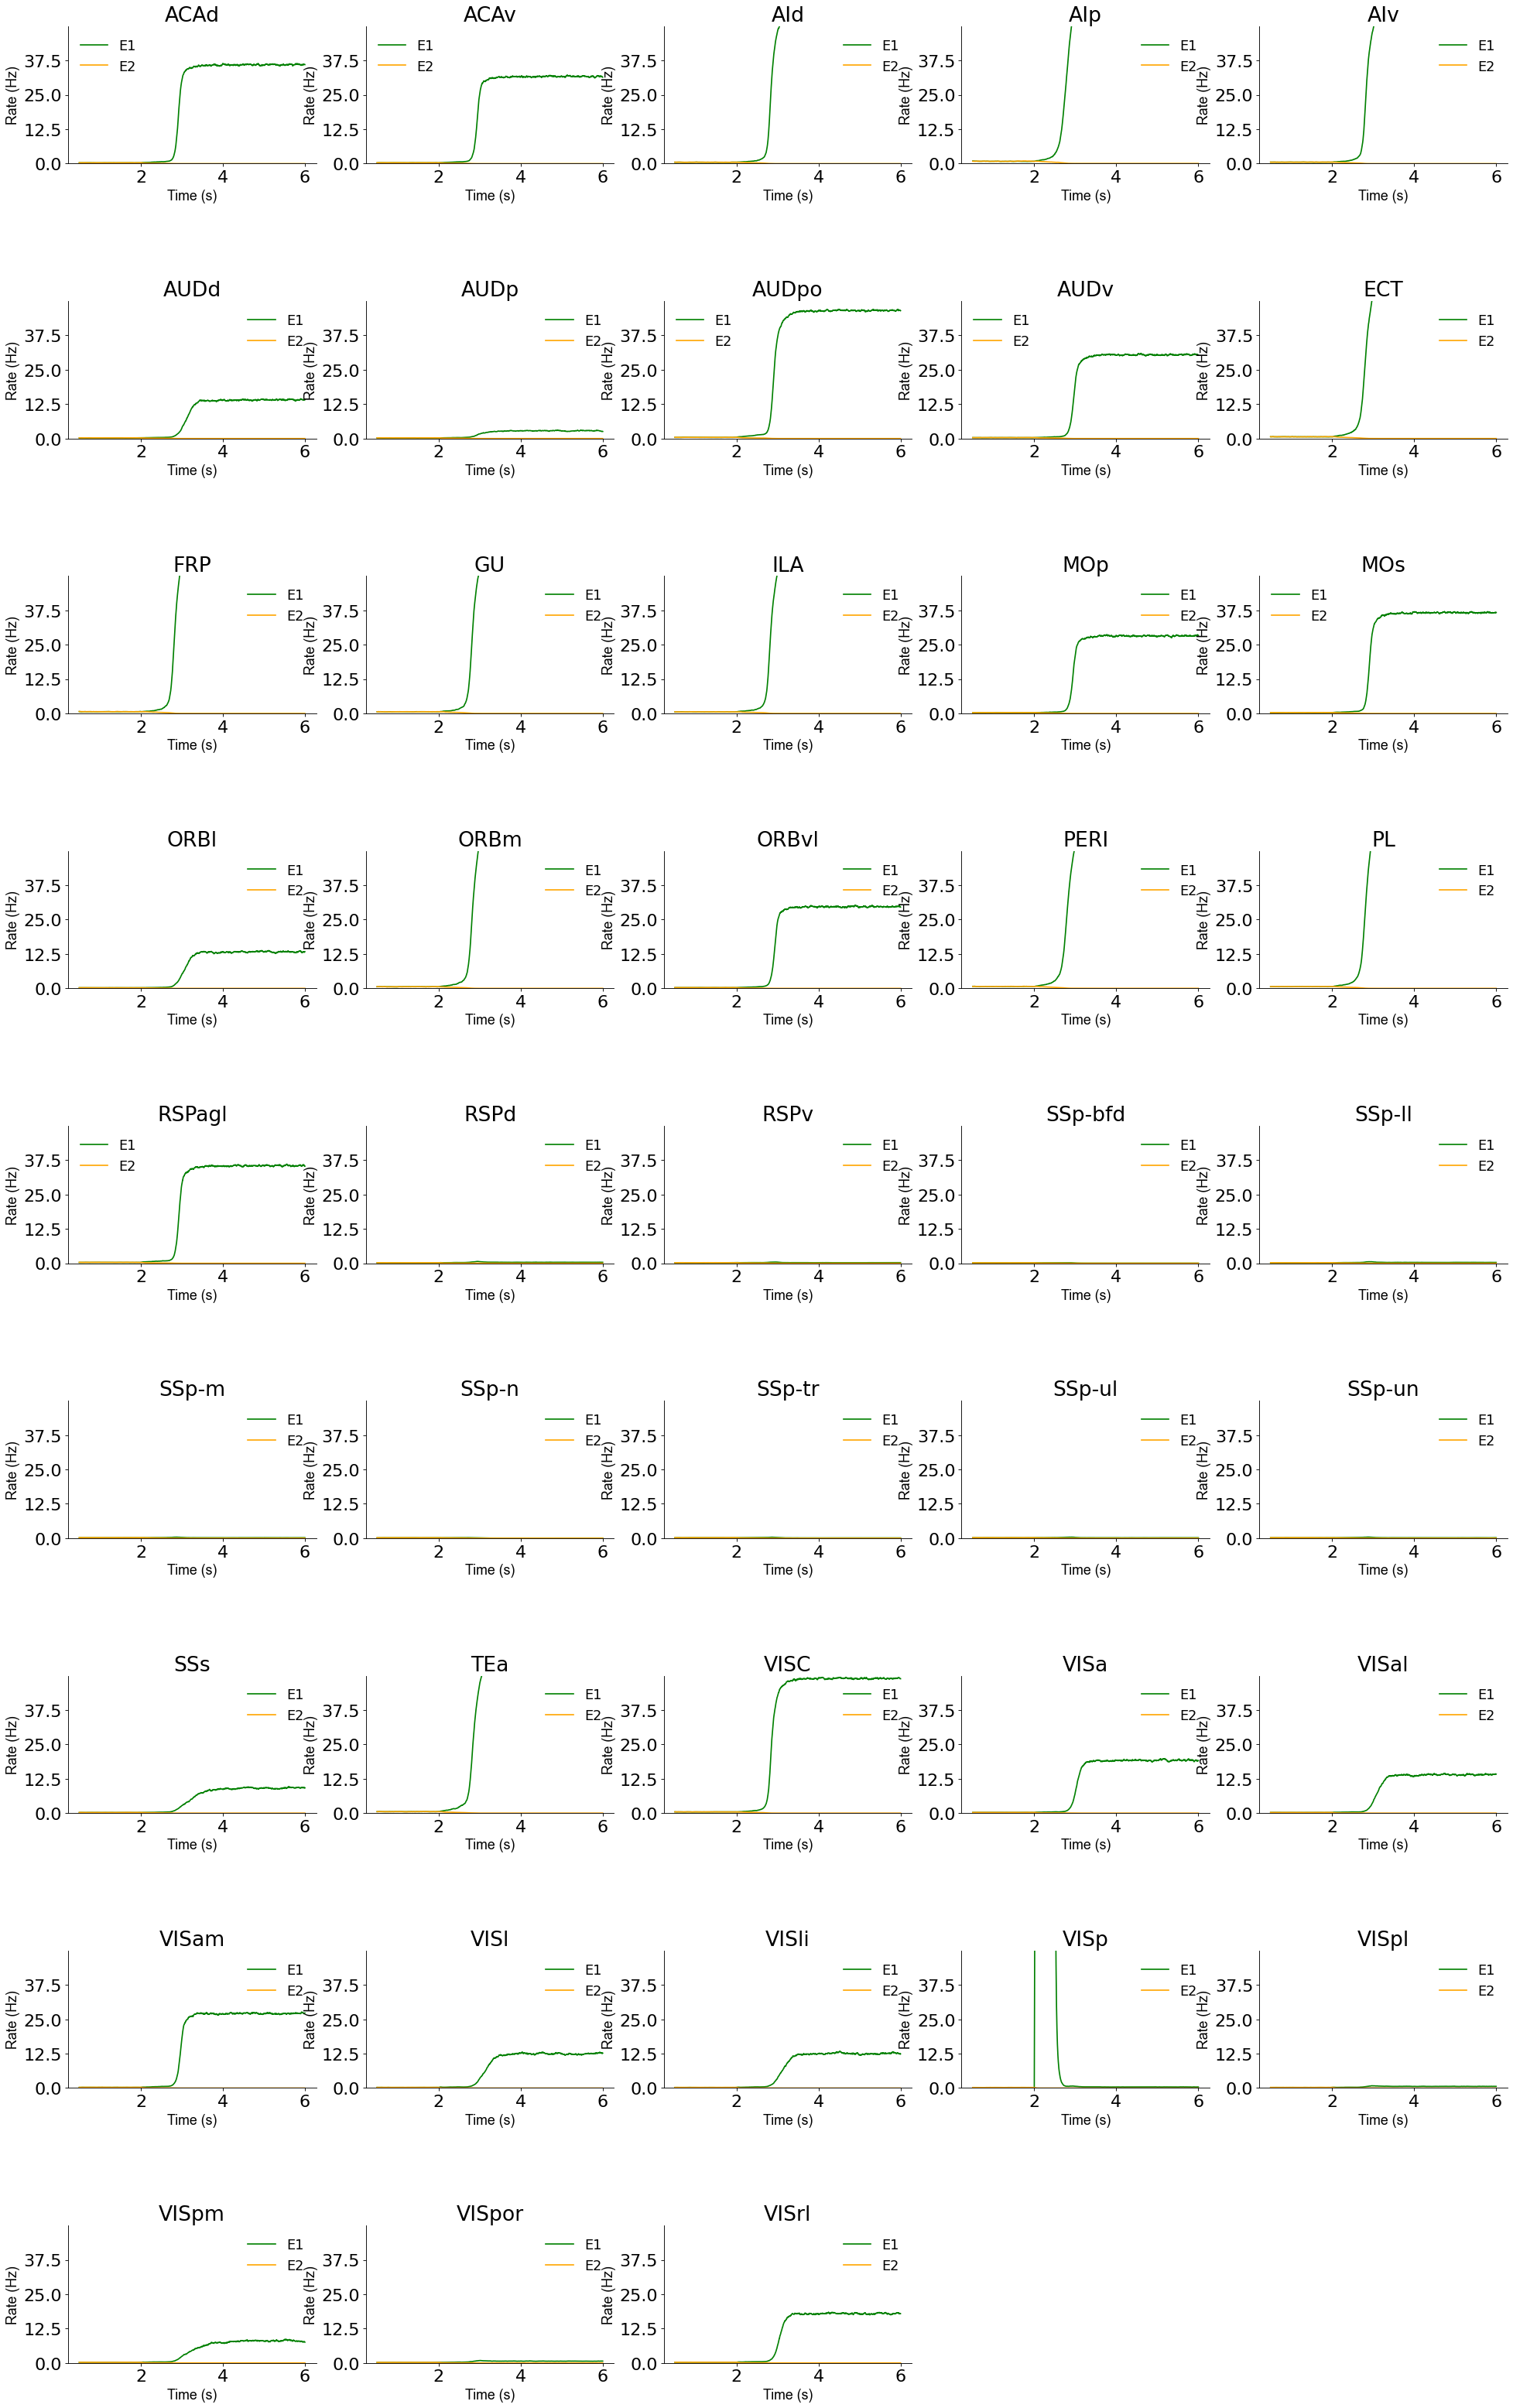

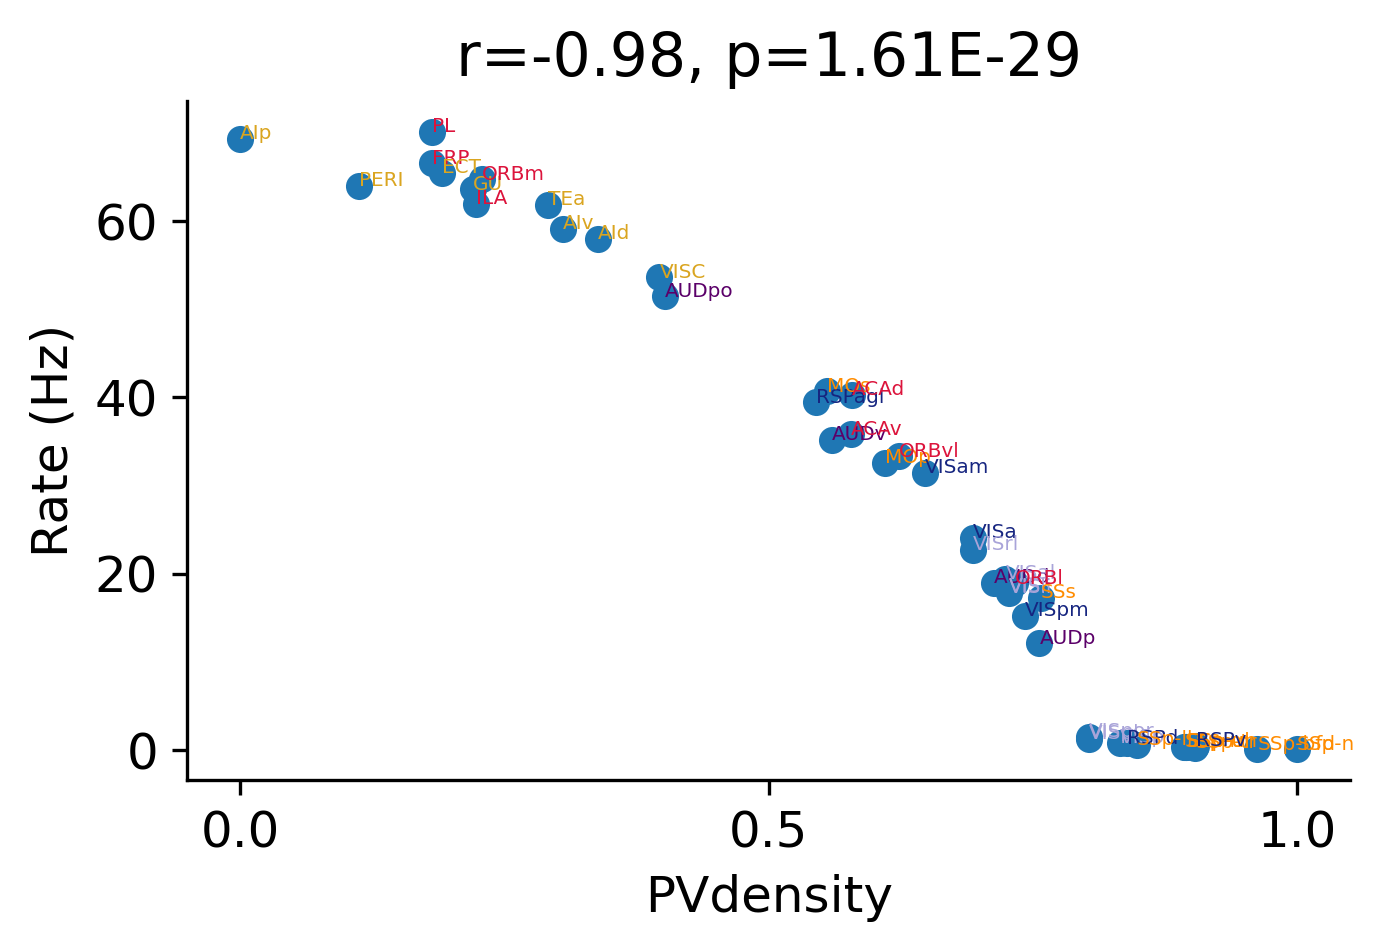

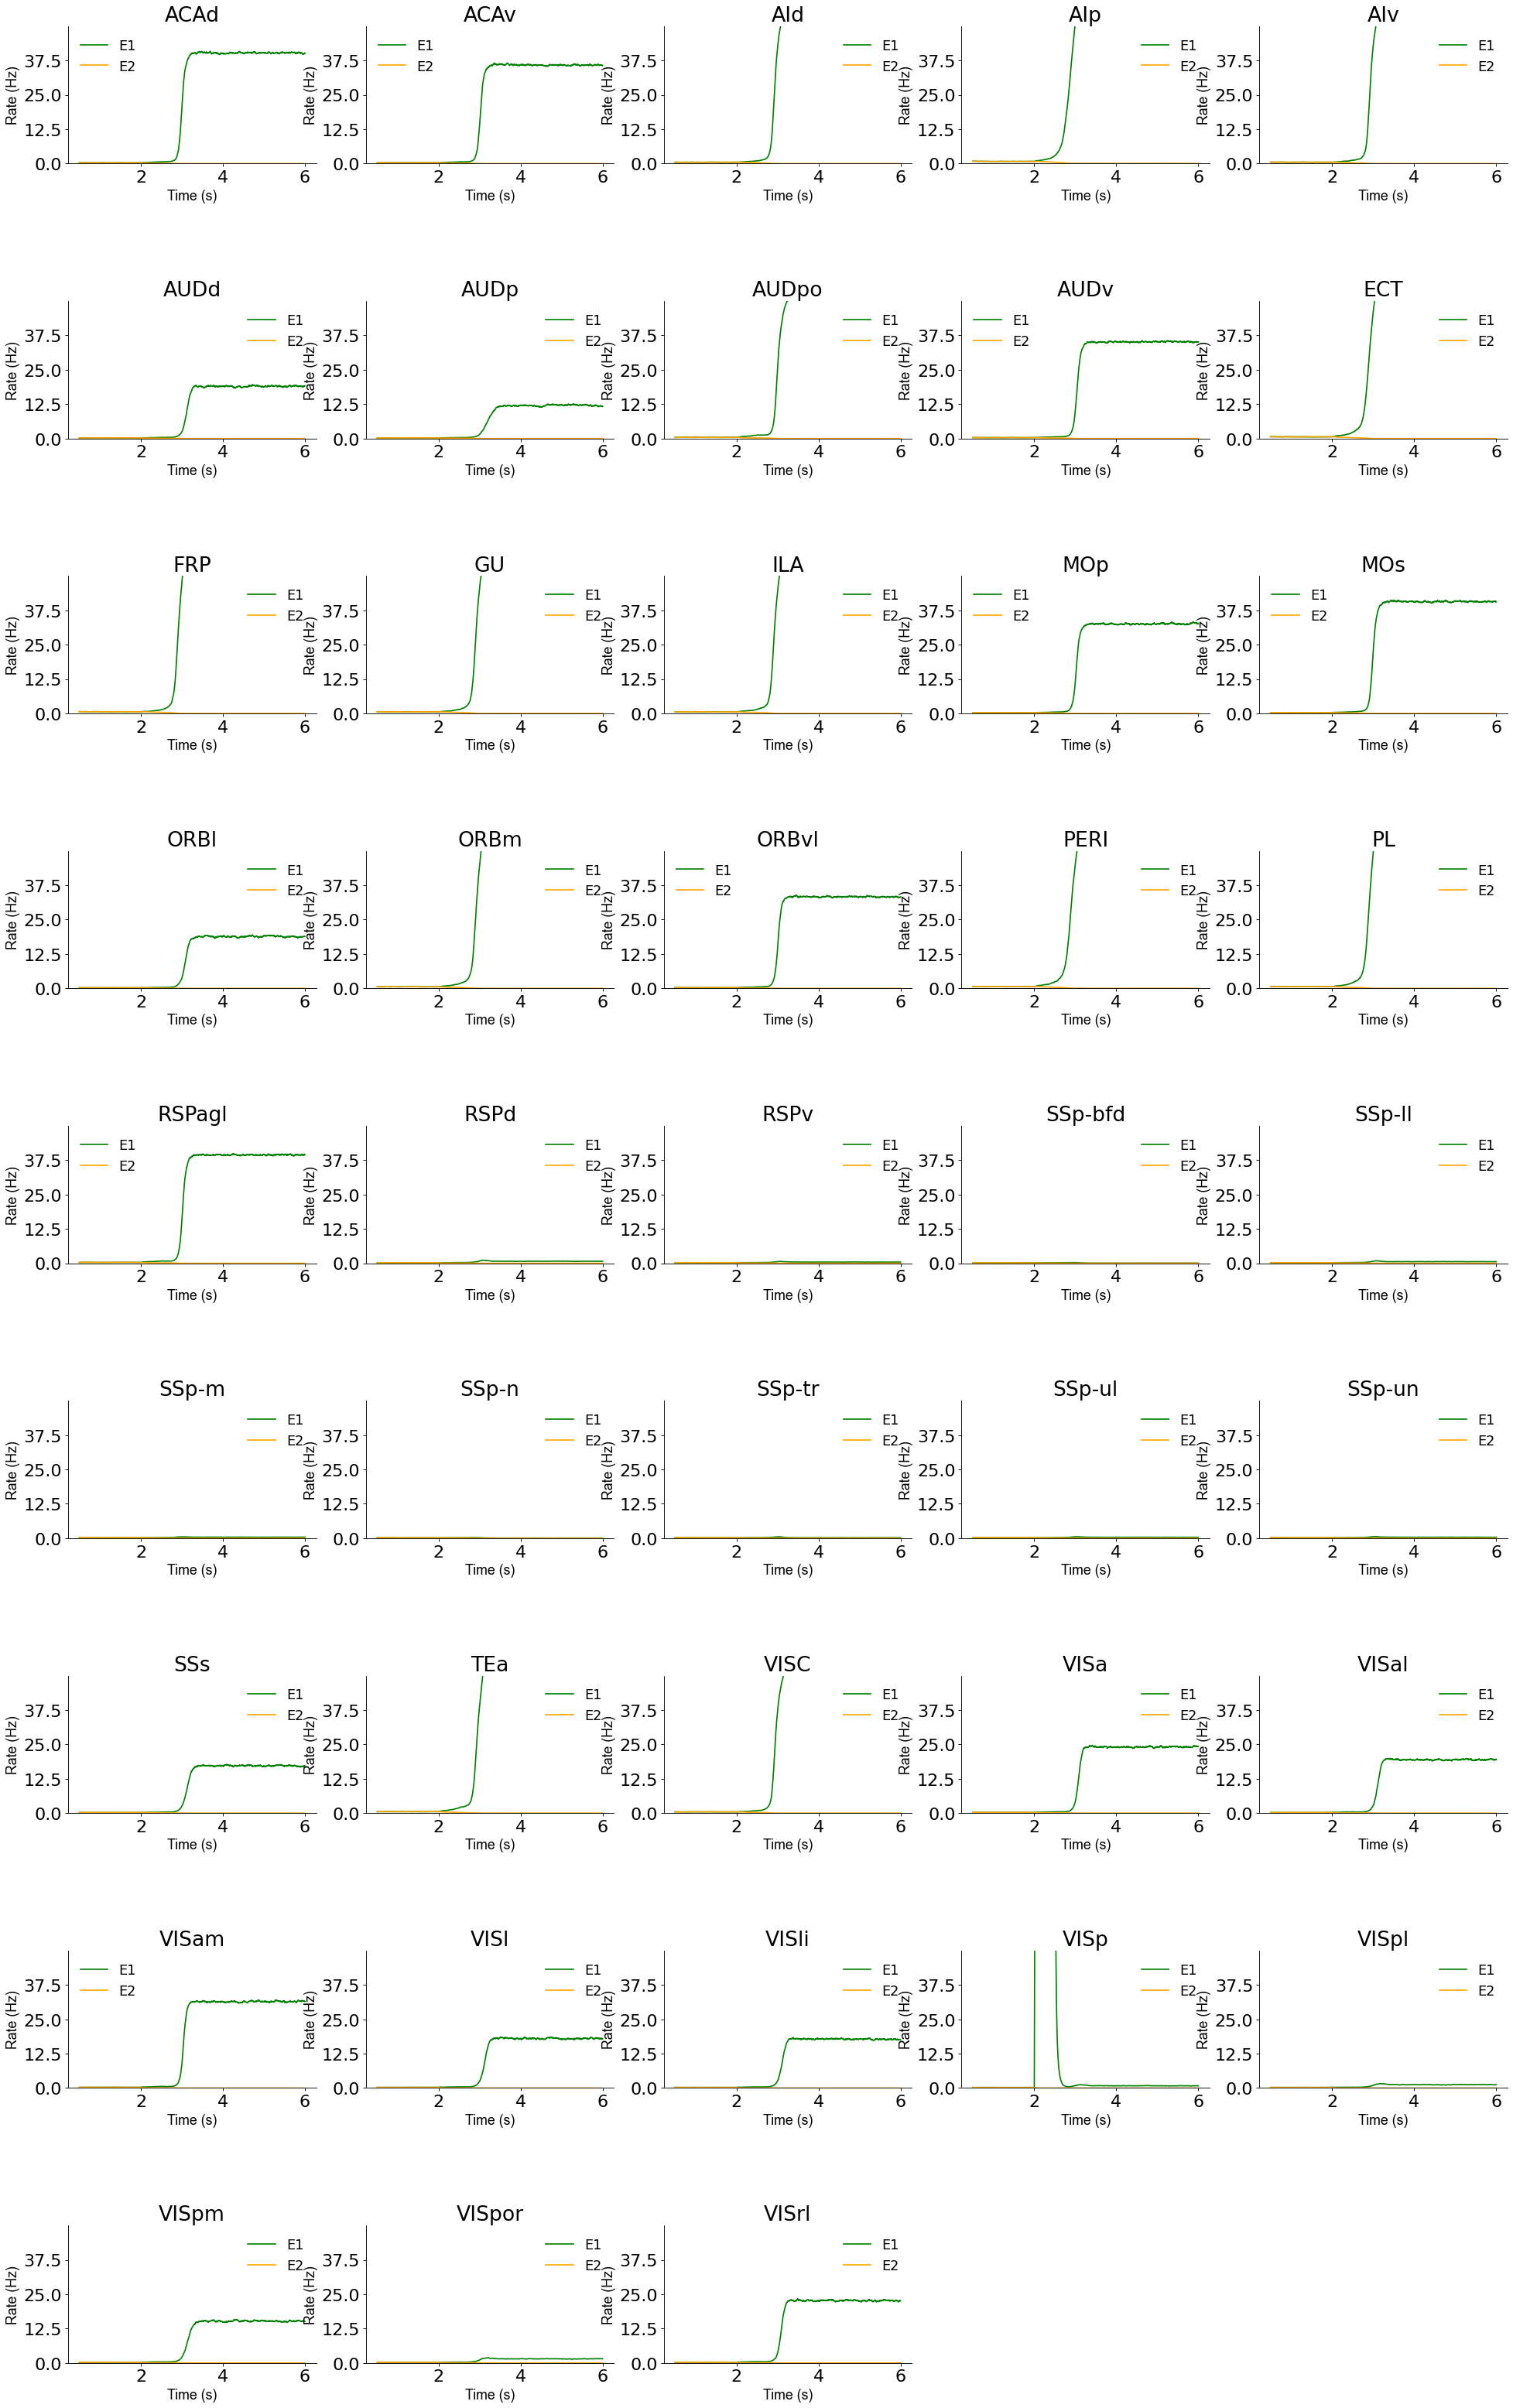

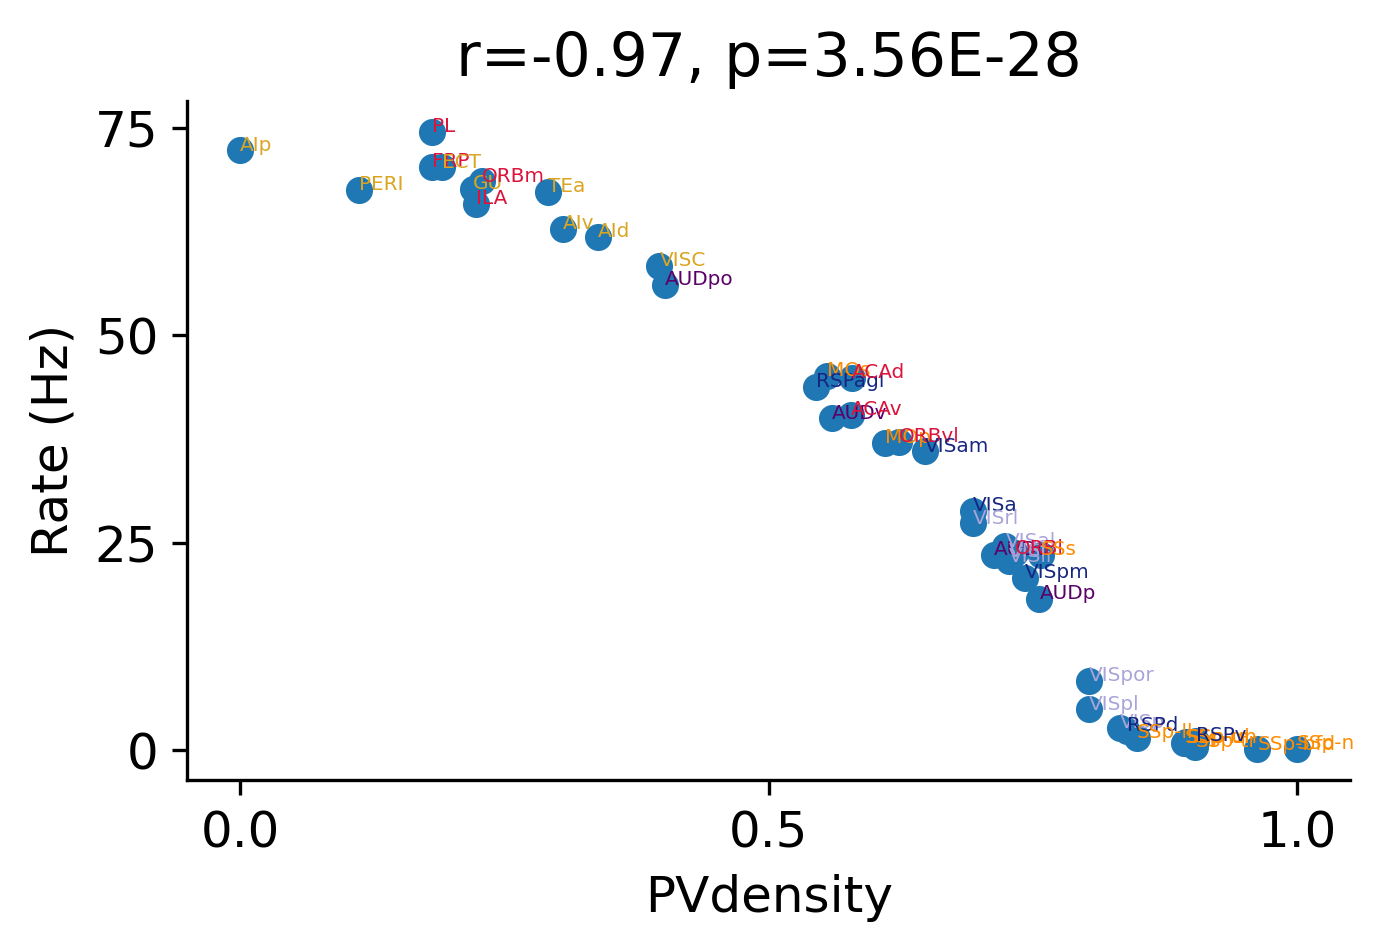

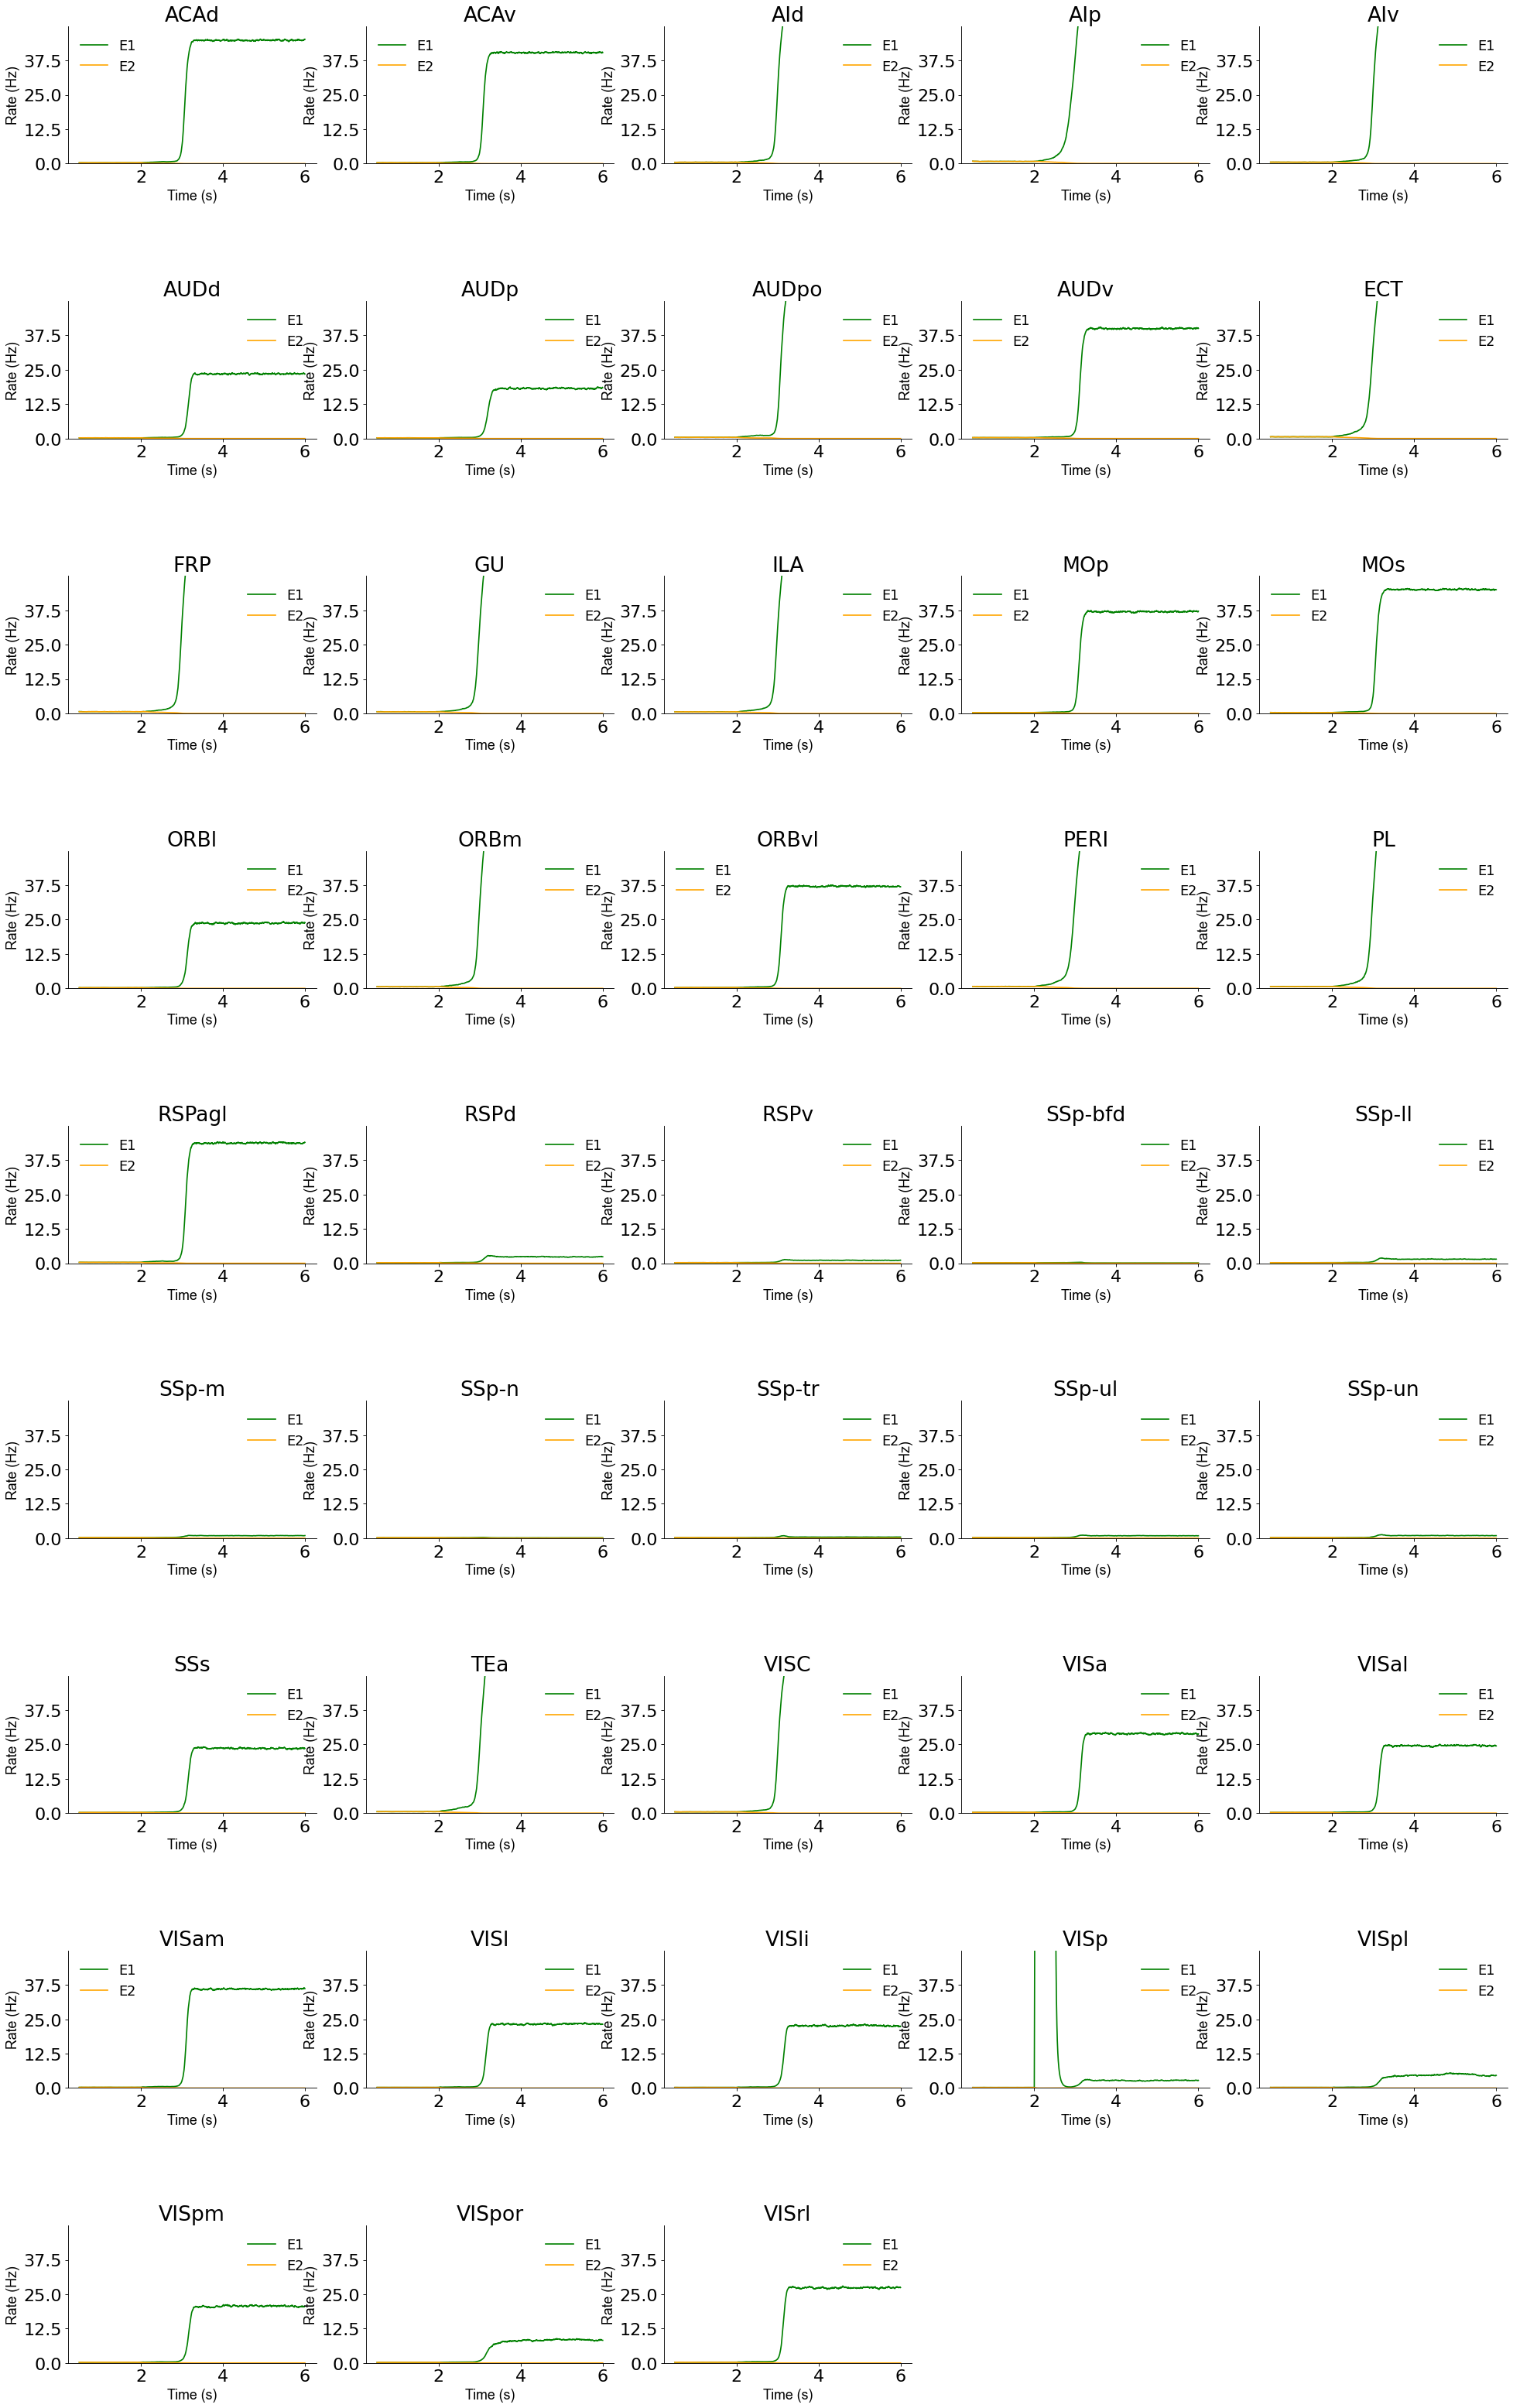

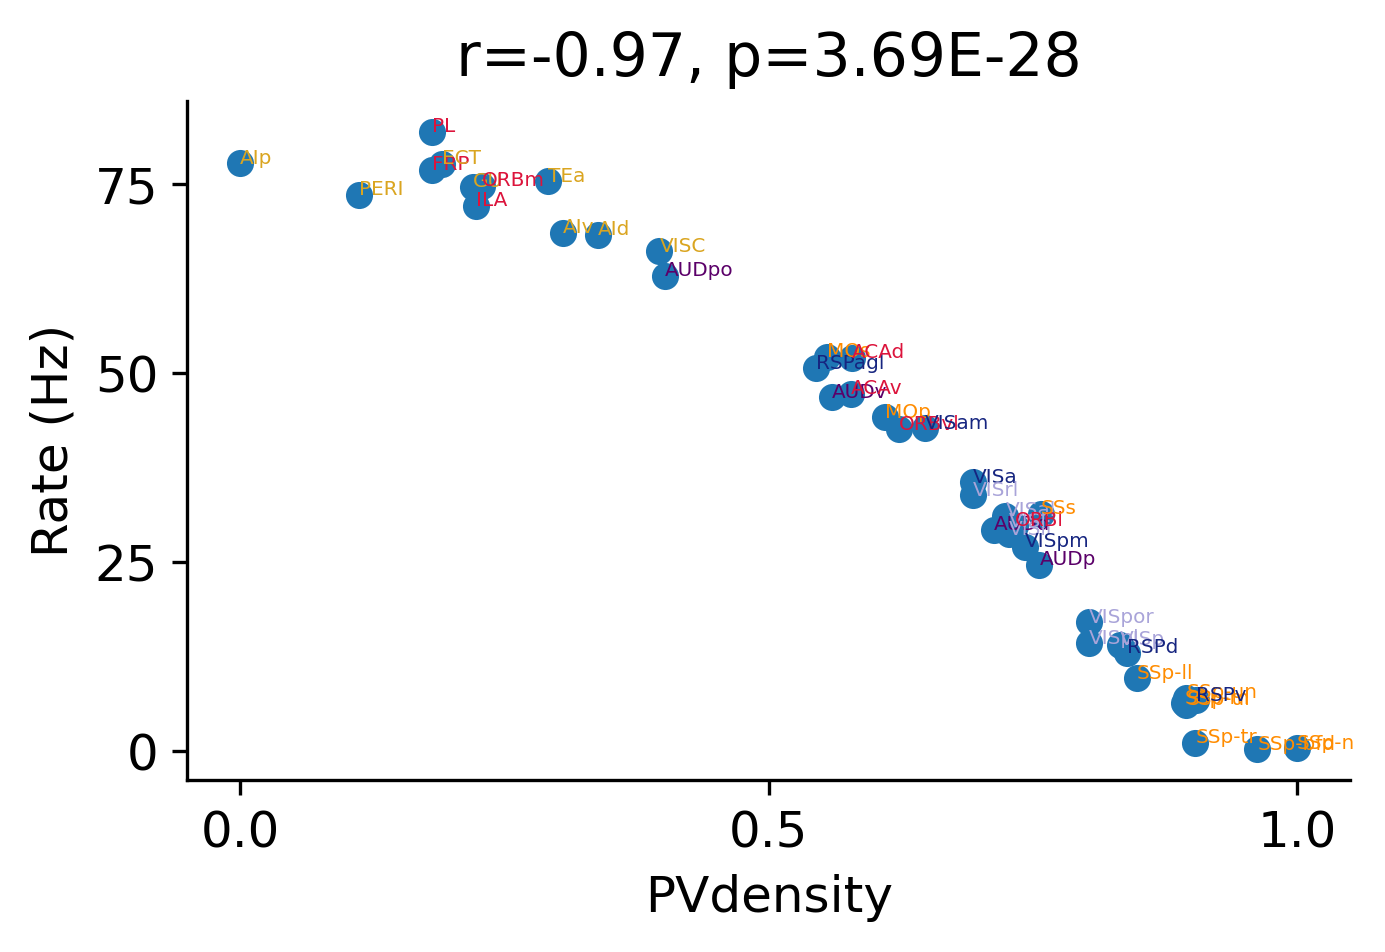

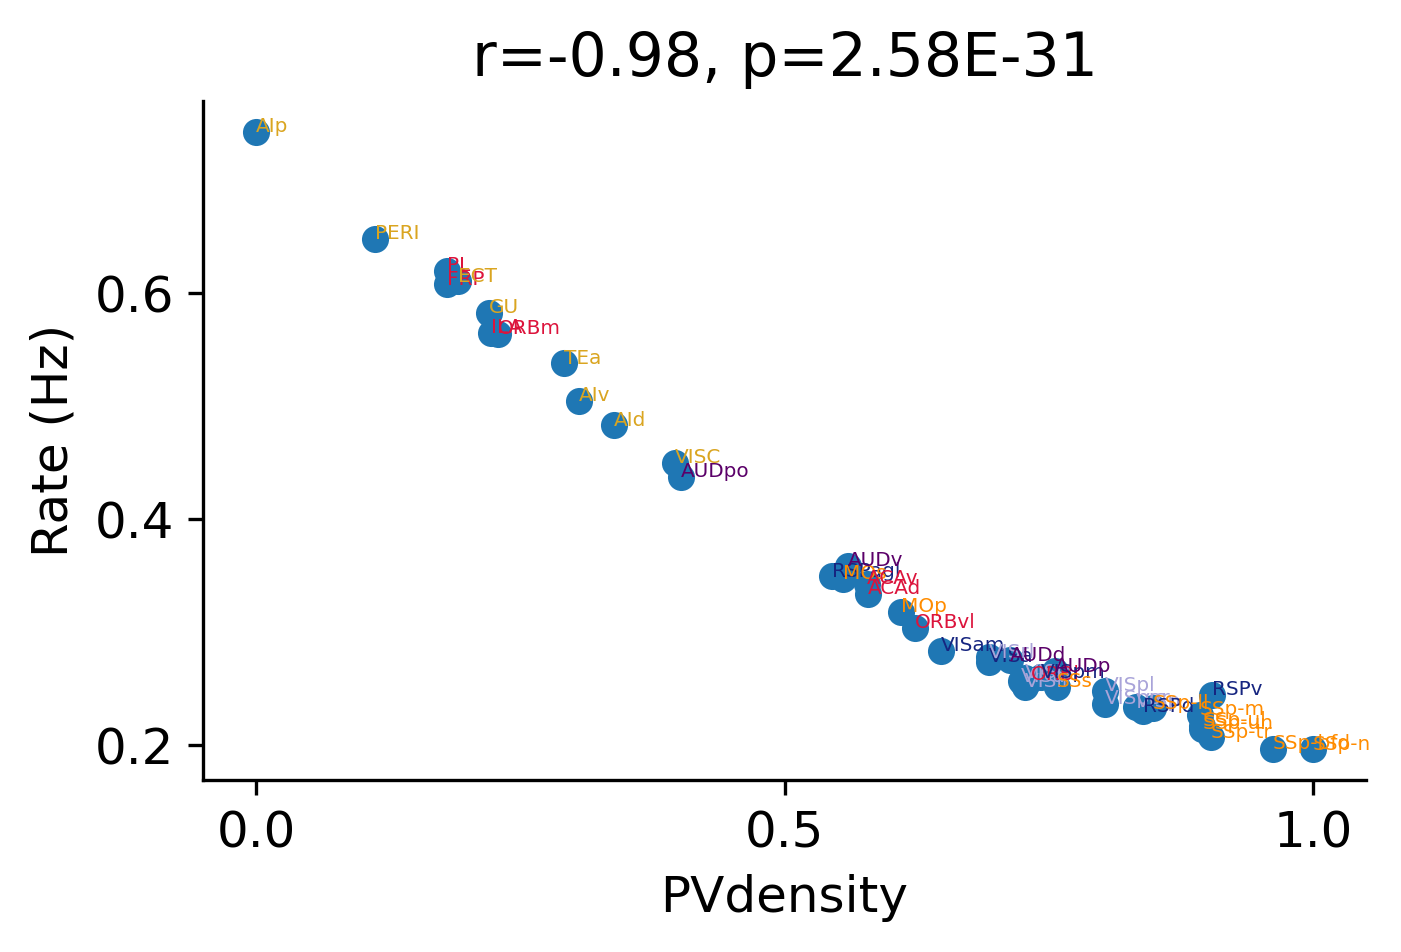

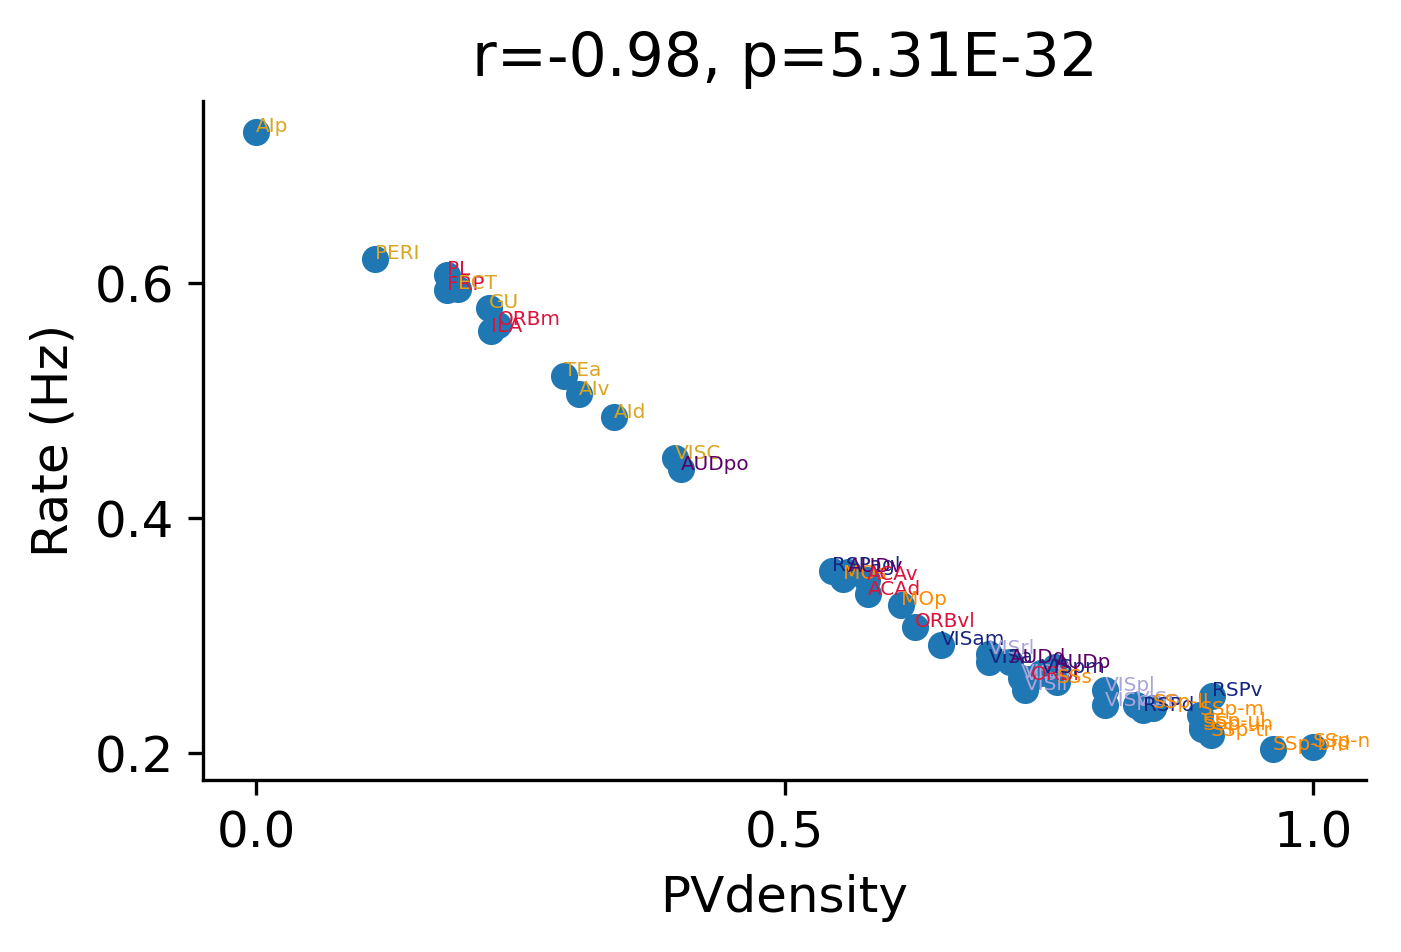

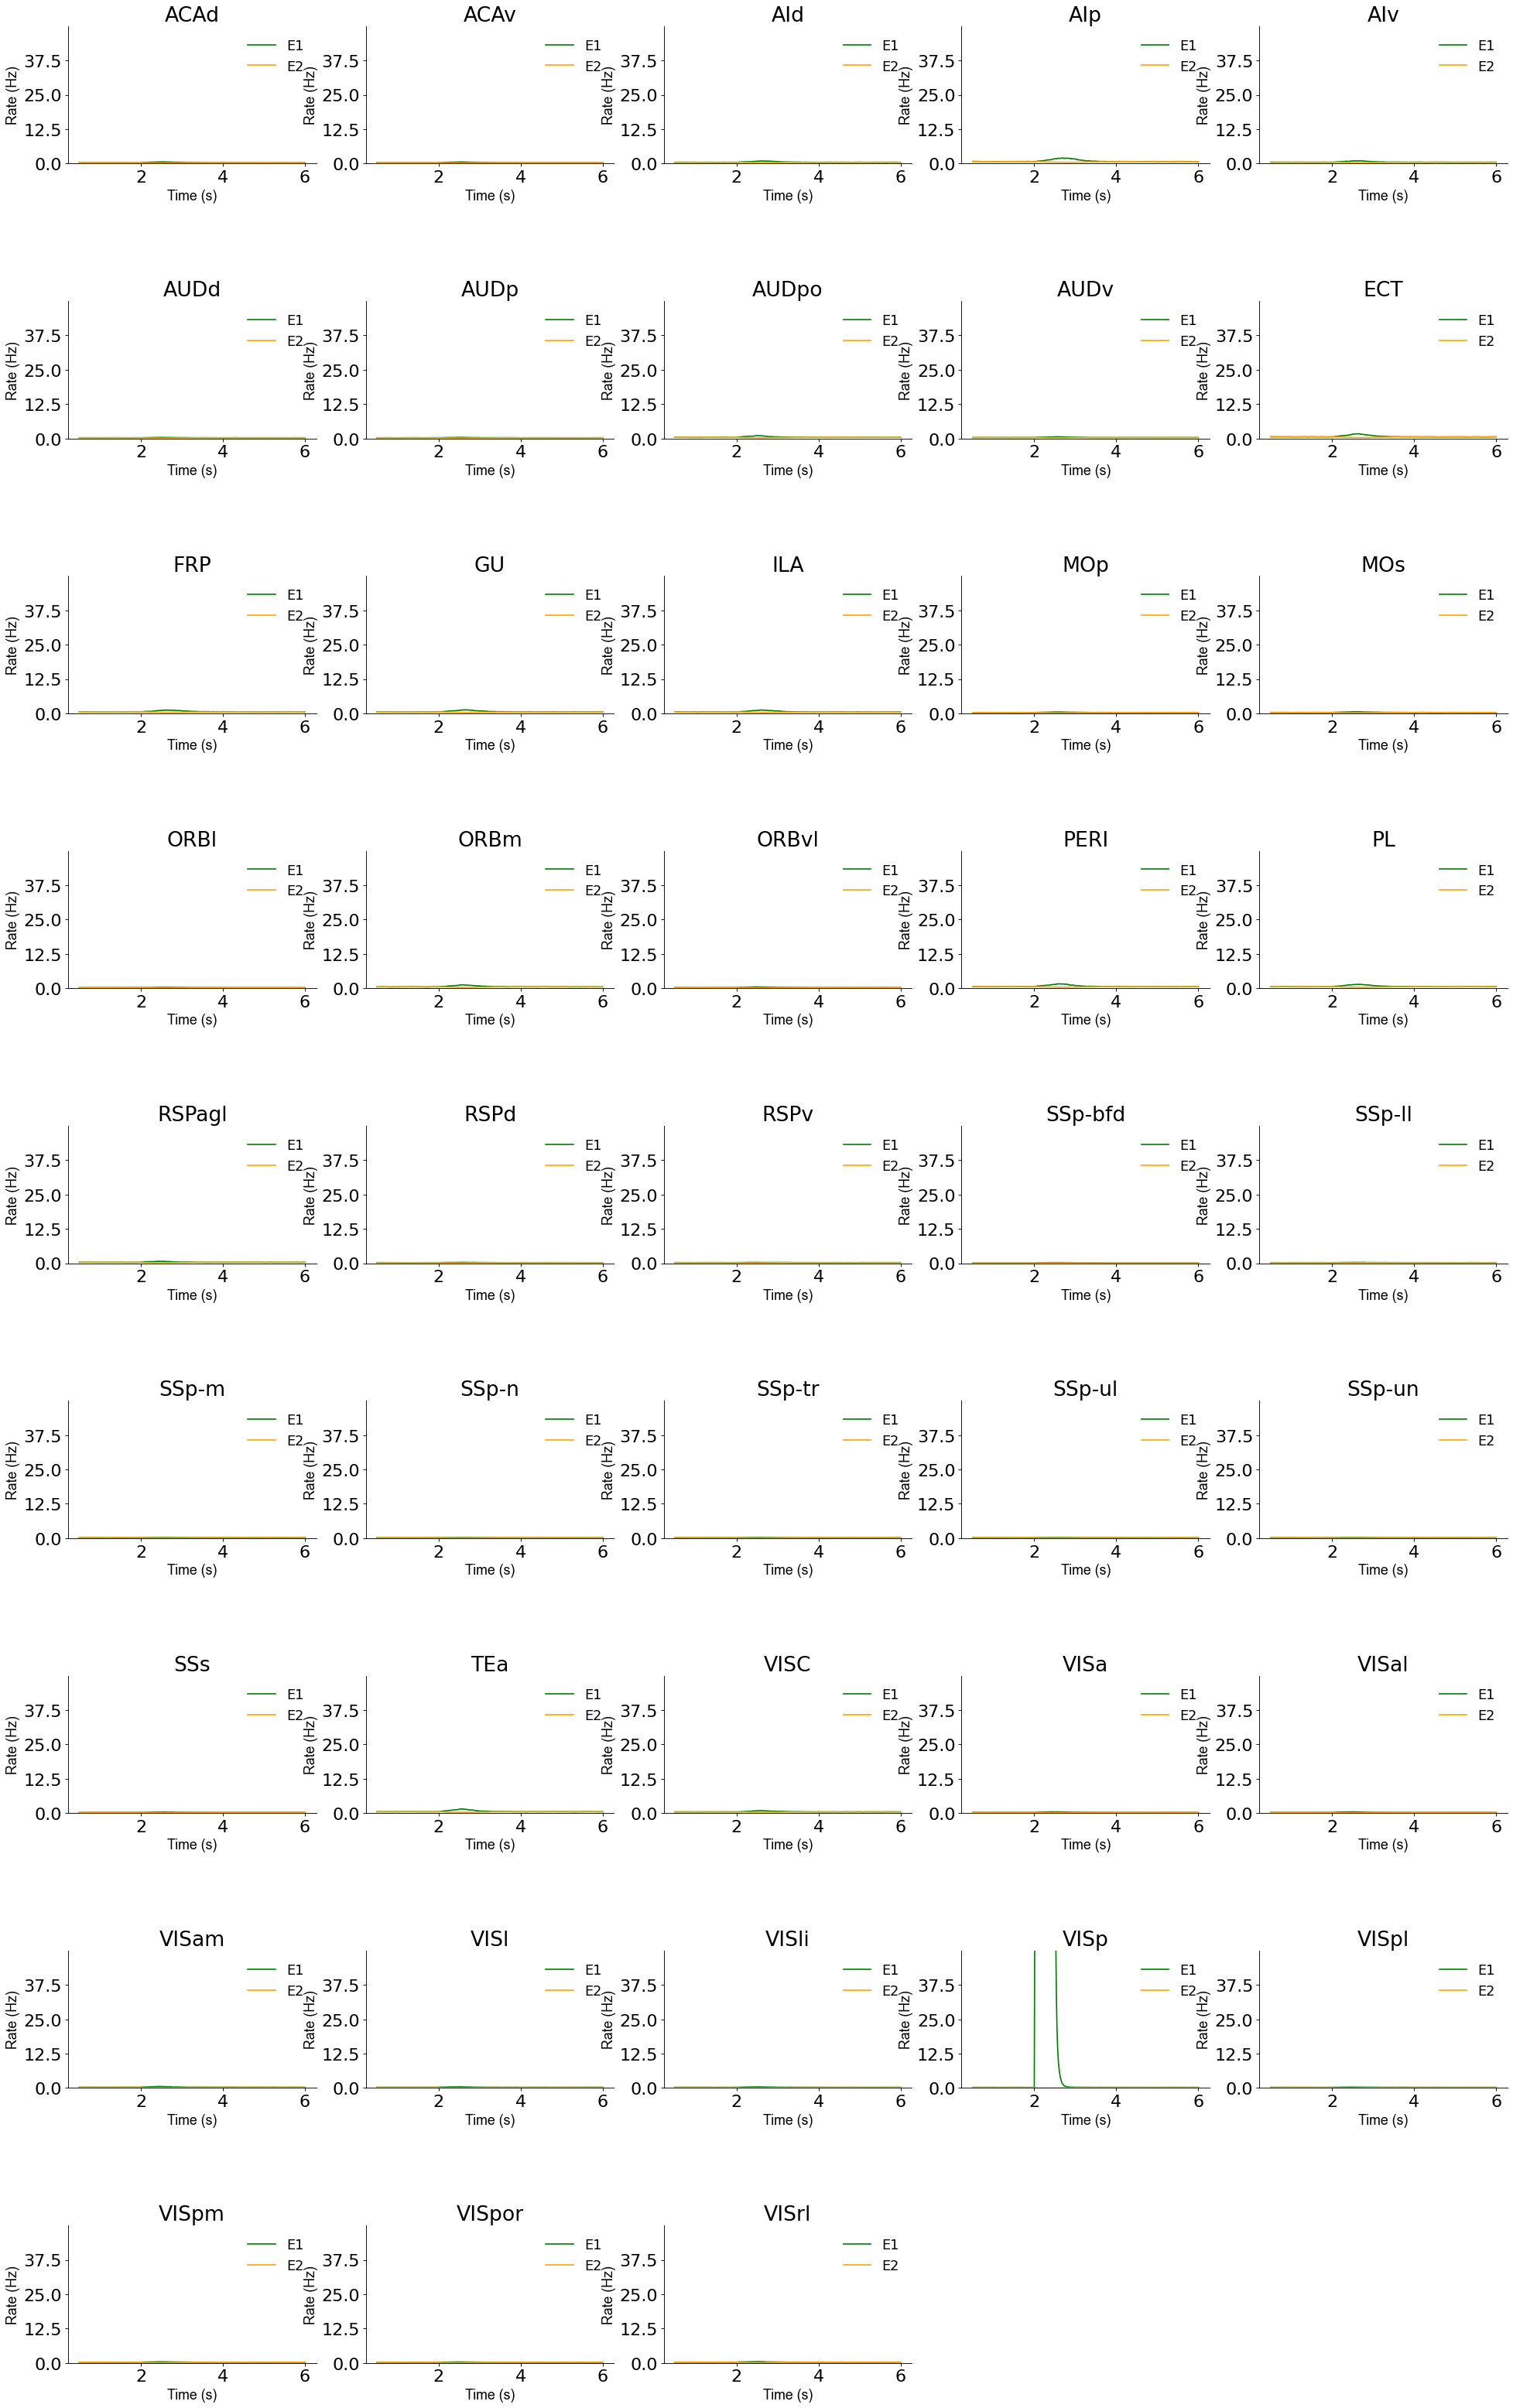

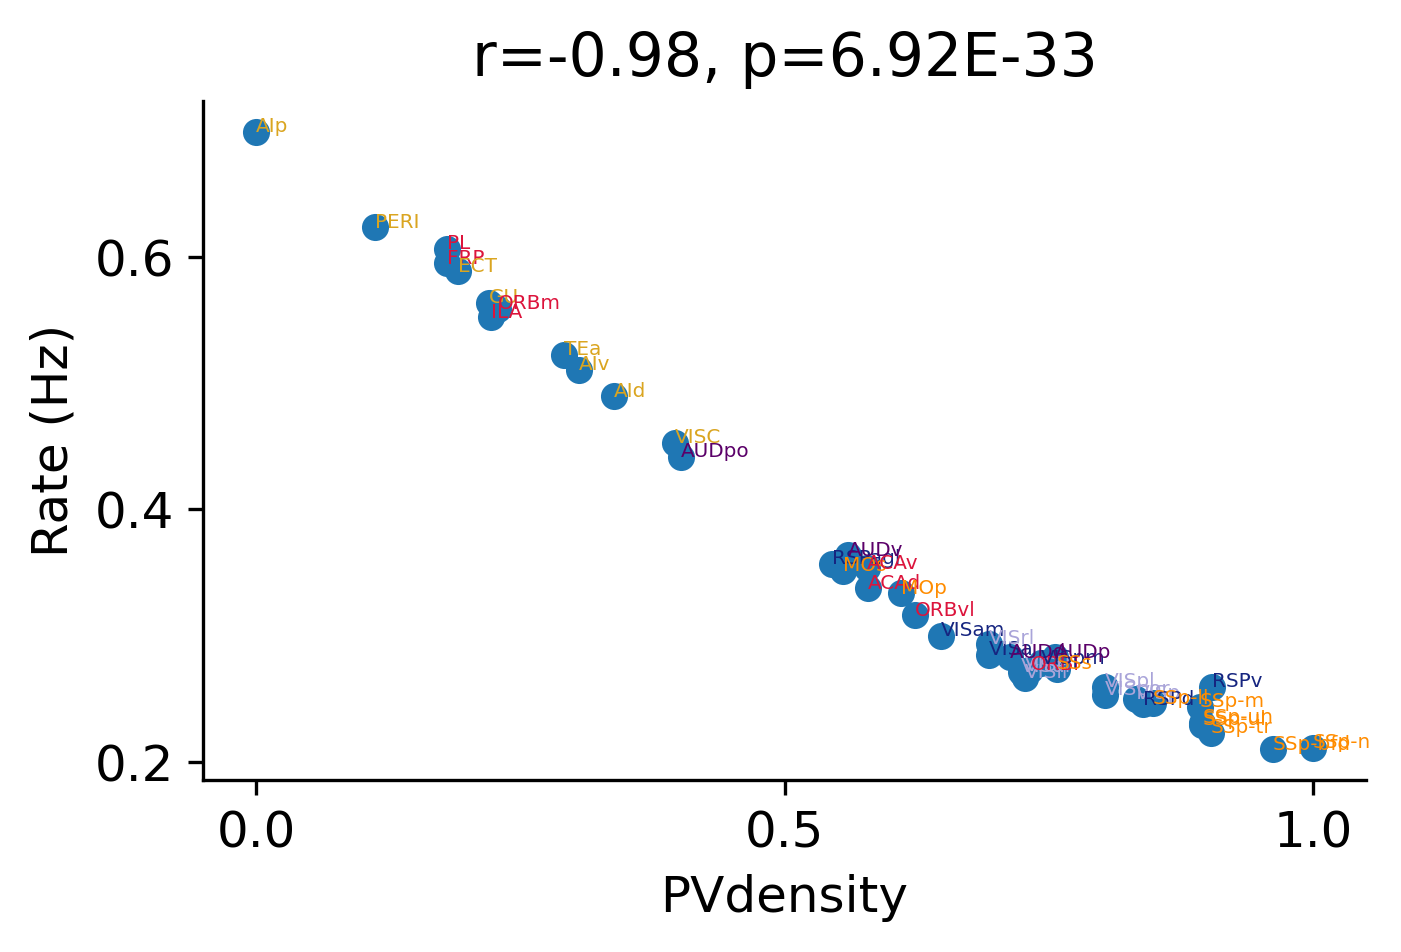

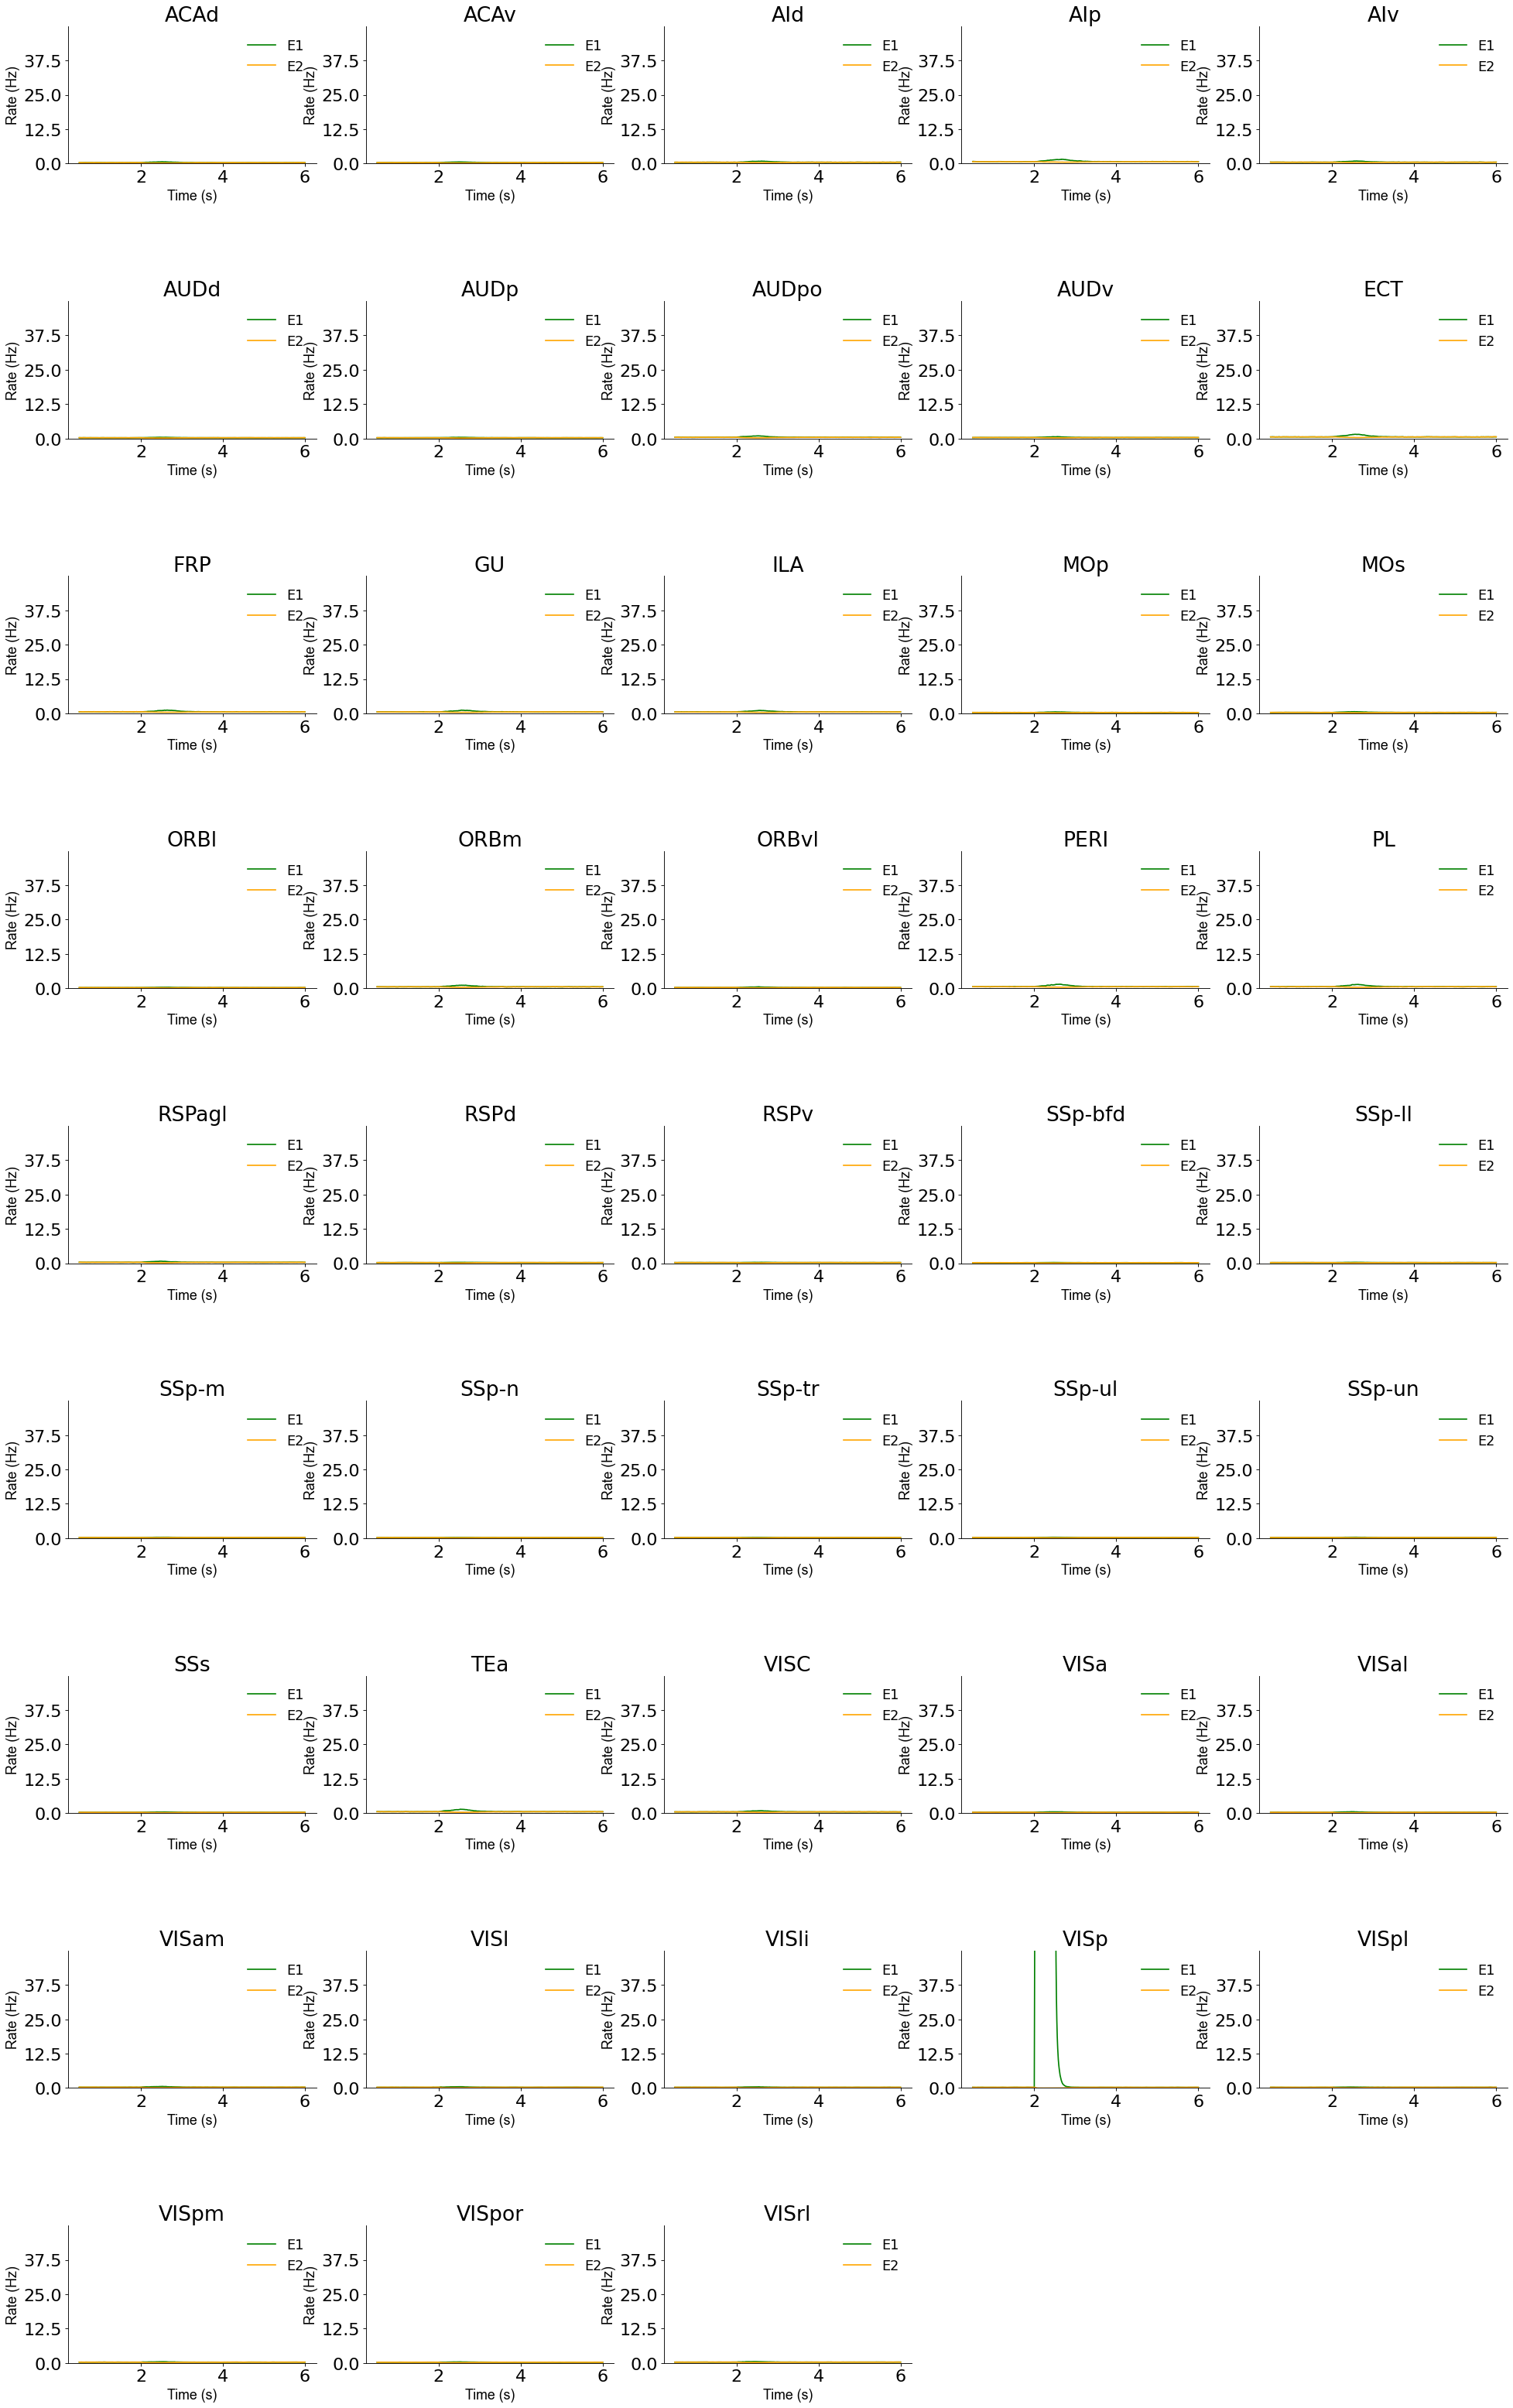

In [142]:
for gthcx in gthcxlist:
        with open('results/new_gthcx_test/model_V1_thal_gthcx_' + str(gthcx) + '.pkl', 'rb') as f:
            model_vary = pickle.load(f)
        [persistentactlist, _, _, _] = model_vary.save_delay_activity('tempdata/',False)
        persistentact_df =  model_vary.generatePAdf(PAthreshold)
        model_vary.plotFRvsPV(False, True, 0.5, (5,3), 12, False, 'FRvsPV.pdf')
        model_vary.plotFRallarea(plot_interneuron = False,ylimit = 50, savefig = savefigflag, figfilename = 'FRallcortex.pdf')
        print(gthcx)

'PL'

IndexError: index 0 is out of bounds for axis 0 with size 0

In [208]:
with open('results/model_V1_thal_gthcx_60. pA.pkl', 'rb') as f:
        model_test = pickle.load(f)
[persistentactlist,baselineactlist,LRtoElist,LRtoIlist] = model_test.save_delay_activity('tempdata/',False)
persistentact_df =  model_test.generatePAdf(PAthreshold)
if model_test.thcxmodel == True:
    th_hierarchy = np.arange(0,1,1/40)
    th_persistentact_df = model_V1.generate_th_PAdf(th_PAthreshold, th_hierarchy)

meanFR = persistentact_df['persistentact'].mean()

In [209]:
meanFR 

20.862025407702696

In [ ]:
# mainsim backup
parameters['trial_length'] = 10000 * brian2.ms # trial length (s) 
# change noise level and stim strength before simulation.
parameters['stim_on'] = 2 * brian2.second
parameters['stim_off'] = 2.5 * brian2.second
parameters['distract_on'] = 9.5 * brian2.second
parameters['distract_off'] = 12 * brian2.second
parameters['stim_strength'] = 0.5 * brian2.nA
parameters['distract_strength'] = 10 * parameters['stim_strength']
parameters['inh_strength'] = - 0.4 * brian2.nA
parameters['inh_stim_on'] = 10 * brian2.second
parameters['inh_stim_off'] = 13 * brian2.second

parameters['std_noise'] = 0.005 * brian2.nA

#####
parameters['WNormalizedbyRow'] = False
###########################
#####
# parameters['mu_EE'] = 0
parameters['mu_EE'] = 0.0 * brian2.nA    #0.06*1.8 cortical #0.025*1.8  # 0.015*1.8  #0.058*1.8 thal  # 0.065*1.8 PV only   # 0.06*1.8 PV only is really good! 
# parameters['mu_EE'] = 0.1 * brian2.nA

# 0.065 
# parameters['mu_EE'] = 0.09    # 0.09 multiple attractor   #0.03~0.05 multiple attractor with gee = 0.505
#####
parameters['ratio_mu_IE_mu_EE'] = 3/1.8  #4.5/1.8 thalam #  3/1.8 cortical
parameters.update({'mu_IE': parameters['mu_EE']*parameters['ratio_mu_IE_mu_EE']})
# changing parameter so that the baseline is stable.
######
parameters['I0_E_mean'] = 0.305 * brian2.nA   #284 thala  #305 cortex
######
parameters['I0_E_min'] = parameters['I0_E_mean']
parameters['I0_E_max'] = parameters['I0_E_mean']

#######################
parameters['I0_th_E'] = 0.305 * brian2.nA  # 0.405*brian2.nA            #0.385*brian2.nA         #0.355 * brian2.nA   #0.285 * brian2.nA
# parameters['g_th_cx_E'] = 0.8 * brian2.nA  #0.6 #0.15*brian2.nA          #0.18*brian2.nA       #0.1    * brian2.nA
# parameters['g_th_cx_I'] = 0 * brian2.nA       # 0 * brian2.nA

# cortical input to thalamus = cx_th  
parameters['g_cx_th'] = 0.16 * brian2.nA   # 0.15 # 0.15*brian2.nA  # 0.18*brian2.nA         # 0.1      * brian2.nA
                        #0.00?
                        
# thalamic input to cortex = th_cx 
parameters['g_th_cx_E_mean'] = 0.16 * brian2.nA  # 0.8  #1.1  #1.85
k_gth_E = 0.00 * brian2.nA  #0.8   #1.2 for the alternate regime where the MOs lose firing after inhibition.  # 0.7
parameters['g_th_cx_E_min'] = parameters['g_th_cx_E_mean'] - k_gth_E*0.5
parameters['g_th_cx_E_max'] = parameters['g_th_cx_E_mean'] + k_gth_E*0.5

parameters['g_th_cx_E_mode'] = 'linear' #'logistic'

# thalamic input to cortex = th_cx 
parameters['g_th_cx_I_mean'] = parameters['g_th_cx_E_mean'] * parameters['ratio_mu_IE_mu_EE'] * 2     # 0.8
# k_gth_I = parameters['g_th_cx_I_mean']
k_gth_I = 0 * brian2.nA
parameters['g_th_cx_I_min'] = parameters['g_th_cx_I_mean'] - k_gth_I*0.5
parameters['g_th_cx_I_max'] = parameters['g_th_cx_I_mean'] + k_gth_I*0.5
parameters['g_th_cx_I_mode'] = 'linear'


######
parameters['g_E_self'] = 0.4 * brian2.nA      #0.4 cortical  # 0.505 for isolated areas use only #0.2 thalamc
######

######## PV local gradient
parameters['J_G_EI_min'] = 0.6   # 0.6
parameters['JEI_scaling_factor'] = 0.5 # 0.5  # 0.6 gives a good example of senerio 2. 

parameters['J_G_II_min'] = 0.7   # 0.7
parameters['JII_scaling_factor'] = 0.5  # 0.5


parameters['J_N_IE_min'] = 0.65   # 0.65   #0.5
parameters['JIE_scaling_factor'] = 0   #0.5


####### connectivity scaling
parameters['kSquishFln'] = 0.3  # 0.3 


parameters['a_E'] = 280. * parameters['SF1'] * brian2.Hz/brian2.nA  # Hz/nA  #280
parameters['b_E'] = 108. * parameters['SF1'] * brian2.Hz            # Hz

######
parameters['d_E'] = 0.154 * parameters['SF2'] * brian2.second        # s   # 0.154   #0.4  # 0.6
######

parameters['figurefolder'] = 'figure/'
savefigflag = False

thcxmodel = True
distractionInput = False

parameters['thcxmodel'] = thcxmodel
parameters['distractionInput'] = distractionInput

# conn_shuffle = shuffleMat(conn_cxcx, 43)

model_V1 = model(parameters, False, conn_cxcx, pref_matrix, hierarchy_df, normPVgrad_df, normSSTgrad_df, area_list, thcxmodel, conn_thcx, conn_cxth, thal_list)
# model_V1 = model(parameters, False, conn_cxcx, , , normPVgrad_df, normSSTgrad_df, area_list, thcxmodel, conn_thcx, conn_cxth, thal_acr)
# need to change pref matrix to affect LR connections. 
if not thcxmodel:
    model_V1.add_input(parameters['stim_strength'],['VISp'], parameters['stim_on'], parameters['stim_off'], 'E1')
#     model_V1.add_input(parameters['stim_strength'],area_list, parameters['stim_on'], parameters['stim_off'], 'E1')
    if distractionInput:
        model_V1.add_input(parameters['distract_strength'],['VISp'], parameters['distract_on'], parameters['distract_off'], 'E2')
#     model_V1.add_input(parameters['stim_strength'], ['ACAd','MOs','PL','ILA'], parameters['stim_on'], parameters['stim_off'], 'E1')
# ['ACAd', 'PL','MOs','ORBm']
#     model_V1.add_input(parameters['inh_strength'], ['TEa'], parameters['stim_off']*1.1, parameters['stim_off']*3, 'E1')  # new attractor 

#     model_V1.add_input(parameters['inh_strength'], ['ORBm','ACAd'], parameters['stim_off']*1.1, parameters['stim_off']*2, 'E1')
    
    
    
if thcxmodel:
    model_V1.add_input(parameters['stim_strength'], ['VISp'], parameters['stim_on'], parameters['stim_off'], 'E1')
#     model_V1.add_input_TH_new(parameters['stim_strength'],['LGd'],parameters['stim_on'], parameters['stim_off'], 'E1',rampingperiod=0)
    if distractionInput:
        model_V1.add_input_TH_new(parameters['distract_strength'],['LGd'],parameters['distract_on'], parameters['distract_off'], 'E2',rampingperiod=0)

# model_V1.add_input_TH(parameters['inh_strength'],['LGd'],parameters['stim_off'], parameters['trial_length'], 'both')
# model_V1.add_input(parameters['inh_strength'], ['VISp'], parameters['stim_off'], parameters['trial_length'], 'both')
# model_V1.add_input(parameters['inh_strength'], ['AUDp'], parameters['stim_off'], parameters['trial_length'], 'both')

# model_V1.add_input(parameters['stim_strength'], ['AUDp'], parameters['stim_on'], parameters['stim_off'], 'E1')
# model_V1.add_input(parameters['stim_strength'], ['SSp-bfd'], parameters['stim_on'], parameters['stim_off'], 'E1')
# model_V1.add_input_TH(parameters['inh_strength'], ['VM','VAL'], parameters['inh_stim_on'], parameters['inh_stim_off'], 'both')

# if not thcxmodel:
#     model_V1.add_input(parameters['inh_strength'], ['AUDpo'], parameters['inh_stim_on'], parameters['trial_length'], 'both')
# if thcxmodel:
#     model_V1.add_input_TH(parameters['inh_strength'], ['VM','VAL'], parameters['inh_stim_on'], parameters['inh_stim_off'], 'both')
#     connection_list = []

#     model_V1.cut_connection_thcx([('VM','MOs'),('VAL','MOs')])
# #   for cxarea in area_list_sort:
#     for tharea in thal_list_sort:
#         connection_list.append((tharea,'MOs'))
#     model_V1.cut_connection_thcx(connection_list,printout=False)

#     model_V1.add_input_TH(parameters['inh_strength'], ['VM','VAL','VPMpc','AV', 'IMD','MD','SMT','PCN','CL'], parameters['inh_stim_on'], parameters['inh_stim_off'], 'both')

# model_V1.add_input_TH(parameters['inh_strength'], ['VAL', 'VM', 'VPL', 'VPLpc', 'VPM', 'VPMpc', 'SPFm', 'SPFp', 'SPA', 'PP', 'MG', 'LGd', 'LP', 'PO', 'POL', 'SGN', 'AV', 'AM', 'AD', 'IAM', 'IAD', 'LD', 'IMD', 'MD', 'SMT', 'PR', 'PVT', 'PT', 'RE', 'RH', 'CM', 'PCN', 'CL', 'PF', 'RT', 'IGL', 'LGv', 'SubG', 'MH', 'LH'], parameters['inh_stim_on'], parameters['inh_stim_off'], 'both')
# 'IMD','MD','SMT','PCN','CL'
# # we found a new attractor state. SSp-tr_VISp_ACAd_AUDpo_70. pA and AIv_MOs_VISrl_VISam_VISrl_70. pA.  Here I tried to see if it is really a new one. 
# model_V1.add_input(parameters['stim_strength'], ['SSp-tr','VISp','ACAd','AUDpo'])
# model_V1.add_input(parameters['stim_strength'], ['AIv','MOs','VISrl','VISam','VISrl'])

# # Here we want to simulate the effect of activating some areas receiving thalamic input. 
# model_V1.add_subcorx_input(MDinput_strength,MDinputarea)
# model_V1.add_subcorx_input([parameters['thalamic_base_strength'],parameters['thalamic_base_strength']], ['VISp','VISpl'])

model_V1.run_sim(vocal_prompt = False)
[persistentactlist, baselineactlist, LRtoElist, LRtoIlist] = model_V1.save_delay_activity('tempdata/', False)
if model_V1.thcxmodel == True:
    th_persistentactlist = model_V1.save_th_delay_activity('tempdata/',False)
